# The Business Challenge


## The Blocker Fraud Company

- Financial transactions' fraud detection specialized company.
- The Blocker Fraud service ensures fraudulent transactions block.
- Business Model: service's performance monetization.

### Expansion Strategy in Brazil

1. The company receives 25% of each transaction value truly detected as fraud.
2. The company receives 5% of each transaction value detected as fraud, however the transaction is legitimate.
3. The company gives back 100% of the value for the customer in each transaction detected as legitimate, however the transaction is actually a fraud.

### Goal

- Create a model with high accuracy and precision with respect to transactions' fraud detection.

### Deliverables

- Deployed model with API access. The API must inform "Fraud" or "Legitimate" when the transaction is inputed.


- A Readme about how to use the tool.


- Model performance and results report with respect to profit and loss. The following questions must be answered:

     - What is the model's precision and accuracy?
     - What is the model's reliability with respect to transactions' classification as legitimate or fraudulent?
     - What is the company's forecasted revenue if the model classifies 100% of the transactions?
     - What is the company's forecasted loss in case of model's failure?
     - What is the Blocker Fraud Company forecasted profit using the model?

###  Consequences of Financial Fraud

 First, serving as a **signal of dishonesty**, financial fraud makes customers and suppliers cast doubt on a firm’s commitments in the product market, which will weaken the incentives for customers and suppliers to sign contracts with the company. Second, financial fraud directly **affects a firm’s financing abilities and financing costs**, as well as the adjustments of corporate governance (such as the departure of executives). This leads to great difficulties and uncertainties in a company’s production and operation activities. Thus, it is impossible for fraud firms to fulfil their existing commitments (or future commitments) (Cornell & Shapiro, 1987).
 
 According to Infosecurity Magazine, **fraud cost the global economy £3.2 trillion in 2018**. For some businesses, losses to fraud reach more than 10% of their total spending. Such massive losses push companies to search for new solutions to prevent, detect, and eliminate fraud.

<img src= "../data/external/fraud_losses.png">

Fraud can have a devastating impact on a business. In 2001, a **massive corporate fraud** was uncovered at Enron, a U.S.-based energy company. Executives used a variety of techniques to disguise the company’s financial health, including the deliberate obfuscation of revenue and misrepresentation of earnings. After the fraud was uncovered, shareholders saw share prices plummet from around $90 to less than $1 in a little over a year. Company employees had their equity wiped out and lost their jobs after Enron declared bankruptcy. The Enron scandal was a major driver behind the regulations found in the **Sarbanes-Oxley Act** passed in 2002.

Compared with the control firms, firms engaging in financial fraud exhibit a **decline in sales revenue** by 11.9–17.1% and a **decrease in their gross profit margi** on sales by 2.4–2.8% in the three years after punishment. Furthermore, sales revenue from the top five large customers falls 43.9–55.1% in the post-punishment period, while sales revenue from small customers does not decline significantly.

# 0.0 Imports

In [2]:
# utilities
import pickle
from IPython.display import HTML
from collections import Counter

# data manipulation
import pandas as pd
import numpy as np
from sklearn.utils import shuffle

# PySpark for data manipulation
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import StructField, StringType, ShortType, DoubleType, StructType, IntegerType
from pyspark.sql.functions import format_number, skewness, kurtosis, col, when, isnan, count
from pyspark.sql import DataFrame as SparkDataFrame
import pyspark.pandas as ps
from pyspark.pandas import read_csv
import pyspark.sql.functions as f


# text edit
import inflection

# EDA
import matplotlib.pyplot as plt
import seaborn as sns
#from pandas_profiling import ProfileReport
from IPython.display import IFrame

# preprocessing
from sklearn.preprocessing import MinMaxScaler, RobustScaler


# machine learning
from sklearn.model_selection import train_test_split

# algorithms
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# models' cross-validation
from sklearn.model_selection import cross_validate, cross_val_score, cross_val_predict, RandomizedSearchCV

# models' cross-validation
from sklearn.model_selection import cross_validate, cross_val_score, cross_val_predict, RandomizedSearchCV

# models' metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,\
confusion_matrix, matthews_corrcoef, make_scorer, roc_curve

# model calibration
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

# import packages for hyperparameters tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

 # apply stratified sampling
from sklearn.model_selection import StratifiedShuffleSplit

# warning
import warnings
warnings.filterwarnings( 'ignore' )

# 0.1 Helper Functions

In [3]:
def my_settings():
    %matplotlib inline
    
    # plotly settings
    plt.style.use( 'ggplot' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 8
    
    # sets global SEED
    SEED = 42
 
    # notebook settings
    display(HTML('<style>.container{width:100% !important;}</style>'))
    np.set_printoptions(suppress=True)
    pd.set_option('display.float_format', '{:.3f}'.format)
    
    # seaborn settings
    sns.set(rc={'figure.figsize':(25,12)})
    sns.set_theme(style = 'darkgrid', font_scale = 1)
my_settings()

In [4]:
def renameCols(df, old_columns, new_columns):
    for old_col,new_col in zip(old_columns,new_columns):
        df = df.withColumnRenamed(old_col,new_col)
    return df

In [5]:
 # Descriptive Statistics function
# valid only for numerical attriubutes
def num_stats(num_attr):
    # Central Tendency - mean, median
    ct1 = pd.DataFrame( num_attr.apply( np.mean ) ).T
    ct2 = pd.DataFrame( num_attr.apply( np.median ) ).T

    # Dispersion - standard deviation (std), min, max, skew, kurtosis
    d1 = pd.DataFrame( num_attr.apply( np.std ) ).T
    d2 = pd.DataFrame( num_attr.apply( min ) ).T
    d3 = pd.DataFrame( num_attr.apply( max ) ).T

    # Dispersion - values' Range
    d4 = pd.DataFrame( num_attr.apply( lambda x: x.max() - x.min() ) ).T

    # Dispersion - skew and kurtosis
    d5 = pd.DataFrame( num_attr.apply( lambda x: x.skew() ) ).T
    d6 = pd.DataFrame( num_attr.apply( lambda x: x.kurtosis() ) ).T

    # Concatenate all data frames
    m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
    m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
    
    # histogram
    num_hist = num_attr.hist( bins=25, figsize=(20,15) );

    # display dataframe
    return m
    
    # display histogram
    return num_hist

In [6]:
# point biserial correlation coefficient heatmap function
def point_bi_corr(a, b):
    # a: input dataframe with binary variable
    # b: input dataframe with continuous variable
    
    # get column name
    a_name = a.columns[0]
    b_name = b.columns[0]
    
    # transform dataframe to array
    a = a.values.reshape(-1)
    b = b.values.reshape(-1)
    
    # apply scipy's point-biserial
    stats.pointbiserialr(a, b)
    
    # correlation coefficient array
    c = np.corrcoef(a,b)
    
    # dataframe for heatmap
    df = pd.DataFrame(c, columns=[a_name, b_name], index=[a_name, b_name])
    
    # return heatmap
    return sns.heatmap(df, annot=True).set_title('{} x {} correlation heatmap'.format(a_name, b_name));

In [7]:
# Model's performance function
def performance(model, x_train, y_train):
    # define scoring metrics
    scoring = {'accuracy': 'accuracy',
               'precision': make_scorer(precision_score),
               'recall': make_scorer(recall_score),
               'f1_score': make_scorer(f1_score),
               'roc_auc_score': make_scorer(roc_auc_score),
               'mcc': make_scorer(matthews_corrcoef)}

    # calculate scores with cross_validate
    scores = cross_validate(model, x_train, y_train, cv=10, scoring=scoring)

    # performance data frame
    performance = pd.DataFrame.from_dict(scores).drop(['fit_time', 'score_time'], axis=1)
    performance = pd.DataFrame(performance.mean()).T
    return performance

In [8]:
# Fine-tuned Model's performance function
def fine_tuned_performance(model, x_train, y_train):
    # define scoring metrics
    scoring = {'accuracy': 'accuracy',
               'precision': make_scorer(precision_score),
               'recall': make_scorer(recall_score),
               'f1_score': make_scorer(f1_score),
               'roc_auc_score': make_scorer(roc_auc_score),
               'mcc': make_scorer(matthews_corrcoef)}

    # calculate scores with cross_validate
    scores = cross_validate(model, x_train, y_train, cv=10, scoring=scoring)

    # performance data frame
    performance = pd.DataFrame.from_dict(scores).drop(['fit_time', 'score_time'], axis=1)
    performance = pd.DataFrame(np.round(performance.mean(), 4).astype(str) + '+/-' + np.round(performance.std()*2,4).astype(str)).T
    return performance

In [9]:

def train_test_split_pyspark(
    df: SparkDataFrame,
    startify_column: str,
    unique_col: str = None,
    train_fraction: float = 0.7,
    validation_fraction: float = 0.1,
    test_fraction: float = 0.2,
    seed: int = 1234,
    to_pandas: bool = True,
):
    if not unique_col:
        unique_col = "any_unique_name_here"
        df = df.withColumn(unique_col, f.monotonically_increasing_id())

    # Train data
    train_fraction_dict = (
        df.select(startify_column)
        .distinct()
        .withColumn("fraction", f.lit(train_fraction))
        .rdd.collectAsMap()
    )
    df_train = df.stat.sampleBy(startify_column, train_fraction_dict, seed)
    df_remaining = df.join(df_train, on=unique_col, how="left_anti")

    # Validation data
    validation_fraction_dict = {
        key: validation_fraction for (_, key) in enumerate(train_fraction_dict)
    }
    df_val = df_remaining.stat.sampleBy(startify_column, validation_fraction_dict, seed)
    df_remaining = df_remaining.join(df_val, on=unique_col, how="left_anti")

    # Test data
    test_fraction_dict = {
        key: test_fraction for (_, key) in enumerate(train_fraction_dict)
    }
    df_test = df_remaining.stat.sampleBy(startify_column, test_fraction_dict, seed)

    if unique_col == "any_unique_name_here":
        df_train = df_train.drop(unique_col)
        df_val = df_val.drop(unique_col)
        df_test = df_test.drop(unique_col)

    if to_pandas:
        return (df_train.toPandas(), df_val.toPandas(), df_test.toPandas())
    return df_train, df_val, df_test

## Create a SparkSession

In [10]:
# creates a SparkSession
spark = SparkSession.builder\
        .appName('Fraud')\
        .getOrCreate()

# Enable Arrow-based columnar data transfers
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

# customizes the output fontsize
display(HTML('''<style>[data-mime-type="application/vnd.jupyter.stdout"] pre { font-size:14px}</style>'''))

22/09/27 12:06:29 WARN Utils: Your hostname, Felipe_Pedrosa resolves to a loopback address: 127.0.1.1; using 172.28.60.80 instead (on interface eth0)
22/09/27 12:06:29 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/09/27 12:06:30 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [11]:
print('My pyspark version is %s' %pyspark.__version__)

My pyspark version is 3.3.0


In [12]:
spark

# 0.2 Loading Data

 Source data set: https://www.kaggle.com/ntnu-testimon/paysim1

## 0.2.1 Specifying dtypes for Spark DataFrame when reading from csv

In [13]:
# defines the schema: field, type, nullabe or not
data_schema = [StructField('step', ShortType(), True), 
               StructField('type', StringType(), True),
               StructField('amount', DoubleType(), True),
               StructField('nameOrig', StringType(), True),
               StructField('oldbalanceOrg', DoubleType(), True),
               StructField('newbalanceOrig', DoubleType(), True),
               StructField('nameDest', StringType(), True),
               StructField('oldbalanceDest', DoubleType(), True),
               StructField('newbalanceDest', DoubleType(), True),
               StructField('isFraud', ShortType(), True),
               StructField('isFlaggedFraud', ShortType(), True)]

# defines the final struct
final_struct = StructType(fields=data_schema)

In [14]:
# loads data set in spark
df_fraud_spark = spark.read.csv(r'../data/raw/PS_20174392719_1491204439457_log.csv', schema=final_struct, header=True)

In [15]:
spark.conf.set('spark.sql.repl.eagerEval.enabled', True)


In [16]:
df_fraud_spark.show()

+----+--------+---------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|step|    type|   amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+--------+---------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|   1| PAYMENT|  9839.64|C1231006815|     170136.0|     160296.36|M1979787155|           0.0|           0.0|      0|             0|
|   1| PAYMENT|  1864.28|C1666544295|      21249.0|      19384.72|M2044282225|           0.0|           0.0|      0|             0|
|   1|TRANSFER|    181.0|C1305486145|        181.0|           0.0| C553264065|           0.0|           0.0|      1|             0|
|   1|CASH_OUT|    181.0| C840083671|        181.0|           0.0|  C38997010|       21182.0|           0.0|      1|             0|
|   1| PAYMENT| 11668.14|C2048537720|      41554.0|      29885.86|M123070170

In [16]:
row = df_fraud_spark.count()
print('This dataset is: {} rows'.format(row))

This dataset is: 6362620 rows


- The dataset has more than 6 million entries;

In [10]:
 # displays the schema to check dtypes
df_fraud_spark.printSchema()

root
 |-- step: short (nullable = true)
 |-- type: string (nullable = true)
 |-- amount: double (nullable = true)
 |-- nameOrig: string (nullable = true)
 |-- oldbalanceOrg: double (nullable = true)
 |-- newbalanceOrig: double (nullable = true)
 |-- nameDest: string (nullable = true)
 |-- oldbalanceDest: double (nullable = true)
 |-- newbalanceDest: double (nullable = true)
 |-- isFraud: short (nullable = true)
 |-- isFlaggedFraud: short (nullable = true)



## 0.3. Split data into Train and Test set

In [17]:
df_train, df_val, df_test = train_test_split_pyspark(df=df_fraud_spark, startify_column='isFraud')

In [18]:
df_val

step      type     amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0          1   CASH_IN 269736.990   C540092563    9630666.580     9900403.570   
1          1   PAYMENT   2147.210   C202064342     101336.000       99188.790   
2          1   PAYMENT    909.330  C1627781283      67210.020       66300.680   
3          1   PAYMENT    911.270  C1095203437      25688.810       24777.540   
4          1  CASH_OUT 216007.530   C918307166    1024825.540      808818.010   
...      ...       ...        ...          ...            ...             ...   
190727   715   PAYMENT   8301.340   C768672563      11330.000        3028.660   
190728   715  CASH_OUT 252516.990  C1474155846      52271.000           0.000   
190729   715  CASH_OUT 304075.170  C1077758017        282.000           0.000   
190730   718   PAYMENT   7808.400  C1258101709       7144.000           0.000   
190731   737  TRANSFER 190100.290   C369775274     190100.290           0.000   

           nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0       C1526298704      473512.630       32092.070        0               0  
1       M1211586911           0.000           0.000        0               0  
2        M574077658           0.000           0.000        0               0  
3         M45880026           0.000           0.000        0               0  
4        C401424608     1602701.930     1178808.140        0               0  
...             ...             ...             ...      ...             ...  
190727   M390138585           0.000           0.000        0               0  
190728  C2104221637       41550.750      294067.730        0               0  
190729   C514280663     1160262.840     1464338.020        0               0  
190730  M1230239274           0.000           0.000        0               0  
190731  C1048847167           0.000           0.000        1               0  

[190732 rows x 11 columns]

In [20]:
df_train

step      type      amount     nameOrig  oldbalanceOrg  \
0           1  TRANSFER     181.000  C1305486145        181.000   
1           1  CASH_OUT     181.000   C840083671        181.000   
2           1   PAYMENT    7817.710    C90045638      53860.000   
3           1   PAYMENT    7107.770   C154988899     183195.000   
4           1   PAYMENT    7861.640  C1912850431     176087.230   
...       ...       ...         ...          ...            ...   
4453582   743  TRANSFER 1258818.820  C1531301470    1258818.820   
4453583   743  CASH_OUT 1258818.820  C1436118706    1258818.820   
4453584   743  CASH_OUT  339682.130   C786484425     339682.130   
4453585   743  TRANSFER 6311409.280  C1529008245    6311409.280   
4453586   743  TRANSFER  850002.520  C1685995037     850002.520   

         newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  isFraud  \
0                 0.000   C553264065           0.000           0.000        1   
1                 0.000    C38997010       21182.000           0.000        1   
2             46042.290   M573487274           0.000           0.000        0   
3            176087.230   M408069119           0.000           0.000        0   
4            168225.590   M633326333           0.000           0.000        0   
...                 ...          ...             ...             ...      ...   
4453582           0.000  C1470998563           0.000           0.000        1   
4453583           0.000  C1240760502      503464.500     1762283.330        1   
4453584           0.000   C776919290           0.000      339682.130        1   
4453585           0.000  C1881841831           0.000           0.000        1   
4453586           0.000  C2080388513           0.000           0.000        1   

         isFlaggedFraud  
0                     0  
1                     0  
2                     0  
3                     0  
4                     0  
...                 ...  
4453582               0  
4453583               0  
4453584               0  
4453585               0  
4453586               0  

[4453587 rows x 11 columns]

In [42]:
df_test

step  day      type    name_orig     amount  oldbalance_org  \
0          1    1   CASH_IN   C713898436  55837.160     4849053.050   
1          1    1   CASH_IN   C864221358  25090.030     6572510.820   
2          1    1   PAYMENT   C247644034   4828.430       36736.580   
3          1    1  CASH_OUT  C1949126165  30308.450       88926.200   
4          1    1   PAYMENT   C247795540  12491.010           0.000   
...      ...  ...       ...          ...        ...             ...   
343533   715   30  CASH_OUT   C551661789 205836.120       50325.000   
343534   715   30  CASH_OUT   C571291780  41781.520       20837.000   
343535   717   30   PAYMENT  C1539090295  13106.610       35969.000   
343536   717   30   CASH_IN   C483131281  51872.550      912641.000   
343537   717   30  CASH_OUT   C634090625  89681.180        7054.000   

        newbalance_orig   diff_orig    name_dest  merchant_dest  \
0           4904890.210 -111674.320   C100555887              0   
1           6597600.850  -50180.060  C1282788025              0   
2             31908.140       0.010   M214313531              1   
3             88926.200  -30308.450  C1568059495              0   
4                 0.000  -12491.010   M200744172              1   
...                 ...         ...          ...            ...   
343533            0.000 -155511.120  C2073046775              0   
343534            0.000  -20944.520   C307265065              0   
343535        22862.390       0.000  M1936548557              1   
343536       964513.550 -103745.100  C1695137697              0   
343537            0.000  -82627.180   C290472837              0   

        oldbalance_dest  newbalance_dest  diff_dest  is_fraud  \
0             66800.820        10963.660 111674.320         0   
1             80148.600            0.000 105238.630         0   
2                 0.000            0.000   4828.430         0   
3             88926.200       122750.490  -3515.840         0   
4                 0.000            0.000  12491.010         0   
...                 ...              ...        ...       ...   
343533            0.000       205836.120      0.000         0   
343534       237929.930       279711.440      0.010         0   
343535            0.000            0.000  13106.610         0   
343536            0.000            0.000  51872.550         0   
343537      1184529.960      1274211.140      0.000         0   

        is_flagged_fraud  predictions  
0                      0            0  
1                      0            0  
2                      0            0  
3                      0            0  
4                      0            0  
...                  ...          ...  
343533                 0            0  
343534                 0            0  
343535                 0            0  
343536                 0            0  
343537                 0            0  

[343309 rows x 16 columns]

# 1.0 Data Description

- **step** - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).


- **type** - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.


- **amount** - amount of the transaction in local currency.


- **nameOrig** - customer who started the transaction.


- **oldbalanceOrg** - initial balance before the transaction.


- **newbalanceOrig** - new balance after the transaction.


- **nameDest** - customer who is the recipient of the transaction.


- **oldbalanceDest** - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).


- **newbalanceDest** - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).


- **isFraud** - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.


- **isFlaggedFraud** - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

In [22]:
# df1 = df_fraud_spark.alias('df1')

In [23]:
df1 = df_train.copy()

## 1.1 Rename Columns

In [24]:
cols_old = df1.columns
cols_old

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [25]:
 # apply snakecase to columns names
snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, cols_old))

In [26]:
df1.columns = cols_new

In [27]:
#d f1 = renameCols(df1, cols_old, cols_new)

In [28]:
df1

step      type      amount    name_orig  oldbalance_org  \
0           1  TRANSFER     181.000  C1305486145         181.000   
1           1  CASH_OUT     181.000   C840083671         181.000   
2           1   PAYMENT    7817.710    C90045638       53860.000   
3           1   PAYMENT    7107.770   C154988899      183195.000   
4           1   PAYMENT    7861.640  C1912850431      176087.230   
...       ...       ...         ...          ...             ...   
4453582   743  TRANSFER 1258818.820  C1531301470     1258818.820   
4453583   743  CASH_OUT 1258818.820  C1436118706     1258818.820   
4453584   743  CASH_OUT  339682.130   C786484425      339682.130   
4453585   743  TRANSFER 6311409.280  C1529008245     6311409.280   
4453586   743  TRANSFER  850002.520  C1685995037      850002.520   

         newbalance_orig    name_dest  oldbalance_dest  newbalance_dest  \
0                  0.000   C553264065            0.000            0.000   
1                  0.000    C38997010        21182.000            0.000   
2              46042.290   M573487274            0.000            0.000   
3             176087.230   M408069119            0.000            0.000   
4             168225.590   M633326333            0.000            0.000   
...                  ...          ...              ...              ...   
4453582            0.000  C1470998563            0.000            0.000   
4453583            0.000  C1240760502       503464.500      1762283.330   
4453584            0.000   C776919290            0.000       339682.130   
4453585            0.000  C1881841831            0.000            0.000   
4453586            0.000  C2080388513            0.000            0.000   

         is_fraud  is_flagged_fraud  
0               1                 0  
1               1                 0  
2               0                 0  
3               0                 0  
4               0                 0  
...           ...               ...  
4453582         1                 0  
4453583         1                 0  
4453584         1                 0  
4453585         1                 0  
4453586         1                 0  

[4453587 rows x 11 columns]

In [29]:
df1.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4453587 entries, 0 to 4453586
Data columns (total 11 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   step              4453587 non-null  int16  
 1   type              4453587 non-null  object 
 2   amount            4453587 non-null  float64
 3   name_orig         4453587 non-null  object 
 4   oldbalance_org    4453587 non-null  float64
 5   newbalance_orig   4453587 non-null  float64
 6   name_dest         4453587 non-null  object 
 7   oldbalance_dest   4453587 non-null  float64
 8   newbalance_dest   4453587 non-null  float64
 9   is_fraud          4453587 non-null  int16  
 10  is_flagged_fraud  4453587 non-null  int16  
dtypes: float64(5), int16(3), object(3)
memory usage: 297.3+ MB


- The dataset does not have NA values.

In [30]:
#df1.show()

In [31]:
df1['is_fraud'].value_counts(normalize=True) 

0   0.999
1   0.001
Name: is_fraud, dtype: float64

In [32]:
df1['type'].value_counts(normalize=True) 

CASH_OUT   0.352
PAYMENT    0.338
CASH_IN    0.220
TRANSFER   0.084
DEBIT      0.007
Name: type, dtype: float64

- In the stratified sampled set, isFraud proportion is kept. The feature "type" has almost the same original proportion.


In [33]:
# save train set for future notebook work
df1.to_csv('../data/processed/train_set.csv', index=False)
df_val.to_csv('../data/processed/val_set.csv', index=False)
df_test.to_csv('../data/processed/test_set.csv', index=False)

In [34]:
# df1 = pd.read_csv('../data/processed/train_set.csv')

## 1.2. Data Dimension

In [35]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of columns: {}'.format(df1.shape[1]))

Number of rows: 4453587
Number of columns: 11


## 1.3. Descriptive Statistics

### 1.3.1. Numerical Attributes

In [36]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4453587 entries, 0 to 4453586
Data columns (total 11 columns):
 #   Column            Dtype  
---  ------            -----  
 0   step              int16  
 1   type              object 
 2   amount            float64
 3   name_orig         object 
 4   oldbalance_org    float64
 5   newbalance_orig   float64
 6   name_dest         object 
 7   oldbalance_dest   float64
 8   newbalance_dest   float64
 9   is_fraud          int16  
 10  is_flagged_fraud  int16  
dtypes: float64(5), int16(3), object(3)
memory usage: 297.3+ MB


In [37]:
# select numerical attributes
num_attr = df1.select_dtypes(include=['int16', 'float64'])

In [38]:
# describe numerical attributes
num_attr.describe()

step       amount  oldbalance_org  newbalance_orig  \
count 4453587.000  4453587.000     4453587.000      4453587.000   
mean      243.376   179760.758      832797.546       854051.655   
std       142.359   599793.097     2886040.306      2921951.447   
min         1.000        0.000           0.000            0.000   
25%       156.000    13382.370           0.000            0.000   
50%       239.000    74824.560       14197.000            0.000   
75%       334.000   208682.535      107222.000       144030.190   
max       743.000 73823490.360    59585040.370     49585040.370   

       oldbalance_dest  newbalance_dest    is_fraud  is_flagged_fraud  
count      4453587.000      4453587.000 4453587.000       4453587.000  
mean       1100839.682      1225126.562       0.001             0.000  
std        3414022.851      3686168.037       0.036             0.002  
min              0.000            0.000       0.000             0.000  
25%              0.000            0.000       0.000             0.000  
50%         132475.250       214249.750       0.000             0.000  
75%         942457.885      1111399.135       0.000             0.000  
max      356015889.350    356179278.920       1.000             1.000

**Check is_fraud and is_flagged_fraud features**

In [39]:
# check number of instances labeled as fraud
fraud = df1['is_fraud'].sum()

# calculate the percentage of fraud
fraud_per = (fraud / len(df1)) * 100

# check number of instances labeled as is_flagged_fraud
flagged = df1['is_flagged_fraud'].sum()

# calculate the percentage of is_flagged_fraud
flagged_per = (flagged / len(df1)) * 100

# dataframe to show the results
fraud_flagged_df = pd.DataFrame({'number_of_instances':[fraud, flagged], 
                                 'percentage_%':[fraud_per, flagged_per]},
                               index=['fraud', 'flagged'])
fraud_flagged_df

number_of_instances  percentage_%
fraud                   5709         0.128
flagged                   11         0.000

In [40]:
 # gets the number of fraud and non fraud transactions
total_fraud = df1.query("is_fraud == 1").shape[0]
total_non_fraud = df1.query("is_fraud == 0").shape[0]
total_cases = df1.shape[0]

print(f'Number of fraudulent transactions: {total_fraud} ({round(total_fraud/total_cases, 4)*100}% of the total transactions)')
print(f'Number of non fraudulent transactions: {total_non_fraud} ({round(total_non_fraud/total_cases, 4)*100}% of the total transactions)')

Number of fraudulent transactions: 5709 (0.13% of the total transactions)
Number of non fraudulent transactions: 4447878 (99.87% of the total transactions)


 **Analysis:**
- Only 0.128% of the observations are labeled as fraud
- 11 instances are labeled as is_flagged_fraud. That represents only 0.00% of the instances.

attributes   min           max         range        mean     median  \
0              step 1.000       743.000       742.000     243.376    239.000   
1            amount 0.000  73823490.360  73823490.360  179760.758  74824.560   
2    oldbalance_org 0.000  59585040.370  59585040.370  832797.546  14197.000   
3   newbalance_orig 0.000  49585040.370  49585040.370  854051.655      0.000   
4   oldbalance_dest 0.000 356015889.350 356015889.350 1100839.682 132475.250   
5   newbalance_dest 0.000 356179278.920 356179278.920 1225126.562 214249.750   
6          is_fraud 0.000         1.000         1.000       0.001      0.000   
7  is_flagged_fraud 0.000         1.000         1.000       0.000      0.000   

          std    skew   kurtosis  
0     142.359   0.375      0.329  
1  599793.029  29.914   1638.237  
2 2886039.981   5.251     32.964  
3 2921951.119   5.179     32.081  
4 3414022.468  20.420    998.606  
5 3686167.623  19.673    893.392  
6       0.036  27.877    775.101  
7       0.002 636.293 404867.000

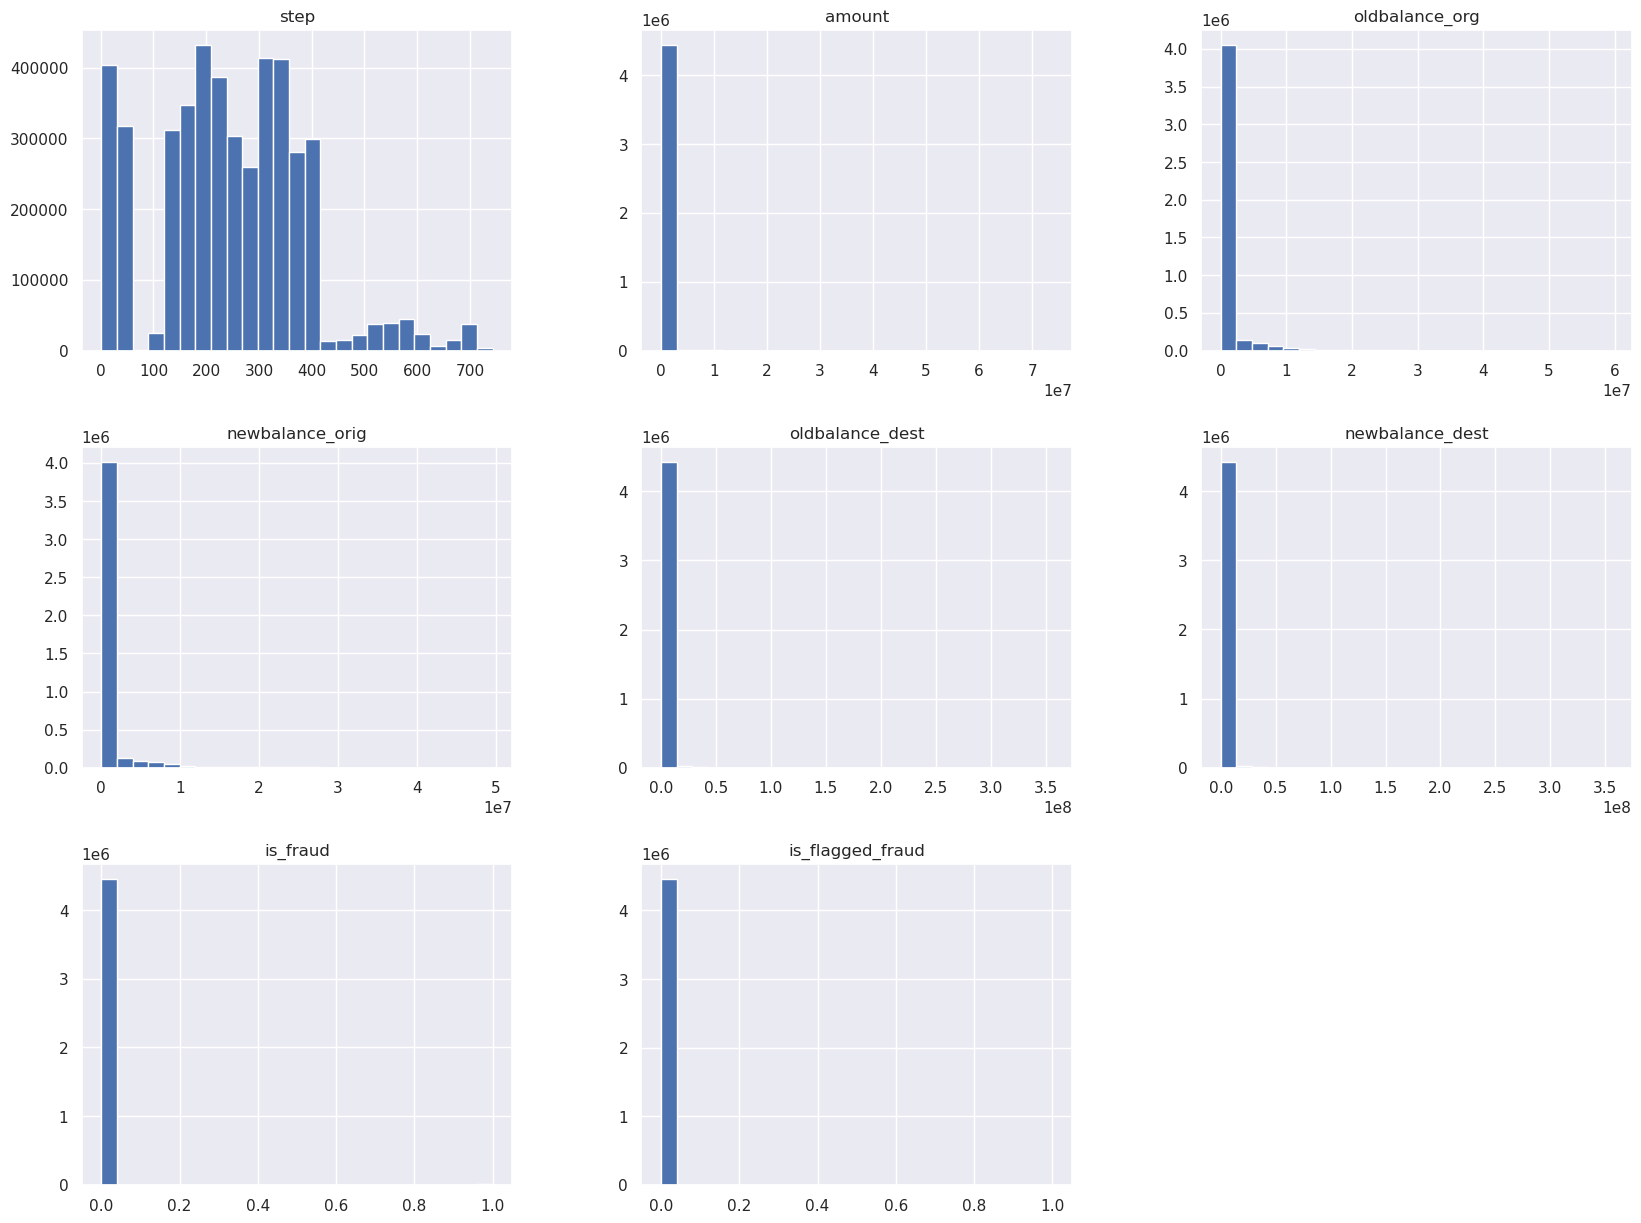

In [41]:
# apply num_stats function (see 0.1. helper function for more details)
num_stats(num_attr)

 **Descriptive Statistics Analysis:**
- None of the balances have negative numbers.
- Transaction amount ranges from 0 to more than 92 Million. Mean = 179,939. Median = 74,822. 75% of the observations are up to the value of 208,651. The minimum value is equal to zero - does it actually mean a transaction?
- The intial balance before the transaction (oldbalance_org) ranges from 0 to more than 59 Million. Mean = 834,757. Median = 14,235. 25% of the observations are equal to zero. 75% of the observations are up to the value of 107,429.
- The new balance after the transaction (newbalance_orig) ranges from 0 to more than 49 Million. Mean = 855,975. Median = 0. 50% of the observations are equal to zero. 75% of the observations are up to the value of 144,412.
- The initial balance recipient before the transaction (oldbalance_dest) ranges from 0 to more than 356 Million. Mean = 1,100,704. Median = 132,887. 25% of the observations are equal to zero. 75% of the observations are up to the value of 943,372.
- The new balance recipient after the transaction (newbalance_dest) ranges from zero to more than 356 Million. Mean = 1,225,085. Median = 214,938. 25% of the observations are equal to zero - it can be either from merchant or from fraudulent agent behaviour (cashing out of the system). 75% of the observations are up to the value of 1,112,270.

 **Histogram Analysis:**
- Between steps 50 and 75 seems that there are few / not transactions;
- After step 400 the frequency of transactions decreases significantly.
- The histograms, with exception of step feature, are not readable due to the high value range. Therefore, other types of graphs must be applied in order to check the data distribution.

#### 1.3.1.1. amount feature analysis

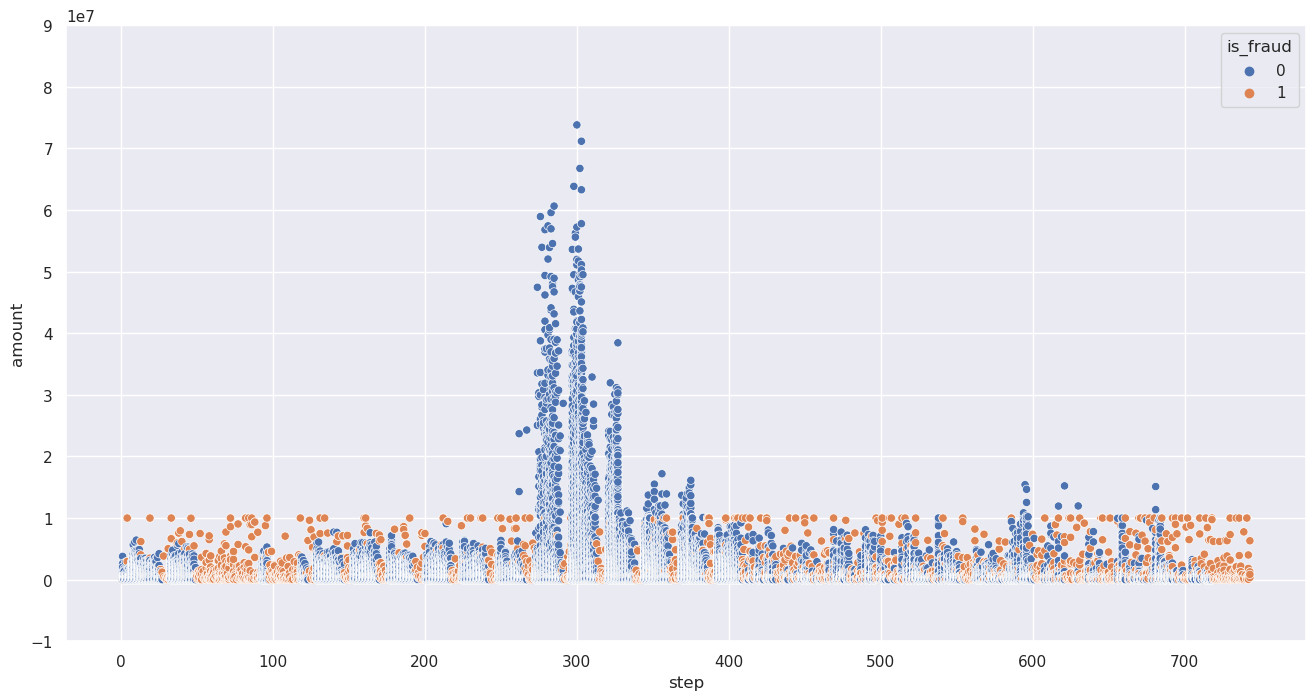

In [42]:
# plot amount scatter plot

# set up figure size
plt.subplots(figsize=(16,8))
sns.scatterplot(x='step', y='amount', hue='is_fraud', data=num_attr)

# set y-axis labels
plt.yticks(np.arange(-1.e+07, 1.e+08, step=1.e+07));

 **Analysis:**
- Fraudulent transaction amounts are up to the value of 10 million. There is not fraud transaction above transaction amount of 10 million.
- It seems that there are more fraudulent transactions than normal ones from step 50 to 100 and after step 700.

<AxesSubplot:xlabel='amount'>

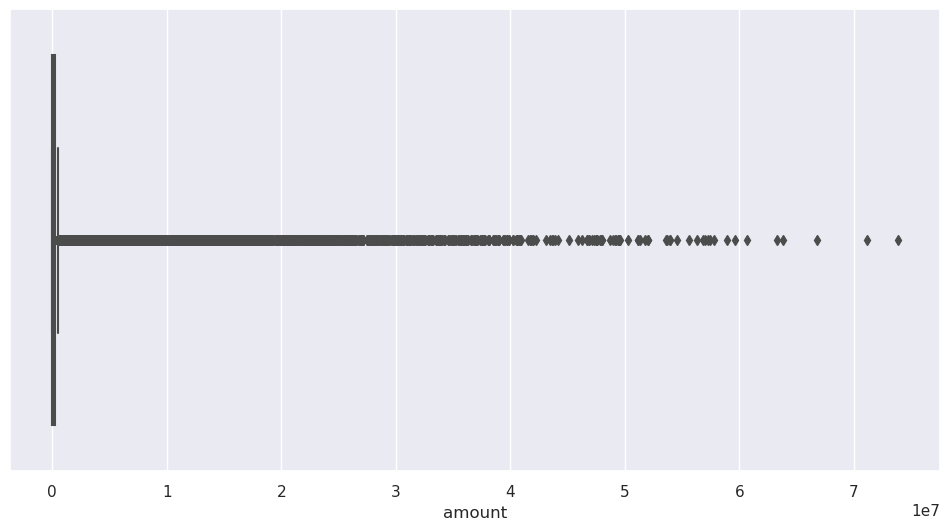

In [43]:
# boxplot
plt.subplots(figsize=(12,6))
sns.boxplot(num_attr['amount'])

In [44]:
 # check transactions with amount equal zero
aux1 = df1[df1['amount'] == 0]
aux2 = len(aux1)
aux2 

14

In [45]:
aux1

step      type  amount    name_orig  oldbalance_org  newbalance_orig  \
1915449   212  CASH_OUT   0.000  C1510987794           0.000            0.000   
2632541   279  CASH_OUT   0.000   C539112012           0.000            0.000   
3894324   387  CASH_OUT   0.000  C1294472700           0.000            0.000   
4197106   425  CASH_OUT   0.000   C832555372           0.000            0.000   
4317595   554  CASH_OUT   0.000    C10965156           0.000            0.000   
4343473   586  CASH_OUT   0.000  C1303719003           0.000            0.000   
4386189   617  CASH_OUT   0.000  C1971175979           0.000            0.000   
4396844   646  CASH_OUT   0.000  C2060908932           0.000            0.000   
4396846   646  CASH_OUT   0.000  C1997645312           0.000            0.000   
4406952   671  CASH_OUT   0.000  C1960007029           0.000            0.000   
4445579   702  CASH_OUT   0.000  C1461113533           0.000            0.000   
4453478   730  CASH_OUT   0.000   C729003789           0.000            0.000   
4453480   730  CASH_OUT   0.000  C2088151490           0.000            0.000   
4453564   741  CASH_OUT   0.000   C312737633           0.000            0.000   

           name_dest  oldbalance_dest  newbalance_dest  is_fraud  \
1915449  C1696624817            0.000            0.000         1   
2632541  C1106468520       538547.630       538547.630         1   
3894324  C1325541393      7970766.570      7970766.570         1   
4197106  C1462759334        76759.900        76759.900         1   
4317595  C1493336195       230289.660       230289.660         1   
4343473   C900608348      1328472.860      1328472.860         1   
4386189  C1352345416            0.000            0.000         1   
4396844  C1587892888            0.000            0.000         1   
4396846   C601248796            0.000            0.000         1   
4406952   C459118517        27938.720        27938.720         1   
4445579  C1382150537       107777.020       107777.020         1   
4453478  C1388096959      1008609.530      1008609.530         1   
4453480  C1156763710            0.000            0.000         1   
4453564  C1400061387       267522.870       267522.870         1   

         is_flagged_fraud  
1915449                 0  
2632541                 0  
3894324                 0  
4197106                 0  
4317595                 0  
4343473                 0  
4386189                 0  
4396844                 0  
4396846                 0  
4406952                 0  
4445579                 0  
4453478                 0  
4453480                 0  
4453564                 0

#### 1.3.1.2. oldbalance_org feature analysis

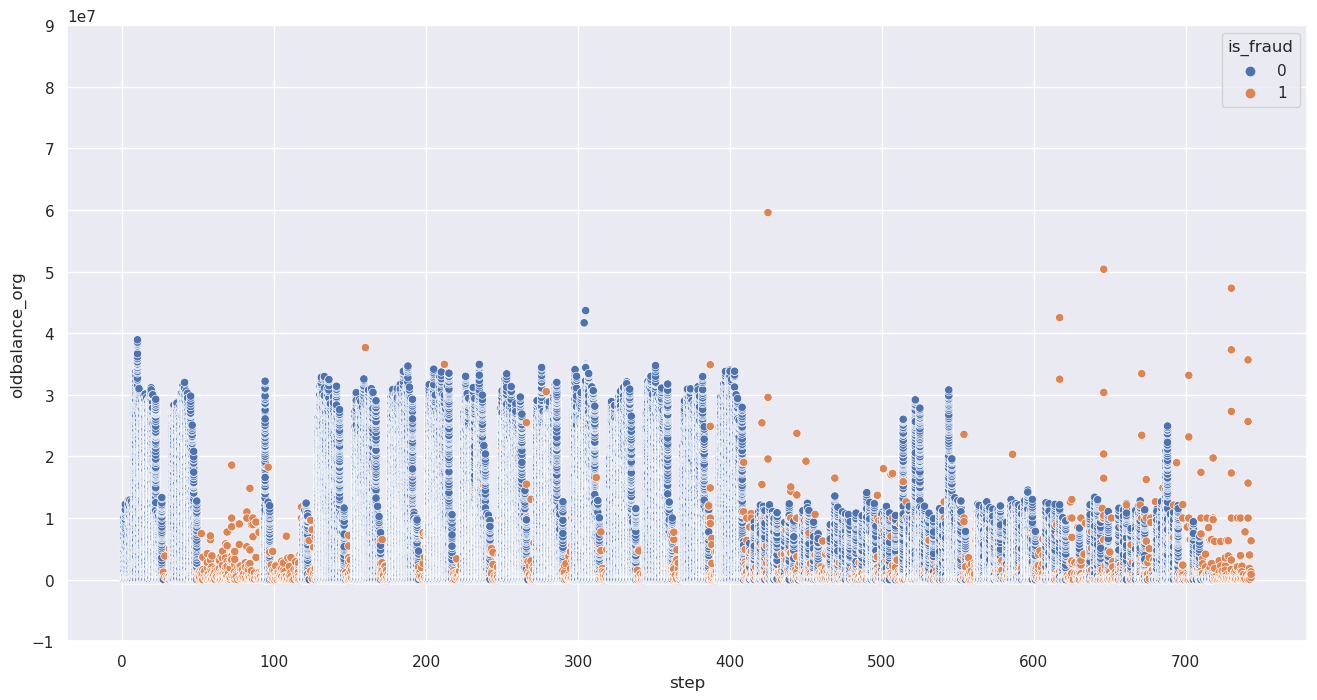

In [46]:
## # plot oldbalance_org scatter plot

# set up figure size
plt.subplots(figsize=(16,8))
sns.scatterplot(x='step', y='oldbalance_org', hue='is_fraud', data=num_attr)

# set y-axis labels
plt.yticks(np.arange(-1.e+07, 1.e+08, step=1.e+07));## 1.6.1.2. oldbalance_org feature analysis

<AxesSubplot:xlabel='oldbalance_org'>

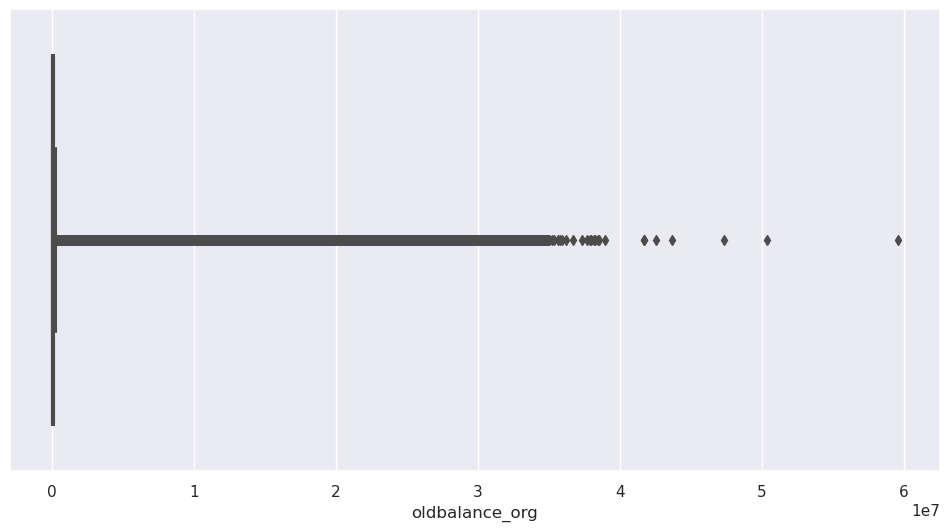

In [47]:
 # oldbalance_org boxplot
plt.subplots(figsize=(12,6))
sns.boxplot(num_attr['oldbalance_org'])

#### 1.3.1.3. newbalance_orig feature analysis

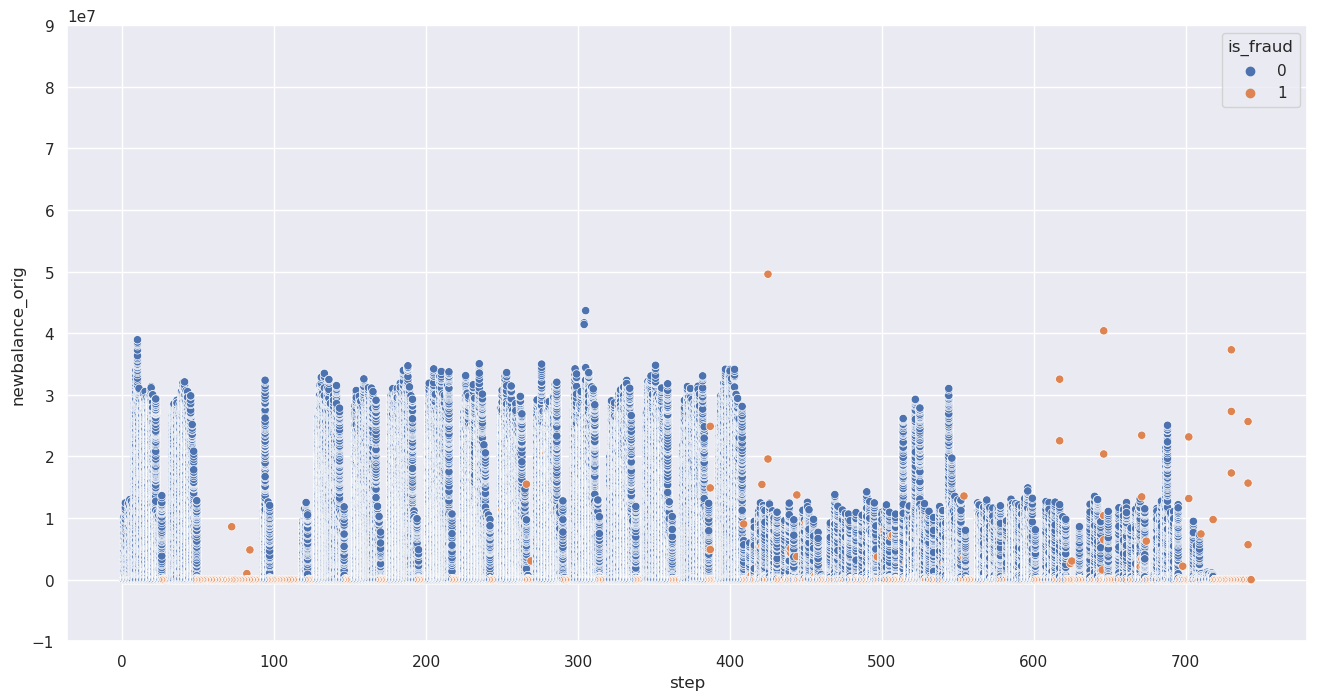

In [48]:
 # plot newbalance_orig scatter plot

# set up figure size
plt.subplots(figsize=(16,8))
sns.scatterplot(x='step', y='newbalance_orig', hue='is_fraud', data=num_attr)

# set y-axis labels
plt.yticks(np.arange(-1.e+07, 1.e+08, step=1.e+07));

<AxesSubplot:xlabel='newbalance_orig'>

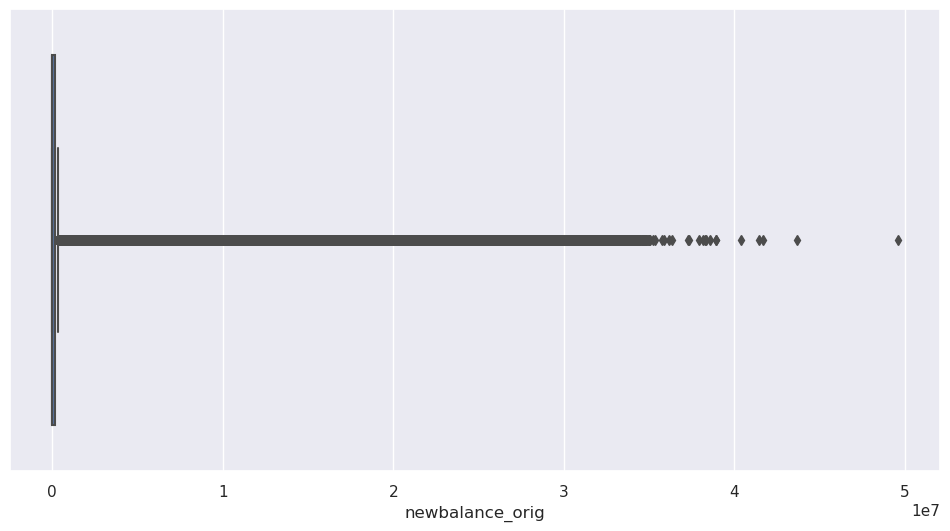

In [49]:
 # newbalance_orig boxplot
plt.subplots(figsize=(12,6))
sns.boxplot(num_attr['newbalance_orig'])

In [50]:
# check newbalance_orig value for fraudulent transactions
aux3 = df1[df1['is_fraud'] == 1]

# get the number of instances of newbalance_orig with value equal to zero
aux4 = aux3['newbalance_orig'].value_counts()[0]

# calculate the percentage of newbalance_orig with value equal to zero with respect to the total of frauds
newbal_per = np.round(((aux4 / len(aux3)) * 100), decimals=2)
newbal_per

98.11

 **Analisys:**
- The scatterplot shows that the majority of fraudulent transactions are placed in the newbalance_orig equal to zero.
- From all fraudulent transactions, 98.11% have newbalance_orig value equal to zero.

#### 1.3.1.4. oldbalance_dest feature analysis

<AxesSubplot:xlabel='step', ylabel='oldbalance_dest'>

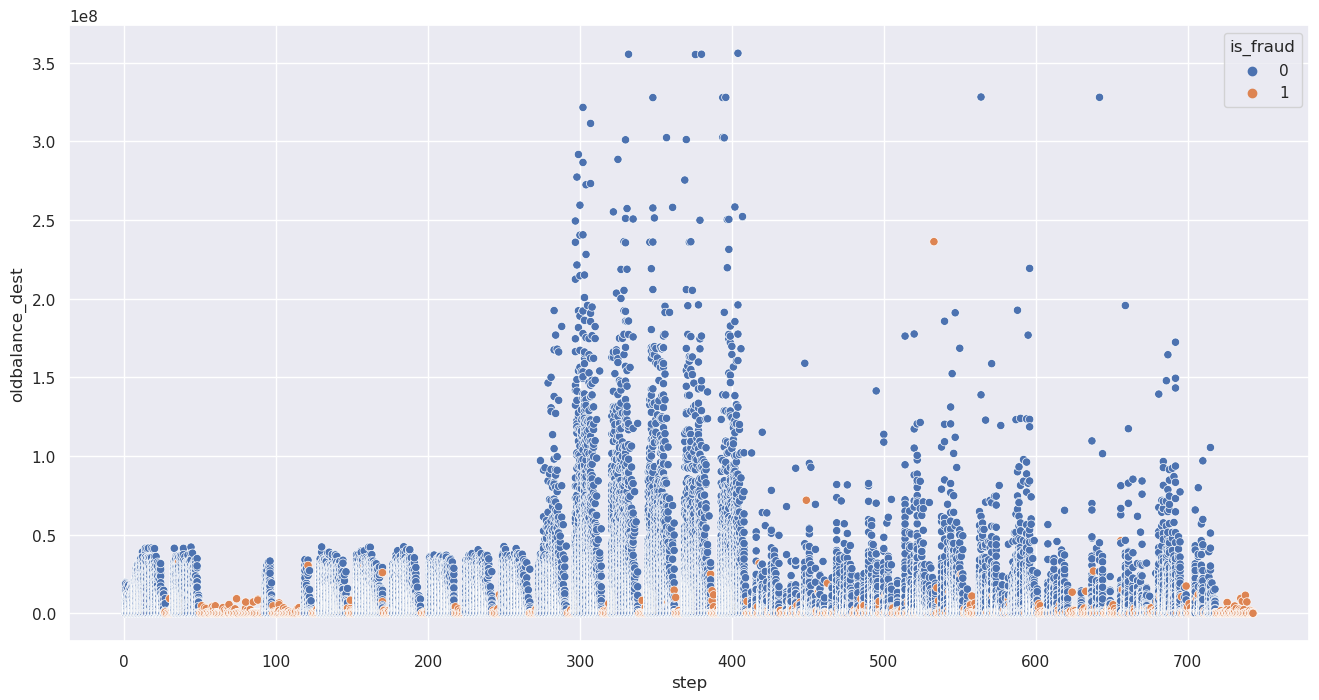

In [51]:
 # plot oldbalance_dest scatter plot

# set up figure size
plt.subplots(figsize=(16,8))
sns.scatterplot(x='step', y='oldbalance_dest', hue='is_fraud', data=num_attr)

<AxesSubplot:xlabel='oldbalance_dest'>

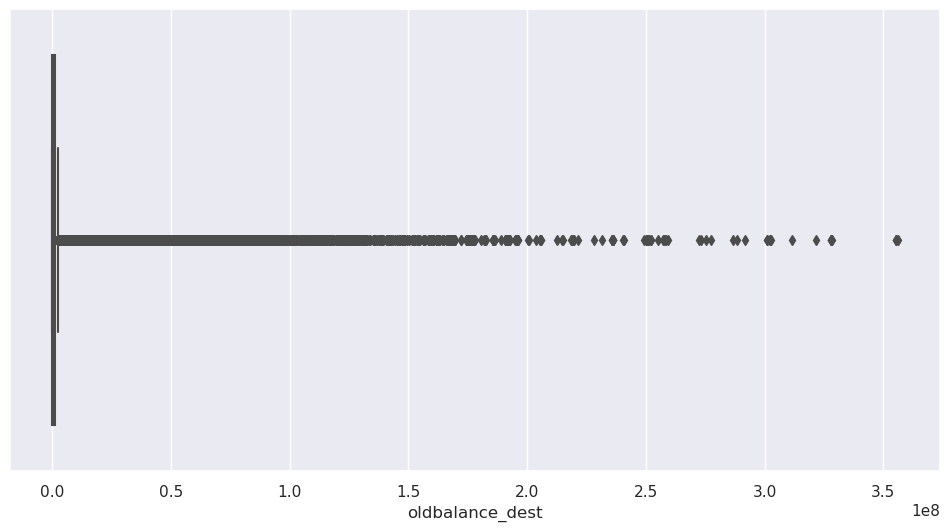

In [52]:
 # oldbalance_dest boxplot
plt.subplots(figsize=(12,6))
sns.boxplot(num_attr['oldbalance_dest'])

In [53]:
 # check oldbalance_dest value for fraudulent transactions
aux3 = df1[df1['is_fraud'] == 1]

# get the number of instances of oldbalance_dest with value equal to zero
aux5 = aux3['oldbalance_dest'].value_counts()[0]

# calculate the percentage of oldbalance_dest with value equal to zero with respect to the total of frauds
oldbal_per = np.round(((aux5 / len(aux3)) * 100), decimals=2)
oldbal_per

65.48

 **Analisys:**
- The scatterplot shows that the majority of fraudulent transactions are placed in the oldbalance_dest equal to zero.
- From all fraudulent transactions, 65.48% have oldbalance_dest value equal to zero.

#### 1.3.1.5. newbalance_dest feature analysis

<AxesSubplot:xlabel='step', ylabel='newbalance_dest'>

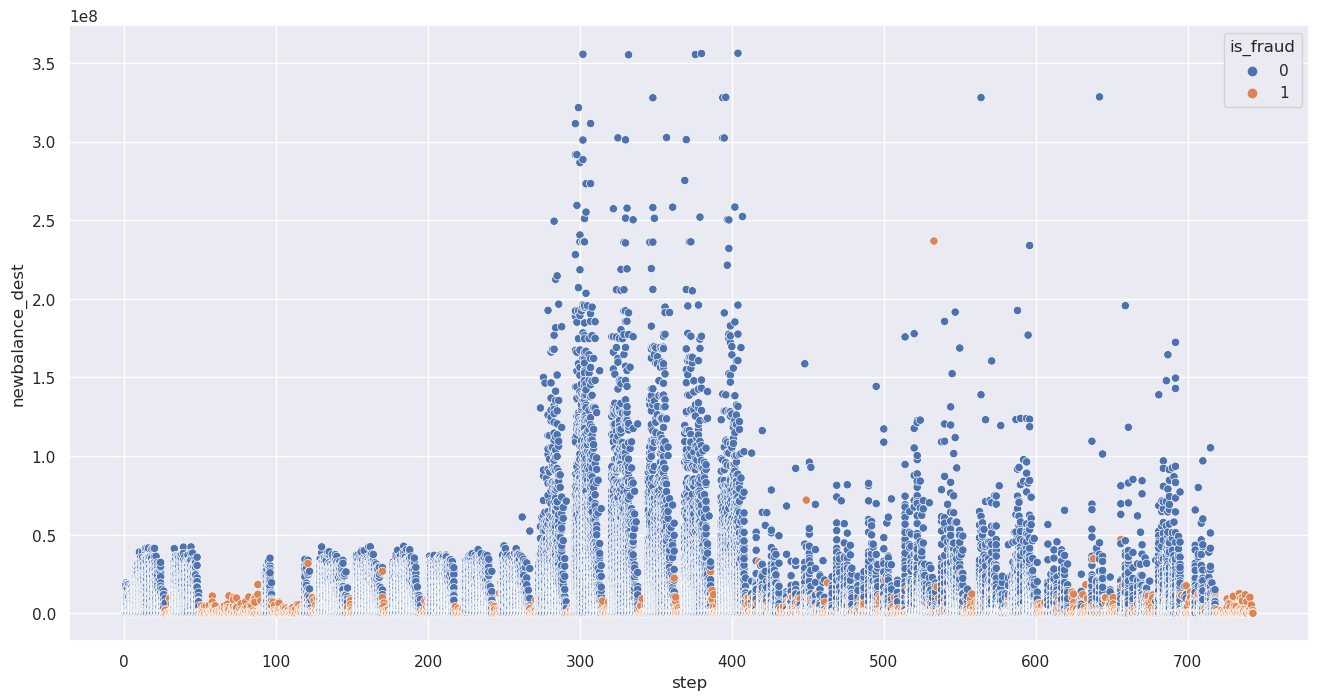

In [54]:
 # plot newbalance_dest scatter plot

# set up figure size
plt.subplots(figsize=(16,8))
sns.scatterplot(x='step', y='newbalance_dest', hue='is_fraud', data=num_attr)

<AxesSubplot:xlabel='newbalance_dest'>

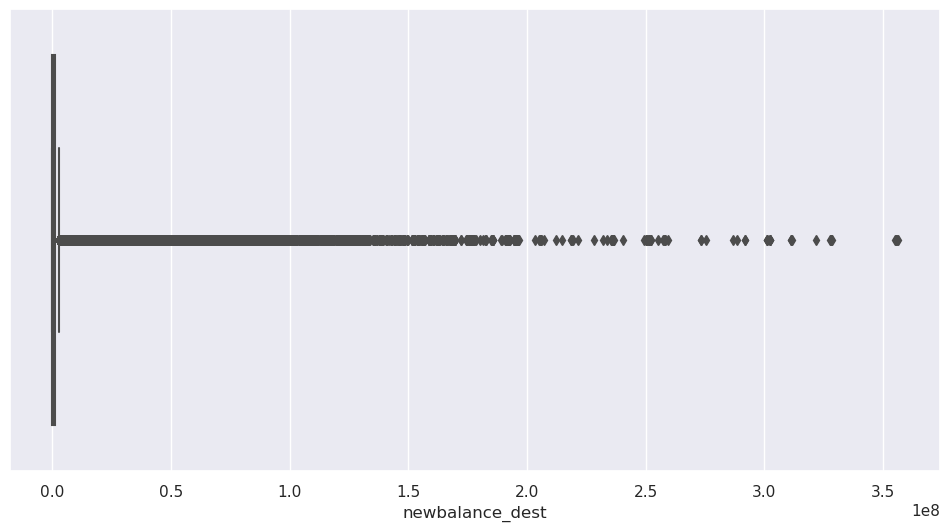

In [55]:
# newbalance_dest boxplot
plt.subplots(figsize=(12,6))
sns.boxplot(num_attr['newbalance_dest'])

In [56]:
 # check newbalance_dest value for fraudulent transactions

# get the number of instances of newbalance_dest with value equal to zero
aux6 = aux3['newbalance_dest'].value_counts()[0]

# calculate the percentage of newbalance_dest with value equal to zero with respect to the total of frauds
newbal_per = np.round(((aux6 / len(aux3)) * 100), decimals=2)
newbal_per

49.75

 **Analisys:**
- The scatterplot shows that most of fraudulent transactions are placed in the newbalance_dest equal to zero.
- From all fraudulent transactions, 49.75% have newbalance_dest value equal to zero.

## 1.3.2. Categorical Attributes

In [57]:
# select categorical attributes
cat_attr = df1.select_dtypes(exclude=['int16', 'float64'])

In [58]:
cat_attr.describe() 

type    name_orig   name_dest
count    4453587      4453587     4453587
unique         5      4448972     2035197
top     CASH_OUT  C1677795071  C985934102
freq     1565597            3          86

In [59]:
# Check unique entries of categorical attributes
cat_attr.apply( lambda x: x.unique().shape[0] )

type               5
name_orig    4448972
name_dest    2035197
dtype: int64

In [60]:
# check type feature
type_counts = cat_attr['type'].value_counts()
type_counts

CASH_OUT    1565597
PAYMENT     1506744
CASH_IN      979072
TRANSFER     373080
DEBIT         29094
Name: type, dtype: int64

In [61]:
 # create type feature percentage dataframe
# list of values and names from type_counts
value_list = []
name_list = []
for i in range(len(type_counts)):
    percent = np.round(((type_counts[i] / len(cat_attr)) * 100), decimals=2)
    value_list.append(percent)
    name_list.append(type_counts.index[i])

# create dataframe
type_df = pd.DataFrame({'percentage_%': value_list}, index=name_list)
type_df

percentage_%
CASH_OUT        35.150
PAYMENT         33.830
CASH_IN         21.980
TRANSFER         8.380
DEBIT            0.650

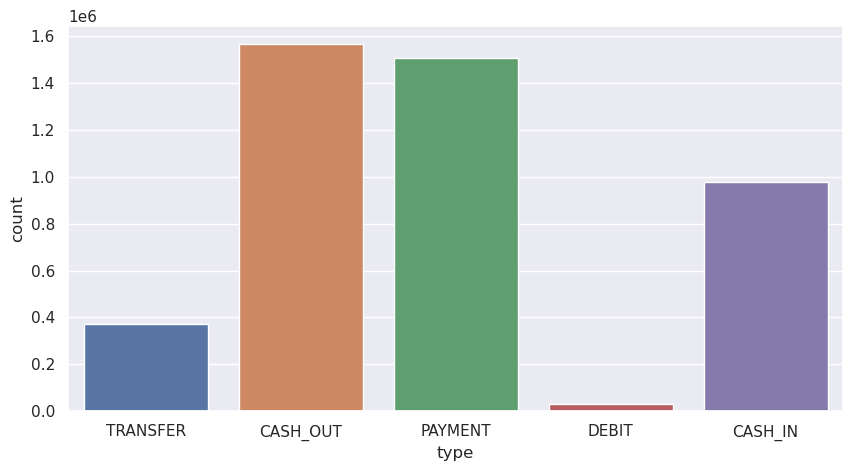

In [62]:
# plot type feature
plt.subplots(figsize=(10,5))
sns.countplot(x='type', data=cat_attr);

<AxesSubplot:xlabel='type', ylabel='amount'>

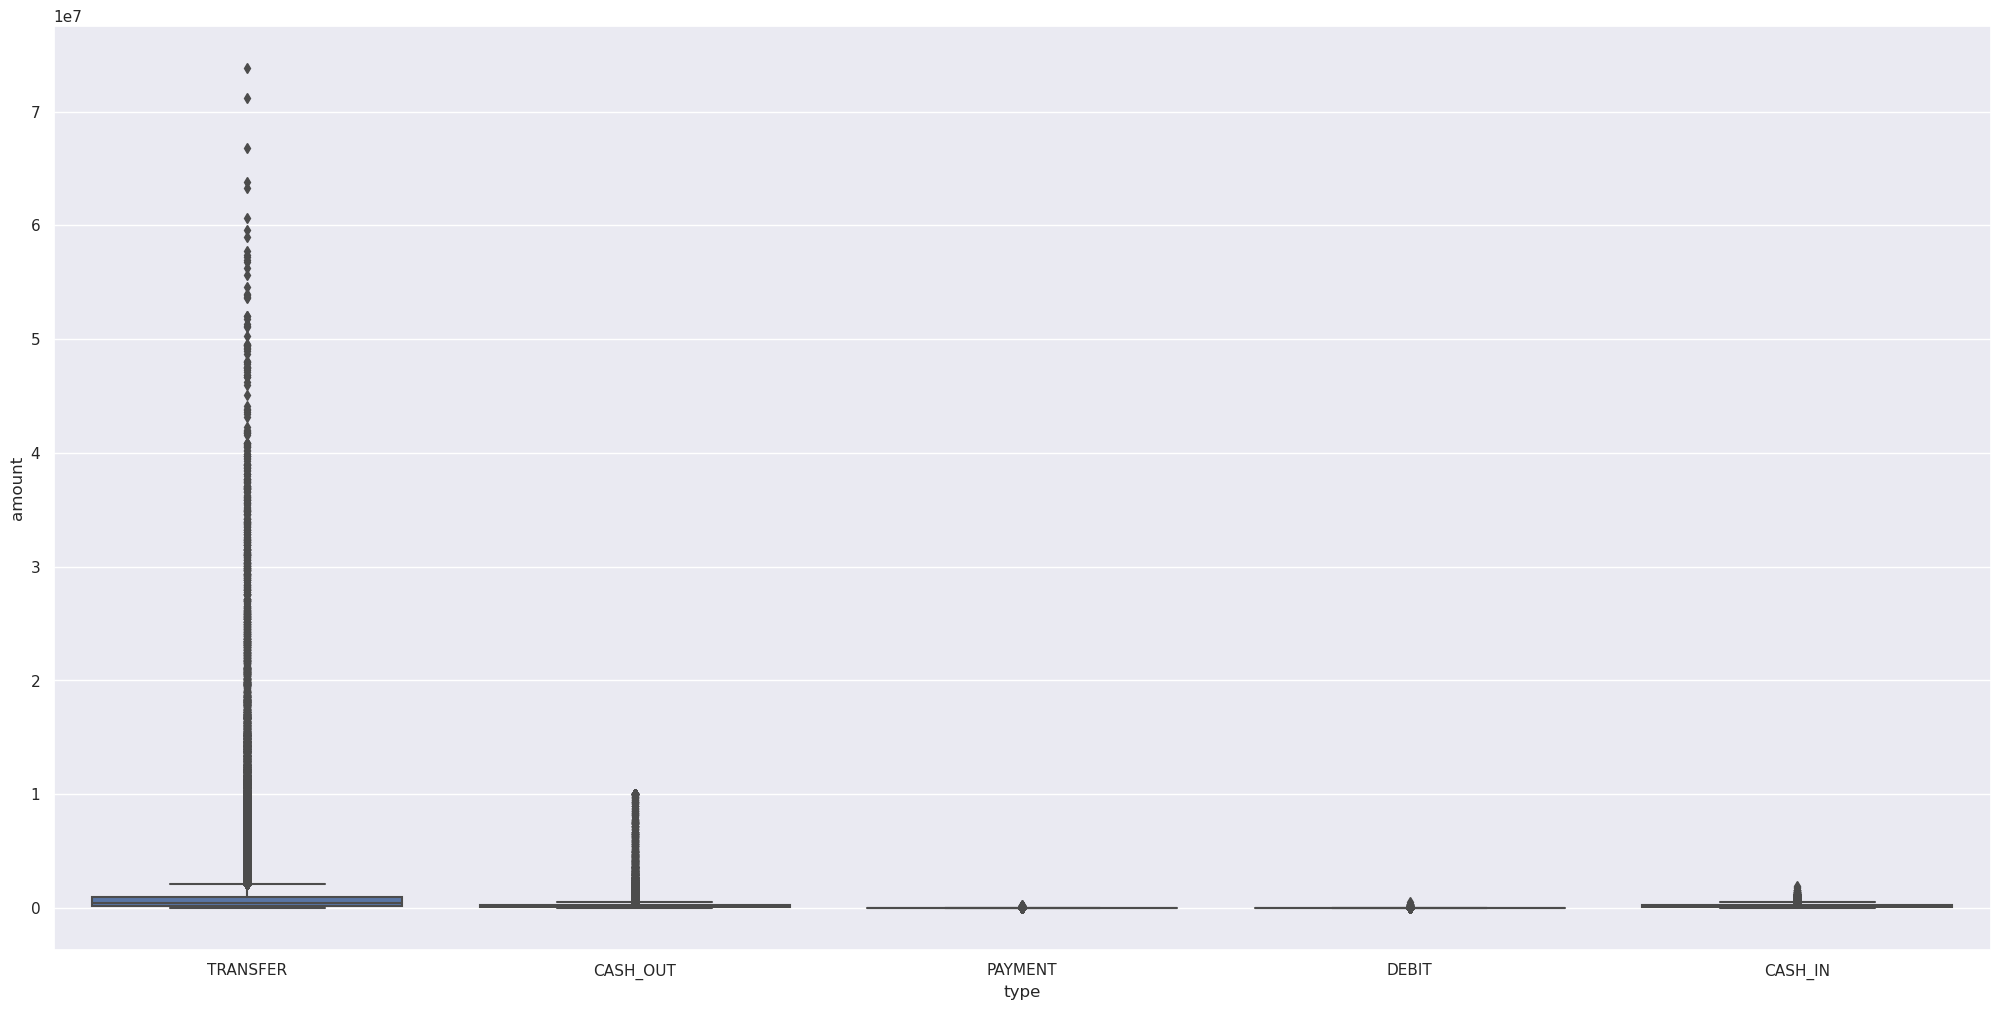

In [63]:
sns.boxplot(x='type', y='amount', data=df1) 

- Although the boxplot has not a good resolution due to amount values, it shows that transfer type has the biggest range of amounts.

In [64]:
cat_attr['name_dest'].value_counts() 

C985934102     86
C1286084959    78
C665576141     74
C1789550256    74
C1590550415    72
               ..
M730141676      1
M1843464772     1
C1278993047     1
M208334503      1
C2080388513     1
Name: name_dest, Length: 2035197, dtype: int64

- Some recipient of transaction participate on transaction more than 86 times.

In [65]:
cat_attr['name_orig'].value_counts() 

C1677795071    3
C1976208114    3
C363736674     3
C1065307291    3
C1784010646    3
              ..
C280084872     1
C884044387     1
C1452248792    1
C1560452043    1
C1685995037    1
Name: name_orig, Length: 4448972, dtype: int64

- Some customers made transactions more than once.

## 1.4. Data Description Summary

 **Data Description Summary:**
        **1. Balances**
- **None of the balances have negative numbers.**
- The intial balance before the transaction (oldbalance_org) ranges from 0 to aprox. 59 Million. Mean = 834,757. **25% of the observations are equal to zero**. 75% of the observations are up to the value of 107,429.
- The new balance after the transaction (newbalance_orig) ranges from 0 to more than 49 Million. Mean = 855,975. **50% of the observations are equal to zero**. 75% of the observations are up to the value of 144,412.
- The initial balance recipient before the transaction (oldbalance_dest) **ranges from 0 to more than 356 Million**. Mean = 1,100,704. 25% of the observations are equal to zero. 75% of the observations are up to the value of 943,372.
- The new balance recipient after the transaction (newbalance_dest) **ranges from zero to more than 356 Million**. Mean = 1,225,085. 25% of the observations are equal to zero - it can be either from merchant or from fraudulent agent behaviour (cashing out of the system). 75% of the observations are up to the value of 1,112,270.

**2. Transaction Amount**
- Transaction amount ranges from 0 to more than 92 Million, Mean = 179,939. **The minimum value is equal to zero.**
- **The maximum amount value (aprox. 92 Million) is greater than the maximum value of the initial balance before the transaction (aprox. 59 Million).**
- Between steps 50 and 75 seems that there are few / not transactions;
- After step 400 the frequency of transactions decreases significantly.
- **Fraudulent transaction amounts are up to the value of 10 million. There is not fraud transaction above 10 million.**
- 11 instances have amount transaction equal to zero, all of them with cash out type and labeled as fraud.
- There are instances with amount higher than oldbalance_org.

**3. fraud label**
- Only 0.13% of the observations are labeled as fraud

**From all fraudulent transactions:**
- **97.91% have newbalance_orig value equal to zero.**
- **65.19% have oldbalance_dest value equal to zero.**
- **49.9% have newbalance_dest value equal to zero.**

**4. is_flagged_fraud label**
- 14 instances are labeled as is_flagged_fraud. That represents only 0.03% of the instances.

**5. Type feature**
- 68% of the transactions are cash out and payment types.
- Almost 22% of transactions are cash in type, 8% are transfer type and only 0.65% are debit type.
- The transfer type has the biggest transaction amount range.

**6. Name_dest, name_orig features**
- Some recipient of transaction participate on transaction more than 80 times.
- Some customers made transactions more than once.

# 2.0. Feature Engineering

## 2.2. Hypothesis Creation


###  2.2.1. Transaction Amount


 1. Fraud should occur with high transaction amount. 


### 2.2.2. Transaction Type

 - Fraud should occur with cash out transaction type

### 2.2.3. Origin Balance


 1. Fraud should not occur when the origin balance before the transaction is equal to zero.
 2. Fraud should occur when origin balance after the transaction is equal to zero.
 3. Fraud should occur when the origin balance difference before and after the transaction is different from the transaction amount.

###   2.2.4. Recipient Balance


 1. Fraud should occur when the recipient balance after the transaction is equal to zero.
 2. Fraud should occur when the recipient balance difference before and after the transaction is different from the transaction amount.
 3. Fraud should not occur when the recipient balance difference before and after the transaction is equal to the origin difference before and after the transaction and equal to the transaction amount. 

### 2.2.5. Customer


1. Fraud should occur for merchant customer as recipient.
2. Fraud should occur for customers that receive the transaction with more frequency. 

###  2.2.6. Time


1. Fraud should occur for transactions made before day 15.

### 2.2.7. is_flagged_fraud

 1. Fraud should occur when is_flagged_fraud is equal to one when transaction amount is higher than 200,000. 

## 2.3. Final Hypothesis List (Based on the data available in the dataset)


 1. Fraud should occur with high transaction amount.
 2. Fraud should occur with cash out transaction type.
 3. Fraud should not occur when the origin balance before the transaction is equal to zero.
 4. Fraud should occur when origin balance after the transaction is equal to zero.
 5. Fraud should occur when the origin balance difference before and after the transaction is different from the transaction amount.
 6. Fraud should occur when the recipient balance after the transaction is equal to zero in more than 70% of the fraudulent transactions.
 7. Fraud should occur when the recipient balance difference before and after the transaction is different from the transaction amount.
 8. Fraud should not occur when the recipient balance difference before and after the transaction is equal to the origin difference before and after the transaction.
 9. Fraud should occur for merchant customer as recipient.
 10. Fraud should occur for customers that receive the transaction with more frequency.
 11. Fraud should occur for transactions made before day 15. 

## 2.4. Feature Engineering

- As previously checked in the data description, **some amount transactions are higher than the origin banlance before the transaction. Also, there are amount instances equal to zero.Theoretically, the difference between the origin balance before and after the transaction should be equal to the transaction amount**. Therefore, a new feature will be created to check this.
- The same is true for the destination balance: **theoretically, the difference between the destination balance after and before the transaction should be equal to the transaction amount**. Therefore, a new feature will be created to check this.
- As stated above in the features description, the balance destination information for merchant customers is not available. Therefore, a new feature will be created to differentiate such customers to the ordinary ones.
- A new time feature can be created based on the step information to determine the day in which the transactions happened, in order to ease the analysis.

In [66]:
 # open previously saved training set
df2 = df1.copy()
df2.head()

step      type   amount    name_orig  oldbalance_org  newbalance_orig  \
0     1  TRANSFER  181.000  C1305486145         181.000            0.000   
1     1  CASH_OUT  181.000   C840083671         181.000            0.000   
2     1   PAYMENT 7817.710    C90045638       53860.000        46042.290   
3     1   PAYMENT 7107.770   C154988899      183195.000       176087.230   
4     1   PAYMENT 7861.640  C1912850431      176087.230       168225.590   

    name_dest  oldbalance_dest  newbalance_dest  is_fraud  is_flagged_fraud  
0  C553264065            0.000            0.000         1                 0  
1   C38997010        21182.000            0.000         1                 0  
2  M573487274            0.000            0.000         0                 0  
3  M408069119            0.000            0.000         0                 0  
4  M633326333            0.000            0.000         0                 0

- As previously checked in the data description, **some amount transactions are higher than the origin banlance before the transaction. Also, there are amount instances equal to zero.Theoretically, the difference between the origin balance before and after the transaction should be equal to the transaction amount.** Therefore, a new feature will be created to check this.

- The same is true for the destination balance: **theoretically, the difference between the destination balance after and before the transaction should be equal to the transaction amount.** Therefore, a new feature will be created to check this.

- As stated above in the features description, the balance destination information for merchant customers is not available. Therefore, a new feature will be created to differentiate such customers to the ordinary ones.

- A new time feature can be created based on the step information to determine the day in which the transactions happened, in order to ease the analysis.

In [67]:
 # create origin balance difference feature
df2['diff_orig'] = df2['oldbalance_org'] - df2['amount'] - df2['newbalance_orig']

# create destination balance difference feature
df2['diff_dest'] = df2['oldbalance_dest'] + df2['amount'] - df2['newbalance_dest']

In [68]:
df2.head()

step      type   amount    name_orig  oldbalance_org  newbalance_orig  \
0     1  TRANSFER  181.000  C1305486145         181.000            0.000   
1     1  CASH_OUT  181.000   C840083671         181.000            0.000   
2     1   PAYMENT 7817.710    C90045638       53860.000        46042.290   
3     1   PAYMENT 7107.770   C154988899      183195.000       176087.230   
4     1   PAYMENT 7861.640  C1912850431      176087.230       168225.590   

    name_dest  oldbalance_dest  newbalance_dest  is_fraud  is_flagged_fraud  \
0  C553264065            0.000            0.000         1                 0   
1   C38997010        21182.000            0.000         1                 0   
2  M573487274            0.000            0.000         0                 0   
3  M408069119            0.000            0.000         0                 0   
4  M633326333            0.000            0.000         0                 0   

   diff_orig  diff_dest  
0      0.000    181.000  
1      0.000  21363.000  
2      0.000   7817.710  
3      0.000   7107.770  
4      0.000   7861.640

In [69]:
# check if name_orig has merchant customer
df2['name_orig'].str.contains('M').sum()

0

In [70]:
 # check merchant customer on name_dest
df2['name_dest'].str.contains('M').sum()

1506744

- name_orig does not have merchant customer. Therefore, it is not necessary to create a new feature;
- name_dest has 430,261 instances with merchant customer. Therefore, a new feature will be created.

In [71]:
# create merchant_dest feature
df2['merchant_dest'] = df2.apply(lambda x: 1 if 'M' in x['name_dest'] else 0, axis=1)
df2.head()

step      type   amount    name_orig  oldbalance_org  newbalance_orig  \
0     1  TRANSFER  181.000  C1305486145         181.000            0.000   
1     1  CASH_OUT  181.000   C840083671         181.000            0.000   
2     1   PAYMENT 7817.710    C90045638       53860.000        46042.290   
3     1   PAYMENT 7107.770   C154988899      183195.000       176087.230   
4     1   PAYMENT 7861.640  C1912850431      176087.230       168225.590   

    name_dest  oldbalance_dest  newbalance_dest  is_fraud  is_flagged_fraud  \
0  C553264065            0.000            0.000         1                 0   
1   C38997010        21182.000            0.000         1                 0   
2  M573487274            0.000            0.000         0                 0   
3  M408069119            0.000            0.000         0                 0   
4  M633326333            0.000            0.000         0                 0   

   diff_orig  diff_dest  merchant_dest  
0      0.000    181.000              0  
1      0.000  21363.000              0  
2      0.000   7817.710              1  
3      0.000   7107.770              1  
4      0.000   7861.640              1

In [72]:
 # create day feature
df2['day'] = df2.apply(lambda x: (np.ceil(x['step'] / 24)).astype(int), axis=1)
df2.head()

step      type   amount    name_orig  oldbalance_org  newbalance_orig  \
0     1  TRANSFER  181.000  C1305486145         181.000            0.000   
1     1  CASH_OUT  181.000   C840083671         181.000            0.000   
2     1   PAYMENT 7817.710    C90045638       53860.000        46042.290   
3     1   PAYMENT 7107.770   C154988899      183195.000       176087.230   
4     1   PAYMENT 7861.640  C1912850431      176087.230       168225.590   

    name_dest  oldbalance_dest  newbalance_dest  is_fraud  is_flagged_fraud  \
0  C553264065            0.000            0.000         1                 0   
1   C38997010        21182.000            0.000         1                 0   
2  M573487274            0.000            0.000         0                 0   
3  M408069119            0.000            0.000         0                 0   
4  M633326333            0.000            0.000         0                 0   

   diff_orig  diff_dest  merchant_dest  day  
0      0.000    181.000              0    1  
1      0.000  21363.000              0    1  
2      0.000   7817.710              1    1  
3      0.000   7107.770              1    1  
4      0.000   7861.640              1    1

In [73]:
df2.tail()

step      type      amount    name_orig  oldbalance_org  \
4453582   743  TRANSFER 1258818.820  C1531301470     1258818.820   
4453583   743  CASH_OUT 1258818.820  C1436118706     1258818.820   
4453584   743  CASH_OUT  339682.130   C786484425      339682.130   
4453585   743  TRANSFER 6311409.280  C1529008245     6311409.280   
4453586   743  TRANSFER  850002.520  C1685995037      850002.520   

         newbalance_orig    name_dest  oldbalance_dest  newbalance_dest  \
4453582            0.000  C1470998563            0.000            0.000   
4453583            0.000  C1240760502       503464.500      1762283.330   
4453584            0.000   C776919290            0.000       339682.130   
4453585            0.000  C1881841831            0.000            0.000   
4453586            0.000  C2080388513            0.000            0.000   

         is_fraud  is_flagged_fraud  diff_orig   diff_dest  merchant_dest  day  
4453582         1                 0      0.000 1258818.820              0   31  
4453583         1                 0      0.000      -0.010              0   31  
4453584         1                 0      0.000       0.000              0   31  
4453585         1                 0      0.000 6311409.280              0   31  
4453586         1                 0      0.000  850002.520              0   31

In [74]:
# df2 columns
df2.columns

Index(['step', 'type', 'amount', 'name_orig', 'oldbalance_org',
       'newbalance_orig', 'name_dest', 'oldbalance_dest', 'newbalance_dest',
       'is_fraud', 'is_flagged_fraud', 'diff_orig', 'diff_dest',
       'merchant_dest', 'day'],
      dtype='object')

In [75]:
 # reorder columns
df2 = df2[['step', 'day', 'type', 'name_orig', 'amount', 'oldbalance_org',
       'newbalance_orig', 'diff_orig', 'name_dest', 'merchant_dest', 
       'oldbalance_dest', 'newbalance_dest', 'diff_dest',
       'is_fraud', 'is_flagged_fraud']]

df2.tail()

step  day      type    name_orig      amount  oldbalance_org  \
4453582   743   31  TRANSFER  C1531301470 1258818.820     1258818.820   
4453583   743   31  CASH_OUT  C1436118706 1258818.820     1258818.820   
4453584   743   31  CASH_OUT   C786484425  339682.130      339682.130   
4453585   743   31  TRANSFER  C1529008245 6311409.280     6311409.280   
4453586   743   31  TRANSFER  C1685995037  850002.520      850002.520   

         newbalance_orig  diff_orig    name_dest  merchant_dest  \
4453582            0.000      0.000  C1470998563              0   
4453583            0.000      0.000  C1240760502              0   
4453584            0.000      0.000   C776919290              0   
4453585            0.000      0.000  C1881841831              0   
4453586            0.000      0.000  C2080388513              0   

         oldbalance_dest  newbalance_dest   diff_dest  is_fraud  \
4453582            0.000            0.000 1258818.820         1   
4453583       503464.500      1762283.330      -0.010         1   
4453584            0.000       339682.130       0.000         1   
4453585            0.000            0.000 6311409.280         1   
4453586            0.000            0.000  850002.520         1   

         is_flagged_fraud  
4453582                 0  
4453583                 0  
4453584                 0  
4453585                 0  
4453586                 0

# 3.0. Variables Filtering

In [76]:
df3 = df2.copy()

## 3.1. Lines Filtering

In [77]:
# Remove outliers from amount feature
df3 = df3[df3['amount'] < 20e6]
df3.shape

# Remove oldbalance_dest outliers
df3 = df3[df3['oldbalance_dest'] < 5e7]
df3.shape

# Remove newbalance_dest outliers
df3 = df3[df3['newbalance_dest'] < 5e7]

## 3.2. Save training set

In [78]:
 # save train set for future notebook work
df3.to_csv('../data/processed/df3_v02.csv', index=False)

# 4.0. EDA - Exploratory Data Analysis

<img src= "../data/external/hypotheses-map.png">

In [20]:
 # open previously saved training set
df4 = pd.read_csv('../data/processed/df3_v02.csv')

## 4.1. Univariate Analysis**

In [21]:
df4.sample(5)

step  day     type    name_orig     amount  oldbalance_org  \
3517608   353   15  PAYMENT   C397265928    5517.88            0.00   
3777739   377   16  CASH_IN  C1855694751  160515.08        31521.00   
1945664   214    9  CASH_IN   C406559591  106499.78      1160987.11   
32732       9    1  PAYMENT   C829174254    8689.97            0.00   
856867    133    6  PAYMENT  C1016670952   37471.87       472466.79   

         newbalance_orig  diff_orig    name_dest  merchant_dest  \
3517608             0.00   -5517.88  M1229373268              1   
3777739        192036.08 -321030.16   C782022519              0   
1945664       1267486.89 -212999.56  C1248588931              0   
32732               0.00   -8689.97  M1405857823              1   
856867         434994.92       0.00  M1992587538              1   

         oldbalance_dest  newbalance_dest  diff_dest  is_fraud  \
3517608             0.00             0.00    5517.88         0   
3777739             0.00             0.00  160515.08         0   
1945664        122649.35         16149.57  212999.56         0   
32732               0.00             0.00    8689.97         0   
856867              0.00             0.00   37471.87         0   

         is_flagged_fraud  
3517608                 0  
3777739                 0  
1945664                 0  
32732                   0  
856867                  0

### 4.1.1. Target Variable

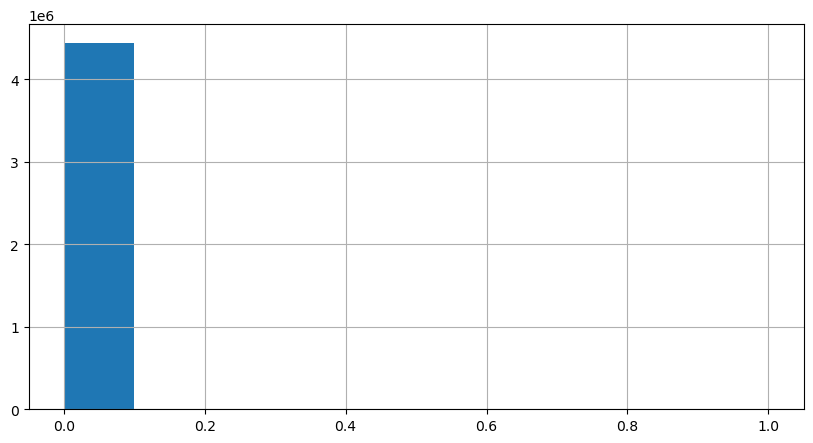

In [22]:
# plot target variable
df4['is_fraud'].hist(figsize=(10,5));

In [23]:
 # check is_fraud labels proportion
df4['is_fraud'].value_counts(normalize=True)

0    0.998718
1    0.001282
Name: is_fraud, dtype: float64

- The graph is not visually clear regarding is_fraud = 1 due to its low proportion (0.1%).
- The is_fraud feature is better visualized with respect to the other features. The graphs are shown below in the bivariate analysis.
 
- Plot fraudulent transactions per day

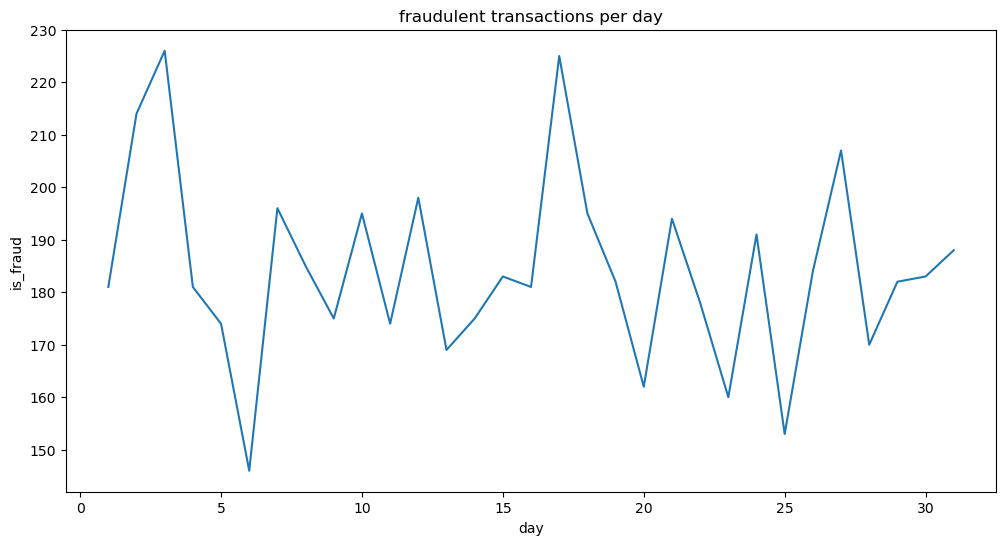

In [24]:
 # plot fraudulent transactions per day
aux1 = df4[['day', 'is_fraud']].groupby('day').sum().reset_index()

# set up figure size
plt.subplots(figsize=(12,6))
sns.lineplot(x='day', y='is_fraud', data=aux1).set_title('fraudulent transactions per day');

In [25]:
## sets plot size
#plt.figure(figsize=(18, 10))
#
## sets the inital plot position
#n = 1
#
## iterates over the columns to plot
#for column in cat_attr.columns:
#    plt.subplot(4, 3, n)
#    _ = sns.countplot(y=cat_attr[column])
#    plt.title("Count for " + column, fontsize=14)
#    n += 1
#
## adjust height and wdith reserved for space between subplots  
#plt.subplots_adjust(hspace=0.8)
#plt.subplots_adjust(wspace=0.3)
#
## display the plot
#plt.show()

## 4.1.2. Numerical Variable**

In [26]:
 # select numerical attributes
num_attr = df4.select_dtypes(include=['int64', 'float64'])
num_attr.head()

step  day   amount  oldbalance_org  newbalance_orig  diff_orig  \
0     1    1   181.00          181.00             0.00        0.0   
1     1    1   181.00          181.00             0.00        0.0   
2     1    1  7817.71        53860.00         46042.29        0.0   
3     1    1  7107.77       183195.00        176087.23        0.0   
4     1    1  7861.64       176087.23        168225.59        0.0   

   merchant_dest  oldbalance_dest  newbalance_dest  diff_dest  is_fraud  \
0              0              0.0              0.0     181.00         1   
1              0          21182.0              0.0   21363.00         1   
2              1              0.0              0.0    7817.71         0   
3              1              0.0              0.0    7107.77         0   
4              1              0.0              0.0    7861.64         0   

   is_flagged_fraud  
0                 0  
1                 0  
2                 0  
3                 0  
4                 0

In [27]:
# check num_attr describe
num_attr.describe()

step           day        amount  oldbalance_org  \
count  4.450646e+06  4.450646e+06  4.450646e+06    4.450646e+06   
mean   2.433029e+02  1.048797e+01  1.743889e+05    8.327751e+05   
std    1.423634e+02  5.923030e+00  4.608643e+05    2.885968e+06   
min    1.000000e+00  1.000000e+00  0.000000e+00    0.000000e+00   
25%    1.550000e+02  7.000000e+00  1.337087e+04    0.000000e+00   
50%    2.390000e+02  1.000000e+01  7.471716e+04    1.422600e+04   
75%    3.340000e+02  1.400000e+01  2.084891e+05    1.072408e+05   
max    7.430000e+02  3.100000e+01  1.997663e+07    5.958504e+07   

       newbalance_orig     diff_orig  merchant_dest  oldbalance_dest  \
count     4.450646e+06  4.450646e+06   4.450646e+06     4.450646e+06   
mean      8.540298e+05 -1.956436e+05   3.385450e-01     1.052213e+06   
std       2.921870e+06  4.652014e+05   4.732149e-01     2.581690e+06   
min       0.000000e+00 -1.997370e+07   0.000000e+00     0.000000e+00   
25%       0.000000e+00 -2.493540e+05   0.000000e+00     0.000000e+00   
50%       0.000000e+00 -6.850268e+04   0.000000e+00     1.318440e+05   
75%       1.441046e+05 -2.937785e+03   1.000000e+00     9.393702e+05   
max       4.958504e+07  1.000000e-02   1.000000e+00     4.996917e+07   

       newbalance_dest     diff_dest      is_fraud  is_flagged_fraud  
count     4.450646e+06  4.450646e+06  4.450646e+06      4.450646e+06  
mean      1.169425e+06  5.717659e+04  1.282286e-03      2.471551e-06  
std       2.757932e+06  3.679579e+05  3.578606e-02      1.572115e-03  
min       0.000000e+00 -4.236412e+07  0.000000e+00      0.000000e+00  
25%       0.000000e+00  0.000000e+00  0.000000e+00      0.000000e+00  
50%       2.136035e+05  3.517200e+03  0.000000e+00      0.000000e+00  
75%       1.107954e+06  2.936819e+04  0.000000e+00      0.000000e+00  
max       4.997115e+07  1.319123e+07  1.000000e+00      1.000000e+00

- **75% of diff_orig values are negative, which means that transactions amount are higher than the origin balance value.**
- This is awkward, since the theoretical diff_orig value should be zero. This must be checked in details in the bivariate analysis.
- The first quartile (25%) diff_dest is equal to zero, which means a correct transaction. However, the merchant destination balance values are equal to zero, therefore this must be checked in details in the bivariate analysis.
- **The majority of diff_dest values are higher than zero, which means that the amount transfered is higher than the new balance destination**. This must be checked in the bivariate analysis.

attributes          min          max        range          mean  \
0               step         1.00       743.00       742.00  2.433029e+02   
1                day         1.00        31.00        30.00  1.048797e+01   
2             amount         0.00  19976629.47  19976629.47  1.743889e+05   
3     oldbalance_org         0.00  59585040.37  59585040.37  8.327751e+05   
4    newbalance_orig         0.00  49585040.37  49585040.37  8.540298e+05   
5          diff_orig -19973695.61         0.01  19973695.62 -1.956436e+05   
6      merchant_dest         0.00         1.00         1.00  3.385450e-01   
7    oldbalance_dest         0.00  49969173.07  49969173.07  1.052213e+06   
8    newbalance_dest         0.00  49971149.67  49971149.67  1.169425e+06   
9          diff_dest -42364116.56  13191233.98  55555350.54  5.717659e+04   
10          is_fraud         0.00         1.00         1.00  1.282286e-03   
11  is_flagged_fraud         0.00         1.00         1.00  2.471551e-06   

        median           std        skew       kurtosis  
0      239.000  1.423633e+02    0.376000       0.328655  
1       10.000  5.923029e+00    0.378760       0.331975  
2    74717.160  4.608643e+05   14.955998     340.938350  
3    14226.000  2.885968e+06    5.250814      32.967250  
4        0.000  2.921869e+06    5.179042      32.084807  
5   -68502.675  4.652013e+05  -13.629178     309.563846  
6        0.000  4.732148e-01    0.682375      -1.534365  
7   131843.990  2.581690e+06    6.006281      55.719441  
8   213603.475  2.757932e+06    6.003705      55.548314  
9     3517.200  3.679579e+05  -35.380354    2429.583350  
10       0.000  3.578605e-02   27.872194     774.859524  
11       0.000  1.572115e-03  636.082899  404599.636362

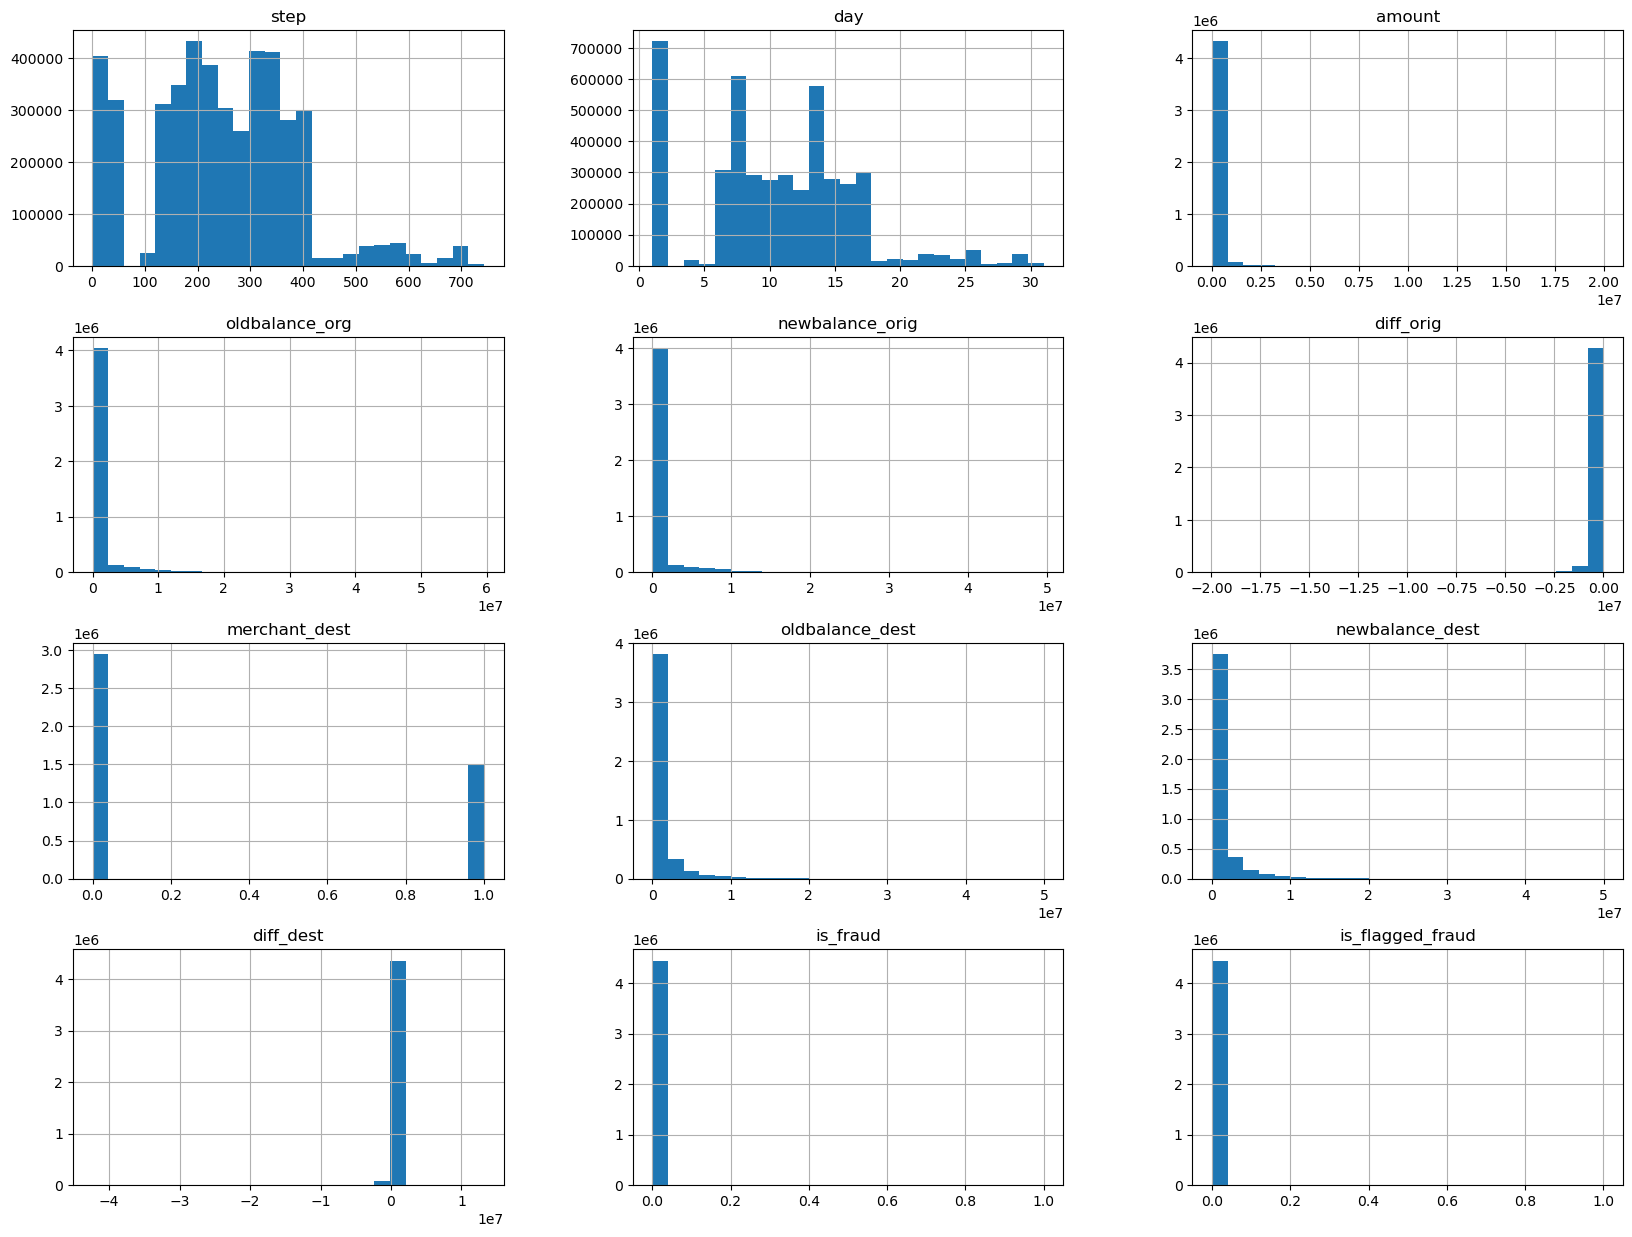

In [28]:
# check num_attr stats
num_stats(num_attr)

- The graphs are not visually clear due to the values range.
- Detailed distribution of the features that are unclear above are plotted below.

#### 4.1.2.1. amount Feature

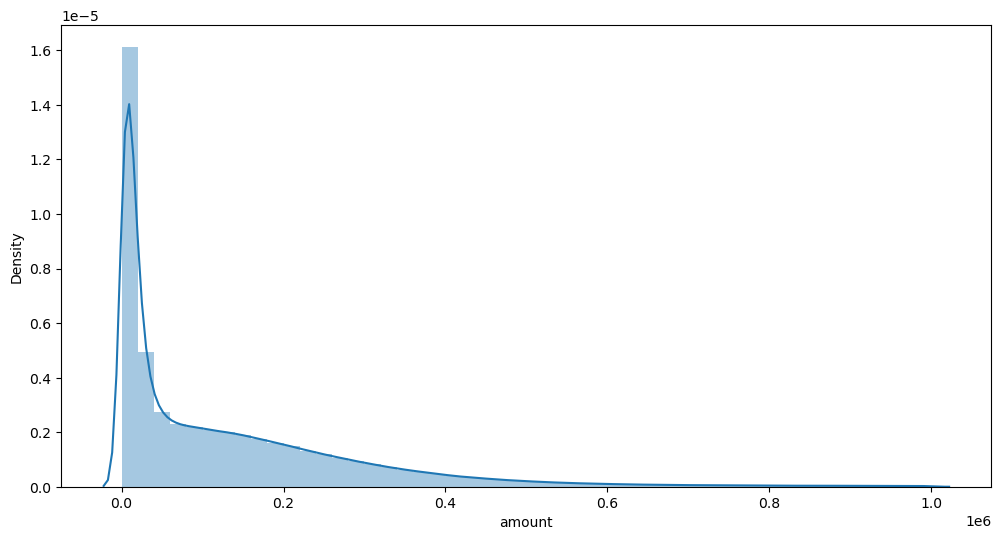

In [29]:
 # plot amount distribution values lower than 1,000,000

# set up figure size
plt.subplots(figsize=(12,6))
sns.distplot(df4[df4['amount'] < 1e6]['amount']);

<AxesSubplot:xlabel='amount'>

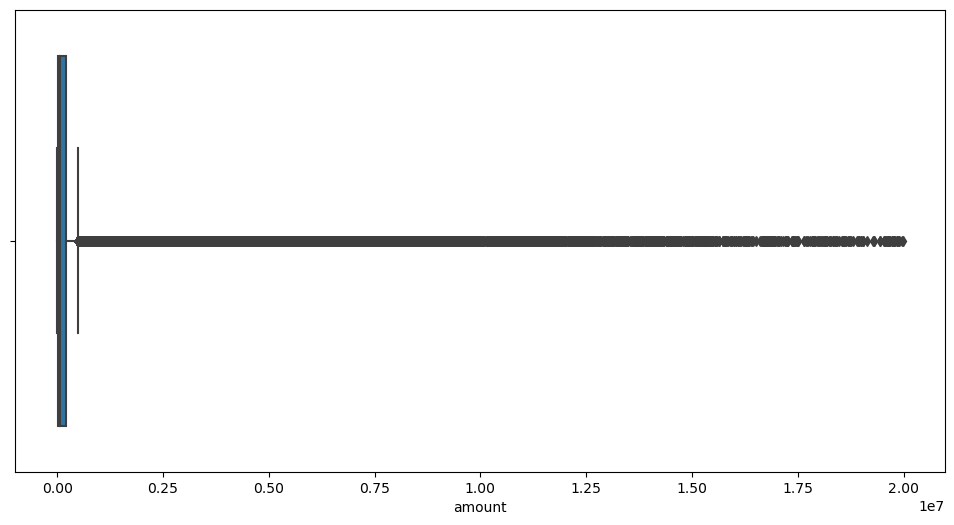

In [30]:
# amount boxplot
plt.subplots(figsize=(12,6))
sns.boxplot(df4['amount'])

### 4.1.2.2. oldbalance_org feature

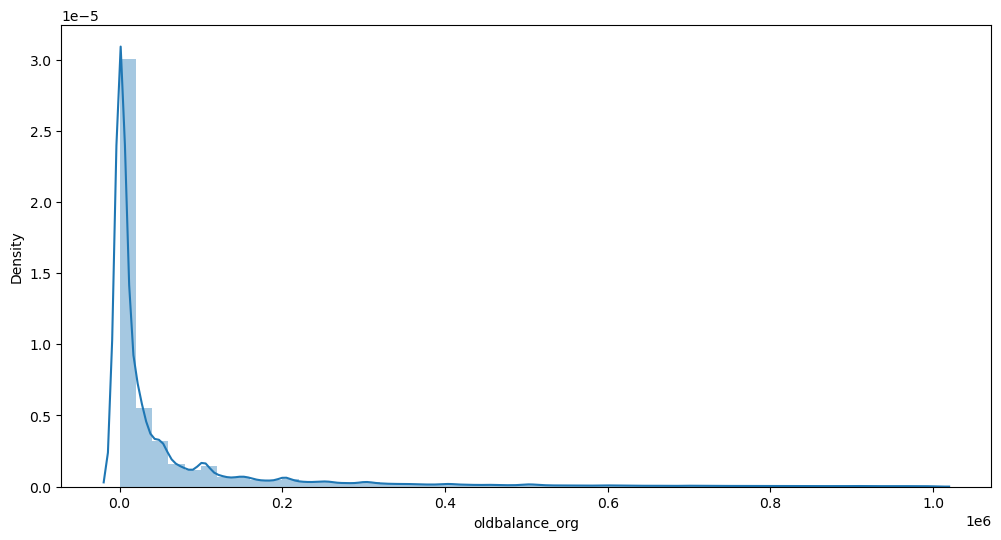

In [31]:
 # oldbalance_org distribution lower than 1,000,000

# set up figure size
plt.subplots(figsize=(12,6))
sns.distplot(df4[df4['oldbalance_org'] < 1e6]['oldbalance_org']);

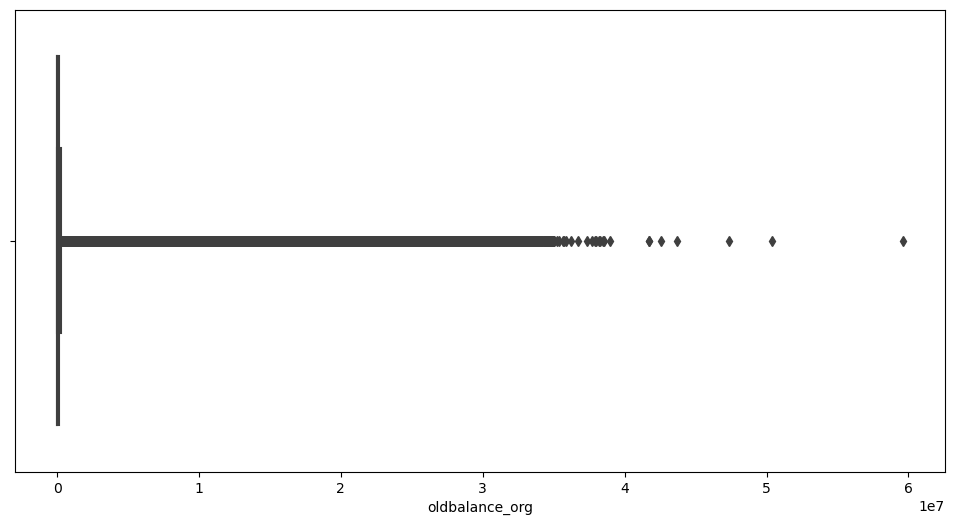

In [32]:
 # oldbalance_org boxplot
plt.subplots(figsize=(12,6))
sns.boxplot(df4['oldbalance_org']);

### 4.1.2.3. newbalance_org feature

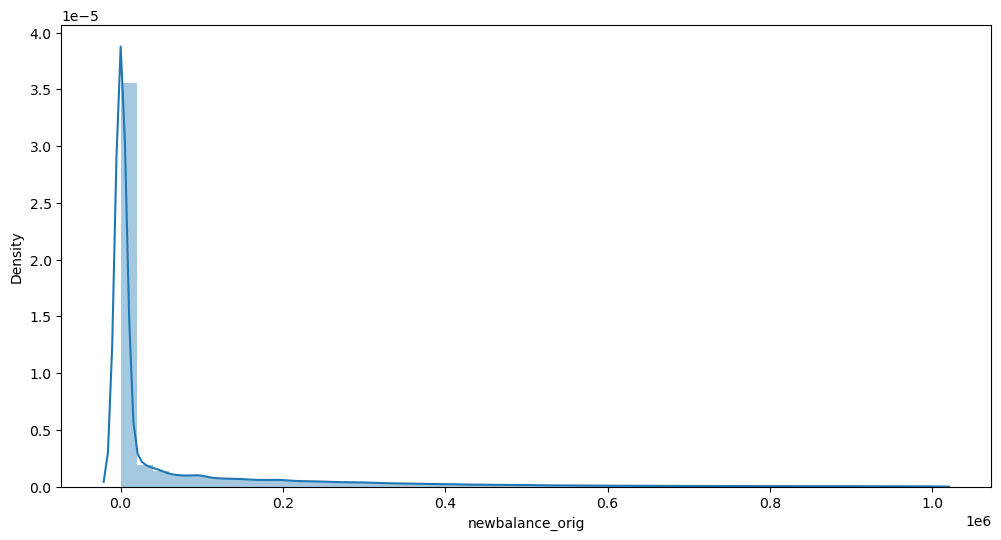

In [33]:
 # newbalance_orig distribution values lower than 1,000,000

# set up figure size
plt.subplots(figsize=(12,6))
sns.distplot(df4[df4['newbalance_orig'] < 1e6]['newbalance_orig']);

### 4.1.2.4. diff_orig feature**

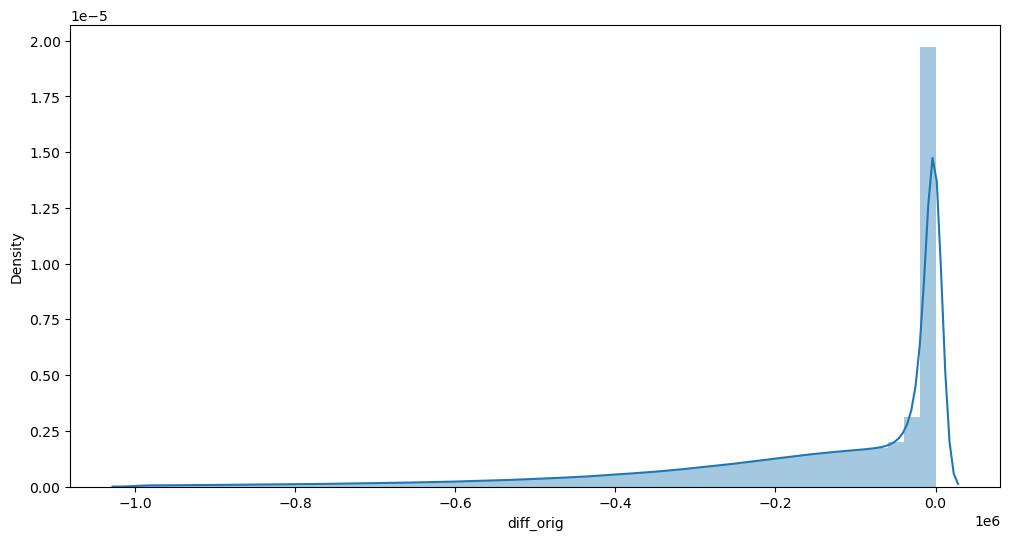

In [34]:
# diff_orig distribution values greater than -1,000,000

# set up figure size
plt.subplots(figsize=(12,6))
sns.distplot(df4[df4['diff_orig'] > -1e6]['diff_orig']);

<AxesSubplot:xlabel='step', ylabel='diff_orig'>

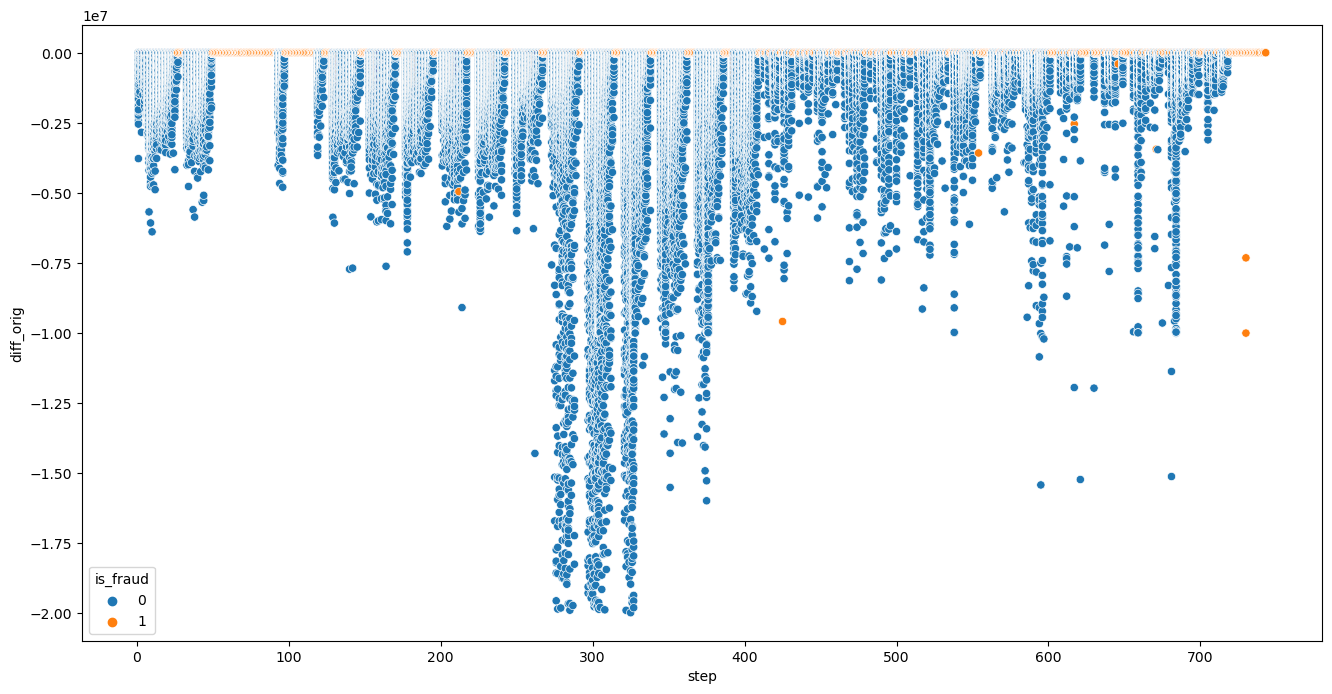

In [35]:
 # set up figure size
plt.subplots(figsize=(16,8))
# plot diff_orig scatterplot
sns.scatterplot(x='step', y='diff_orig', hue='is_fraud', data=num_attr)

- diff_orig values labeled as fraudulent are placed in line zero.

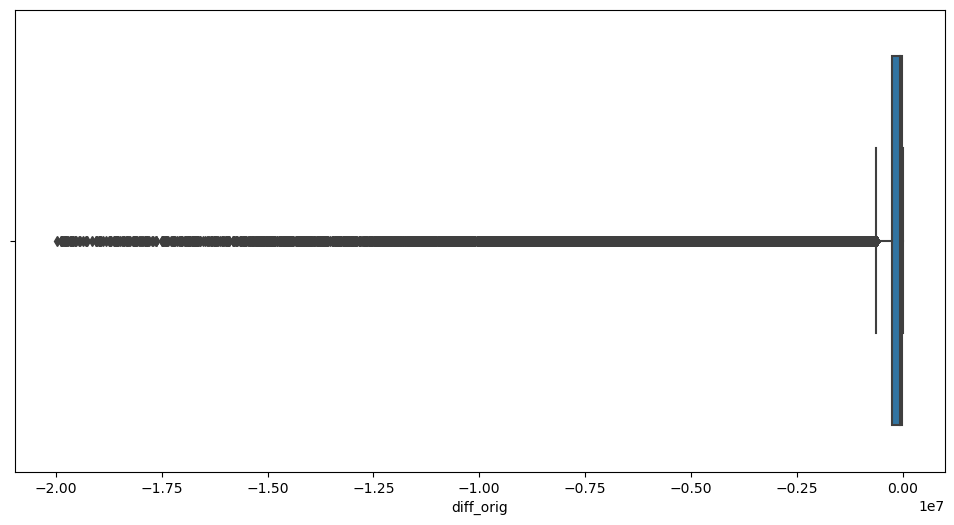

In [36]:
 # diff_orig boxplot
plt.subplots(figsize=(12,6))
sns.boxplot(df4['diff_orig']);

In [37]:
df4['diff_orig'].value_counts(normalize=True) 

 0.000000e+00    1.491970e-01
-1.000000e-02    3.970435e-03
 1.000000e-02    3.898535e-03
 7.275958e-12    2.904972e-03
-7.275958e-12    2.902500e-03
                     ...     
-6.716390e+03    2.246865e-07
-2.527500e+03    2.246865e-07
-1.851115e+05    2.246865e-07
-3.571641e+05    2.246865e-07
-7.316255e+06    2.246865e-07
Name: diff_orig, Length: 3343562, dtype: float64

- 14.9% of diff_orig values are equal to zero.

### 4.1.2.5. oldbalance_dest feature

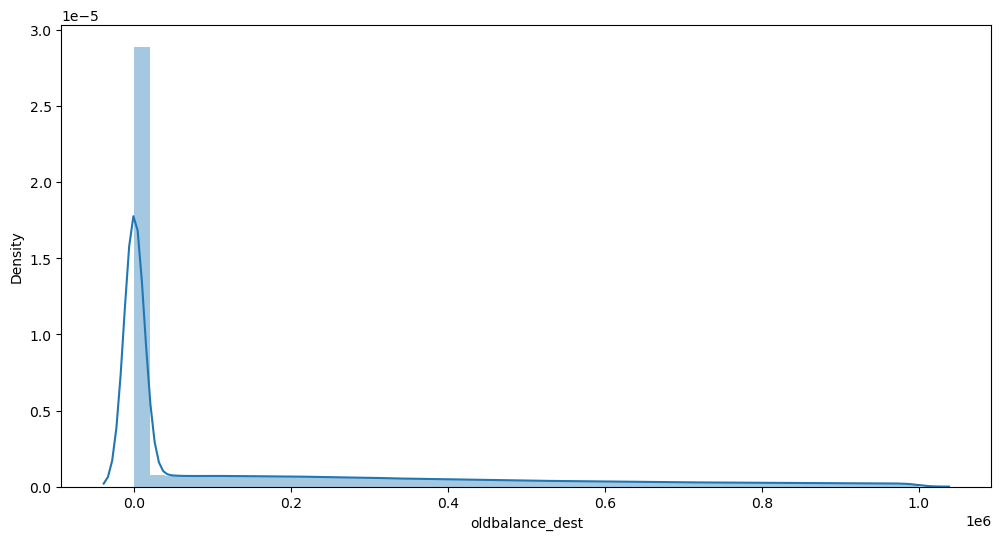

In [38]:
 # oldbalance_dest distribution values lower than 1,000,000

# set up figure size
plt.subplots(figsize=(12,6))
sns.distplot(df4[df4['oldbalance_dest'] < 1e6]['oldbalance_dest']);

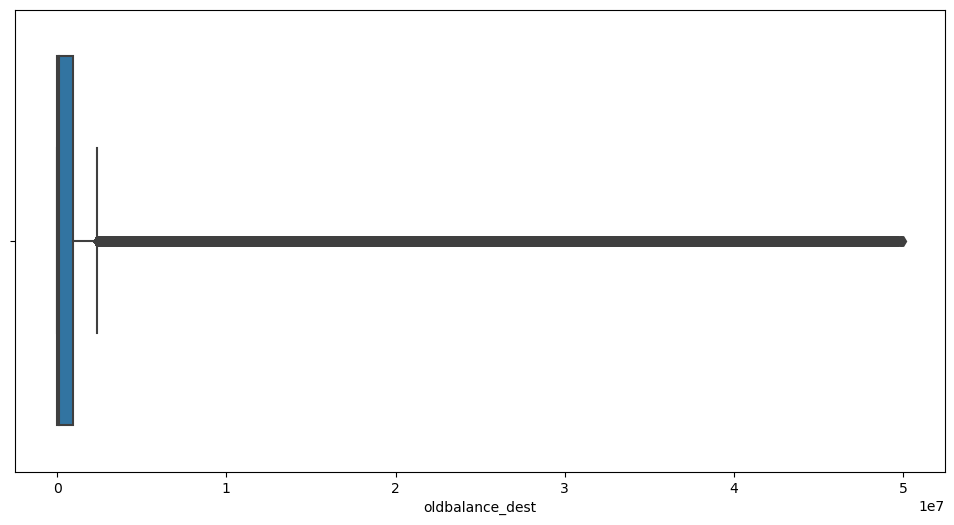

In [39]:
# oldbalance_dest boxplot
plt.subplots(figsize=(12,6))
sns.boxplot(df4['oldbalance_dest']);

### 4.1.2.6. newbalance_dest feature

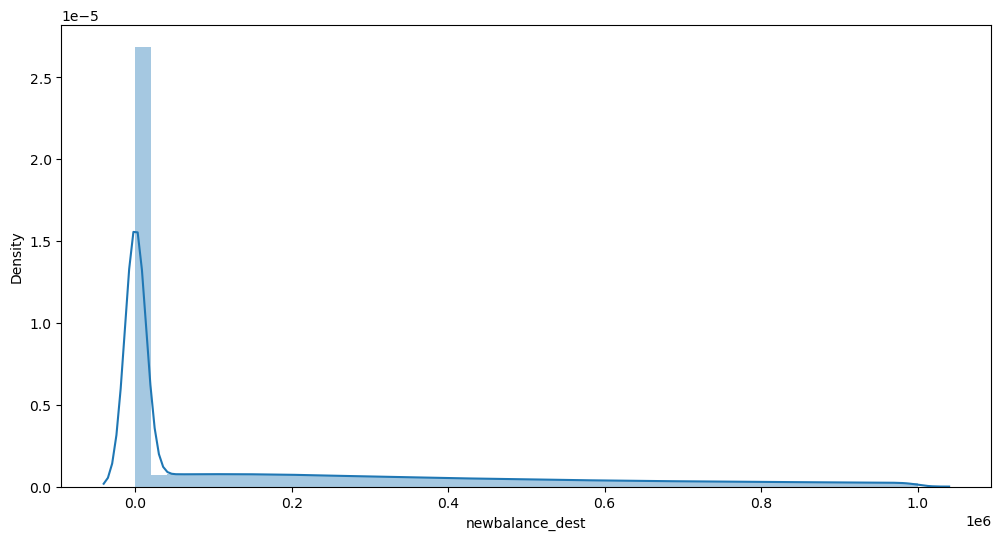

In [41]:
# newbalance_dest distribution

# set up figure size
plt.subplots(figsize=(12,6))
sns.distplot(df4[df4['newbalance_dest'] < 1e6]['newbalance_dest']);

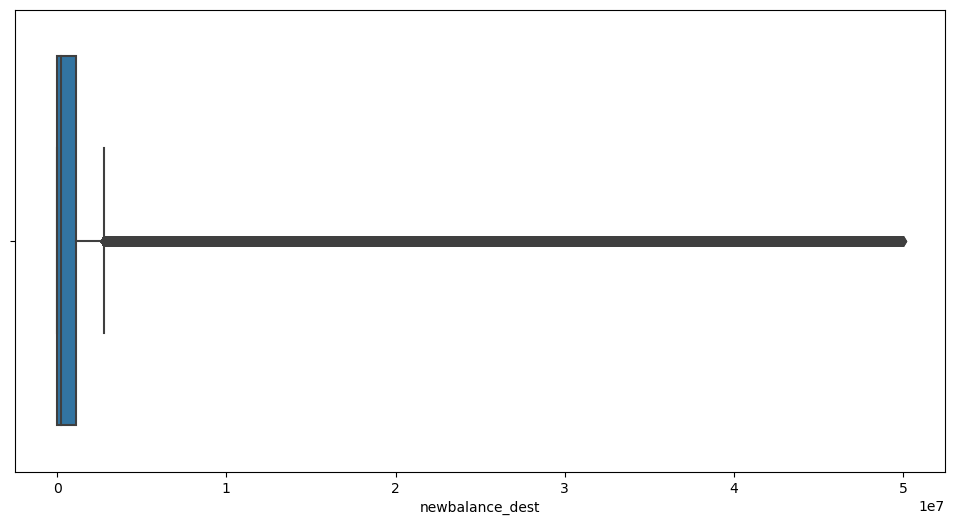

In [42]:
# newbalance_dest boxplot
plt.subplots(figsize=(12,6))
sns.boxplot(df4['newbalance_dest']);

### 4.1.2.7. diff_dest feature**

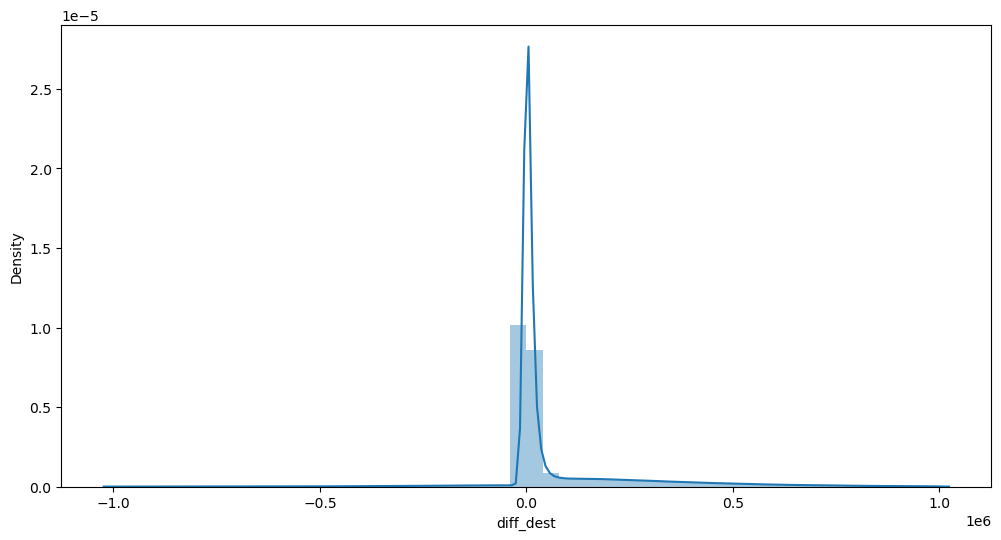

In [43]:
 # diff_dest distribution

# set up figure size
plt.subplots(figsize=(12,6))
sns.distplot(df4[(df4['diff_dest'] > -1e6) & (df4['diff_dest'] < 1e6)]['diff_dest']);

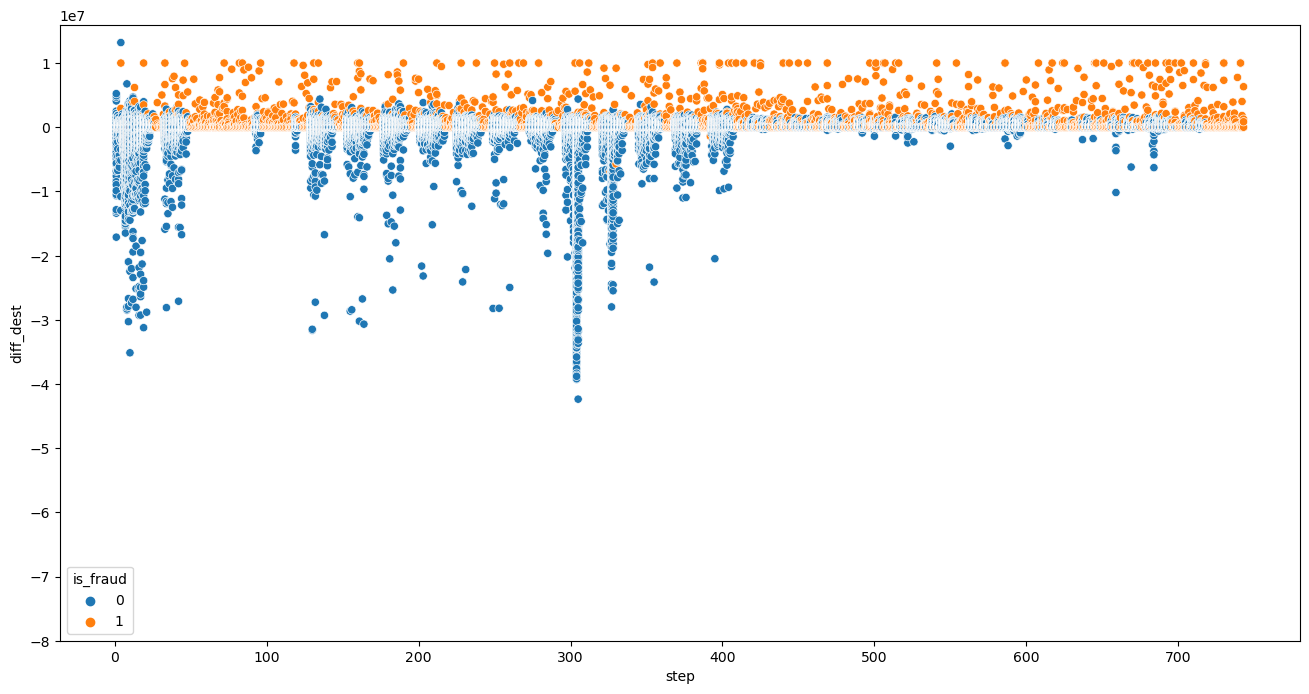

In [44]:
 # set up figure size
plt.subplots(figsize=(16,8))
# plot diff_orig scatterplot
sns.scatterplot(x='step', y='diff_dest', hue='is_fraud', data=df4)
# set y-axis labels
plt.yticks(np.arange(-8.e+07, 2.e+07, step=1.e+07));

- diff_dest values labeled as fraudulent ranges from zero to 10 million.

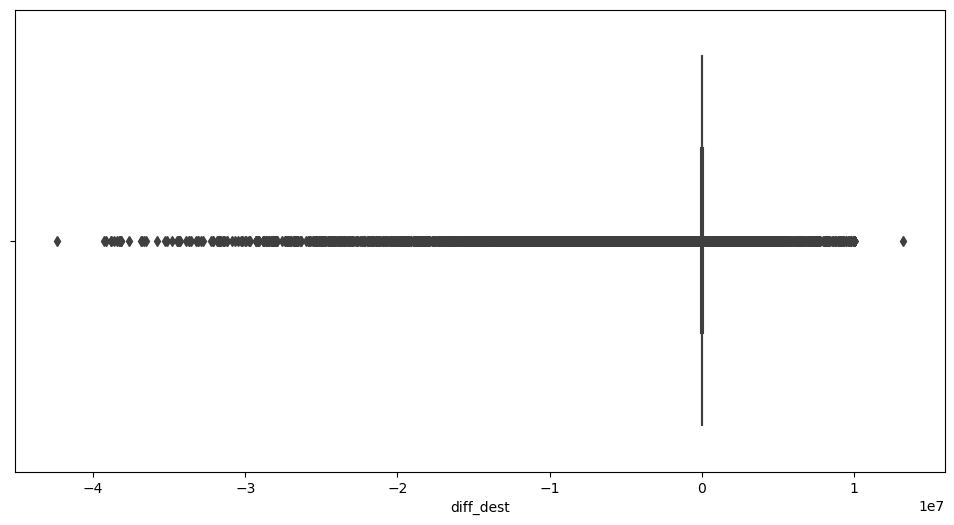

In [45]:
# diff_dest boxplot
plt.subplots(figsize=(12,6))
sns.boxplot(df4['diff_dest']);

In [46]:
df4['diff_dest'].value_counts(normalize=True) 

 0.00         2.553330e-01
 0.01         2.173415e-02
-0.01         2.166966e-02
 0.01         8.340812e-03
-0.01         8.297447e-03
                  ...     
 20993.92     2.246865e-07
 17771.52     2.246865e-07
 757.32       2.246865e-07
 24606.68     2.246865e-07
 850002.52    2.246865e-07
Name: diff_dest, Length: 2326917, dtype: float64

- 25% of diff_dest values are equal to zero.

### 4.1.3. Categorical Variable

In [47]:
 # select categorical attributes
cat_attr = df4.select_dtypes(include=['object'])

In [48]:
cat_attr.describe() 

type    name_orig   name_dest
count    4450646      4450646     4450646
unique         5      4446041     2035157
top     CASH_OUT  C1976208114  C985934102
freq     1564728            3          86

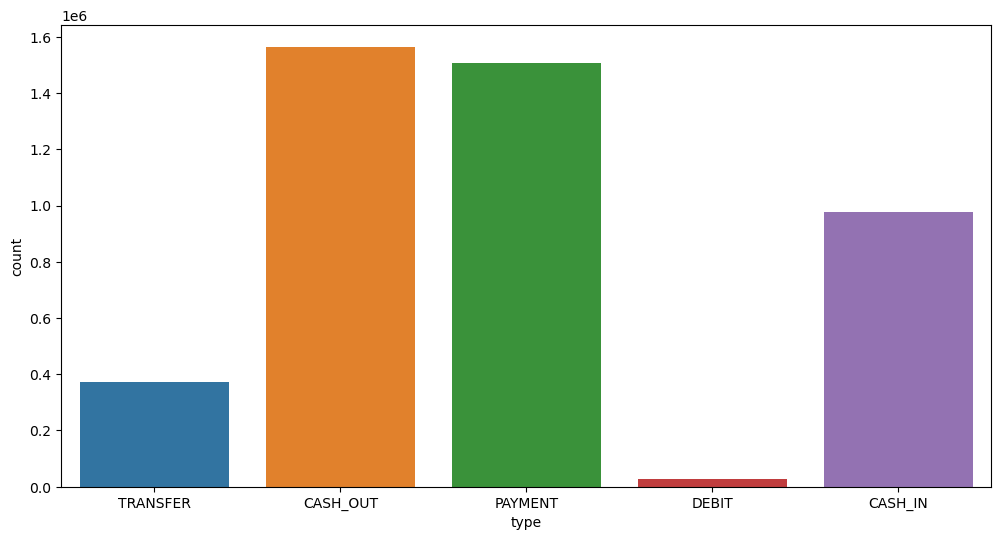

In [49]:
 # plot type feature
plt.subplots(figsize=(12,6))
sns.countplot(cat_attr['type']);

In [50]:
cat_attr['type'].value_counts(normalize=True) 

CASH_OUT    0.351573
PAYMENT     0.338545
CASH_IN     0.219858
TRANSFER    0.083494
DEBIT       0.006530
Name: type, dtype: float64

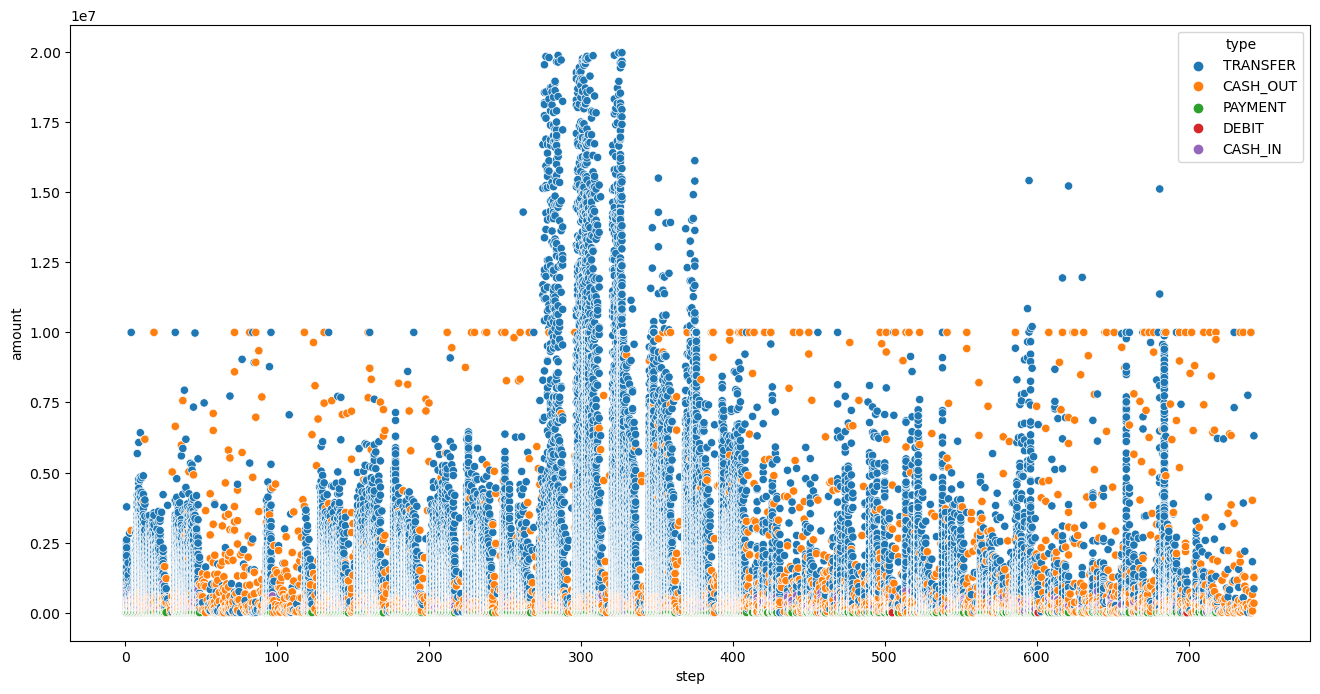

In [51]:
 # amount scatterplot with type
plt.subplots(figsize=(16,8))
sns.scatterplot(x='step', y='amount', hue='type', data=df4);

## 4.2. Bivariate Analysis**

## 4.3. Multivariate Analysis**

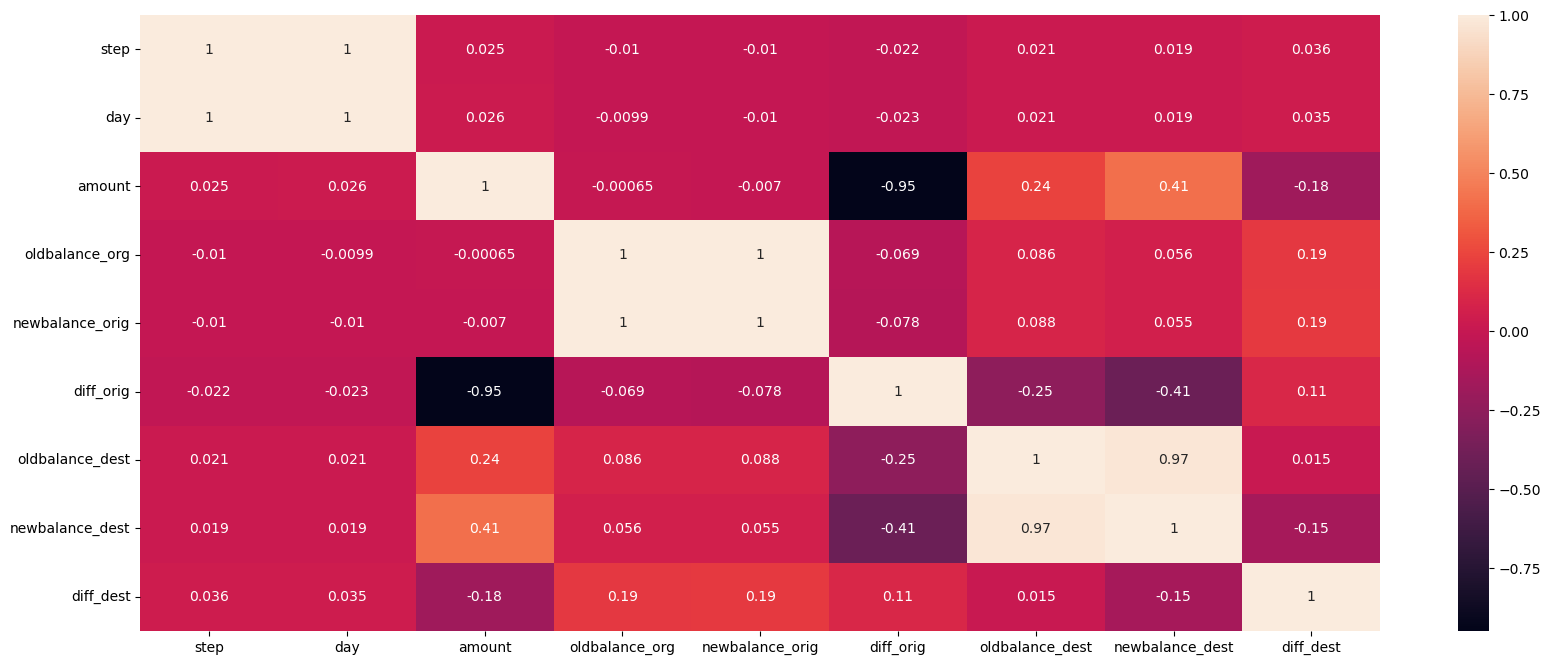

In [52]:
# select numerical attributes
num_attr = df4.select_dtypes(include=['int64', 'float64'])

# drop binary variables
num_attr = df4.drop(['merchant_dest', 'is_fraud', 'is_flagged_fraud'], axis=1)

# correlation by pearosn method
correlation = num_attr.corr( method='pearson' )

# set up figure size
f, ax = plt.subplots( figsize=(20,8))

sns.heatmap( correlation, annot=True );

 **Highest correlations:**
- step x day = 1 (day was created with step);
- oldbalance_org x newbalance_orig = 1;
- oldbalance_dest x newbalance_dest = 0.97;
- amount x diff_orig = -0.95;
- amount x newbalance_dest = 0.41;
- newbalance_dest x diff_orig = -0.41;
- oldbalance_dest x diff_orig = -0.25;



 The diff_orig feature has more correlation with oldbalance_dest (-0.25) and newbalance_dest (-0.41) than with origin balances. The same is true for diff_dest: it has more correlation with oldbalance_org (0.19) and newbalance_orig (0.19) than with destination balances.

# 5.0. Data Preparation

In [53]:
df5 = df4.copy()

## 5.1. Rescaling

In [54]:
# 1. Min-Max Scaler - step
mms = MinMaxScaler()

# step
df5['step'] = mms.fit_transform(df5[['step']].values)
# save scaler, so it can be applied in new data
with open('../src/features/step_scaler.pkl', 'wb') as f:
    pickle.dump(mms, f)

# 2. Robust Scaler - amount, oldbalance_org, newbalane_orig, diff_orig, oldbalance_dest, newbalance_dest, diff_dest
rs = RobustScaler()

# amount
df5['amount'] = rs.fit_transform(df5[['amount']].values)
# save scaler, so it can be applied in new data
with open('../src/features/amount_scaler.pkl', 'wb') as f:
    pickle.dump(rs, f)
    
# oldbalance_org
df5['oldbalance_org'] = rs.fit_transform(df5[['oldbalance_org']].values)
# save scaler, so it can be applied in new data
with open('../src/features/oldbalance_org_scaler.pkl', 'wb') as f:
    pickle.dump(rs, f)
    
# newbalance_orig
df5['newbalance_orig'] = rs.fit_transform(df5[['newbalance_orig']].values)
# save scaler, so it can be applied in new data
with open('../src/features/newbalance_orig_scaler.pkl', 'wb') as f:
    pickle.dump(rs, f)
    
# diff_orig
df5['diff_orig'] = rs.fit_transform(df5[['diff_orig']].values)
# save scaler, so it can be applied in new data
with open('../src/features/diff_orig_scaler.pkl', 'wb') as f:
    pickle.dump(rs, f)
    
# oldbalance_dest
df5['oldbalance_dest'] = rs.fit_transform(df5[['oldbalance_dest']].values)
# save scaler, so it can be applied in new data
with open('../src/features/oldbalance_dest_scaler.pkl', 'wb') as f:
    pickle.dump(rs, f)
    
# newbalance_dest
df5['newbalance_dest'] = rs.fit_transform(df5[['newbalance_dest']].values)
# save scaler, so it can be applied in new data
with open('../src/features/newbalance_dest_scaler.pkl', 'wb') as f:
    pickle.dump(rs, f)

# diff_dest
df5['diff_dest'] = rs.fit_transform(df5[['diff_dest']].values)
# save scaler, so it can be applied in new data
with open('../src/features/diff_dest_scaler.pkl', 'wb') as f:
    pickle.dump(rs, f)

## 5.2. Transformation

### 5.2.1. Encoding

In [55]:
# type feature - apply one hot encoding
df5 = pd.get_dummies(df5, prefix=['type'], columns=['type'])

### 5.2.2. Nature Transformation

In [56]:
 # apply nature transformation on day feature
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * (2. * np.pi/31 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * (2. * np.pi/31 ) ) )

In [57]:
df5.head().T

0           1           2           3            4
step                      0.0         0.0         0.0         0.0          0.0
day                         1           1           1           1            1
name_orig         C1305486145  C840083671   C90045638  C154988899  C1912850431
amount              -0.382005   -0.382005   -0.342866   -0.346505    -0.342641
oldbalance_org      -0.130967   -0.130967     0.36958    1.575604     1.509326
newbalance_orig           0.0         0.0    0.319506    1.221941     1.167386
diff_orig            0.277996    0.277996    0.277996    0.277996     0.277996
name_dest          C553264065   C38997010  M573487274  M408069119   M633326333
merchant_dest               0           0           1           1            1
oldbalance_dest     -0.140354   -0.117804   -0.140354   -0.140354    -0.140354
newbalance_dest     -0.192791   -0.192791   -0.192791   -0.192791    -0.192791
diff_dest           -0.113599    0.607658    0.146434    0.122261      0.14793
is_fraud                    1           1           0           0            0
is_flagged_fraud            0           0           0           0            0
type_CASH_IN                0           0           0           0            0
type_CASH_OUT               0           1           0           0            0
type_DEBIT                  0           0           0           0            0
type_PAYMENT                0           0           1           1            1
type_TRANSFER               1           0           0           0            0
day_sin              0.201299    0.201299    0.201299    0.201299     0.201299
day_cos               0.97953     0.97953     0.97953     0.97953      0.97953

# 6.0. Feature Selection

In [58]:
# Remove unnecessary columns

# Remove step because feature day was created based on it
# Remove day because day_sin and day_cos were created
# Remove name_orig and name_dest because they will not be considered to train the model

df5 = df5.drop(['step', 'day', 'name_orig', 'name_dest'], axis=1)

In [59]:
 # Remove target variable from train set
X_train = df5.drop('is_fraud', axis=1)

# target variable
y_train = df5['is_fraud'].copy()

In [60]:
X_train.head()

amount  oldbalance_org  newbalance_orig  diff_orig  merchant_dest  \
0 -0.382005       -0.130967         0.000000   0.277996              0   
1 -0.382005       -0.130967         0.000000   0.277996              0   
2 -0.342866        0.369580         0.319506   0.277996              1   
3 -0.346505        1.575604         1.221941   0.277996              1   
4 -0.342641        1.509326         1.167386   0.277996              1   

   oldbalance_dest  newbalance_dest  diff_dest  is_flagged_fraud  \
0        -0.140354        -0.192791  -0.113599                 0   
1        -0.117804        -0.192791   0.607658                 0   
2        -0.140354        -0.192791   0.146434                 0   
3        -0.140354        -0.192791   0.122261                 0   
4        -0.140354        -0.192791   0.147930                 0   

   type_CASH_IN  type_CASH_OUT  type_DEBIT  type_PAYMENT  type_TRANSFER  \
0             0              0           0             0              1   
1             0              1           0             0              0   
2             0              0           0             1              0   
3             0              0           0             1              0   
4             0              0           0             1              0   

    day_sin  day_cos  
0  0.201299  0.97953  
1  0.201299  0.97953  
2  0.201299  0.97953  
3  0.201299  0.97953  
4  0.201299  0.97953

In [61]:
y_train

0          1
1          1
2          0
3          0
4          0
          ..
4450641    1
4450642    1
4450643    1
4450644    1
4450645    1
Name: is_fraud, Length: 4450646, dtype: int64

## 6.1. Random Forest as Feature Selector

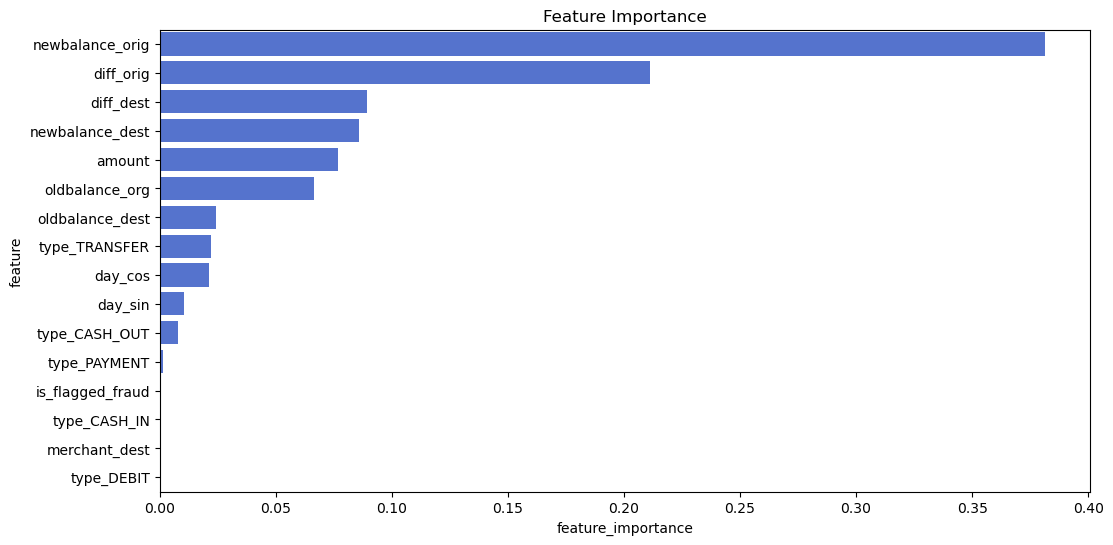

In [62]:
# train random forest classifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# feature importance data frame
feat_imp = pd.DataFrame({'feature': X_train.columns,
                        'feature_importance': rf.feature_importances_})\
                        .sort_values('feature_importance', ascending=False)\
                        .reset_index(drop=True)


# plot feature importance
plt.subplots(figsize=(12,6))
sns.barplot(x='feature_importance', y='feature', data=feat_imp, orient='h', color='royalblue')\
    .set_title('Feature Importance');

- The top features selected by the random forest are in accordance with the exploratory data analysis.

In [63]:
 # Select top 11 features
feat_imp_select = feat_imp.iloc[:11]
feat_imp_select

feature  feature_importance
0   newbalance_orig            0.381605
1         diff_orig            0.211036
2         diff_dest            0.089296
3   newbalance_dest            0.085817
4            amount            0.076983
5    oldbalance_org            0.066490
6   oldbalance_dest            0.024237
7     type_TRANSFER            0.022042
8           day_cos            0.021218
9           day_sin            0.010332
10    type_CASH_OUT            0.007649

In [64]:
# top features list
feat_list = feat_imp_select['feature'].to_list()
feat_list

['newbalance_orig',
 'diff_orig',
 'diff_dest',
 'newbalance_dest',
 'amount',
 'oldbalance_org',
 'oldbalance_dest',
 'type_TRANSFER',
 'day_cos',
 'day_sin',
 'type_CASH_OUT']

## 6.3. Save Preprocessed Data

In [65]:
 # copy x_train with selected features
feat_list = ['newbalance_orig',
 'diff_orig',
 'amount',
 'diff_dest',
 'newbalance_dest',
 'oldbalance_org',
 'oldbalance_dest',
 'type_TRANSFER',
 'day_cos',
 'type_CASH_OUT',
 'day_sin']

x_train = X_train[feat_list]

In [66]:
 # Save the preprocessed dataset
with open('../src/data/train_prep_v02.pkl', 'wb') as f:
    pickle.dump(x_train, f)
    
# save target variable
with open('../src/data/train_target_v02.pkl', 'wb') as f:
    pickle.dump(y_train, f)

# 7.0. Machine Learning Modelling

In [25]:
# Open preprocessed dataset
with open('../src/data/train_prep_v02.pkl', 'rb') as f:
    x_train = pickle.load(f)
    
# open target variable
with open('../src/data/train_target_v02.pkl', 'rb') as f:
    y_train = pickle.load(f)

In [20]:
x_train.sample(5) 

newbalance_orig  diff_orig  amount  diff_dest  newbalance_dest  \
1008682            0.000     -5.142   6.462     -0.120            2.436   
3729588            0.000     -0.171   1.120     -0.120            0.491   
2492650            0.113      0.278  -0.306     -0.120            5.291   
1857460            0.910     -0.372   0.027      4.088           -0.193   
3228786            0.241      0.278  -0.234      0.867           -0.193   

         oldbalance_org  oldbalance_dest  type_TRANSFER  day_cos  \
1008682          -0.133            1.539              1    0.347   
3729588           1.571            0.354              0   -0.995   
2492650           0.159            6.312              0   -0.612   
1857460           0.344           -0.094              0   -0.251   
3228786           0.461           -0.140              0   -0.954   

         type_CASH_OUT  day_sin  
1008682              0    0.938  
3729588              1   -0.101  
2492650              1    0.791  
1857460              0    0.968  
3228786              0    0.299

# 7.1. Logistic Regression

In [19]:
 # define the model
logit_clf = LogisticRegression()

# fit the model
logit_clf.fit(x_train, y_train)

# model performance with performance function. For more details, please see Helper Functions section.
logit_performance = performance(logit_clf, x_train, y_train)
logit_performance

test_accuracy  test_precision  test_recall  test_f1_score  \
0          0.999           0.834        0.481          0.589   

   test_roc_auc_score  test_mcc  
0               0.740     0.622

In [20]:
 # predcitions
logit_y_pred = cross_val_predict(logit_clf, x_train, y_train, cv=10)

# save predictions
with open('../src/models/logit_y_pred.pkl', 'wb') as f:
    pickle.dump(logit_y_pred, f)

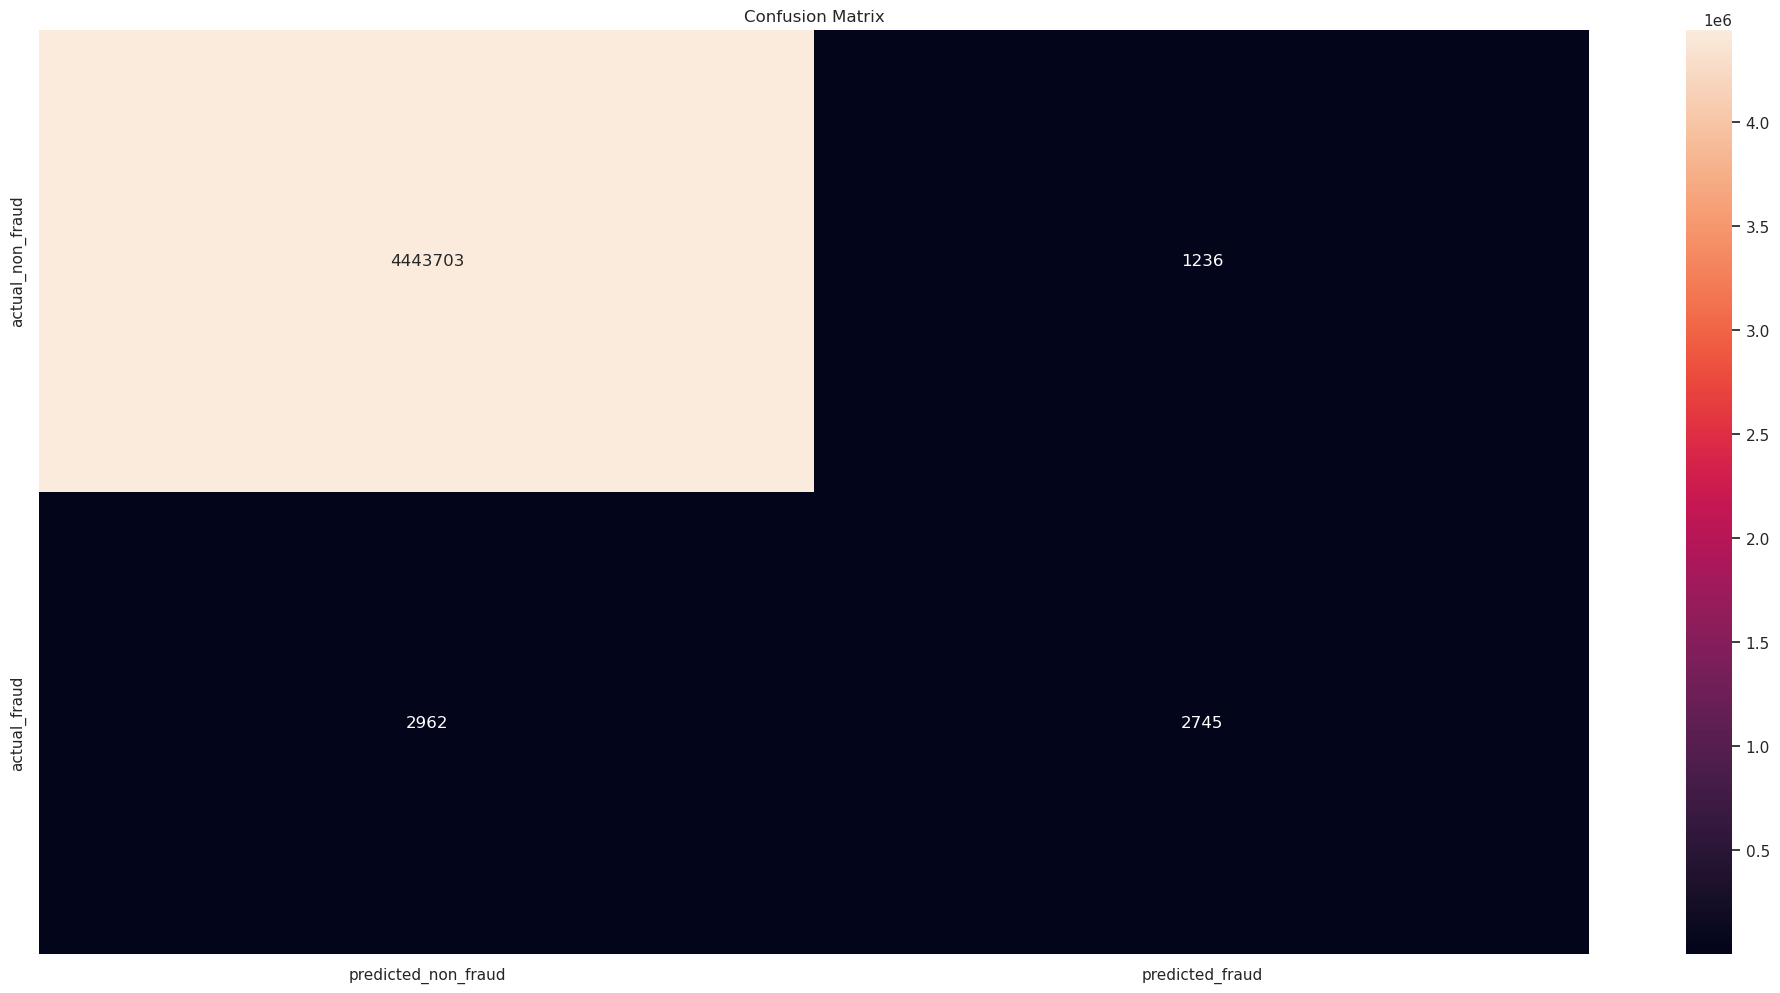

In [21]:
# confusion matrix
logit_cm = confusion_matrix(y_train, logit_y_pred)

# dataframe for heatmap
logit_cm_df = pd.DataFrame(logit_cm, columns=['predicted_non_fraud', 'predicted_fraud'], index=['actual_non_fraud', 'actual_fraud'])

# confusion matrix heatmap
sns.heatmap(logit_cm_df, annot=True, fmt='d').set_title('Confusion Matrix');

## 7.2. Random Forest Classifier

In [21]:
 # define the model
rf_clf = RandomForestClassifier(random_state=42, n_jobs=-1).fit(x_train, y_train)

In [22]:
 # model performance with performance function. For more details, please see Helper Functions section.
rf_performance = performance(rf_clf, x_train, y_train)
rf_performance

test_accuracy  test_precision  test_recall  test_f1_score  \
0          0.873           0.800        0.995          0.799   

   test_roc_auc_score  test_mcc  
0               0.934     0.803

In [23]:
 # predcitions
rf_y_pred = cross_val_predict(rf_clf, x_train, y_train, cv=5)

# save predictions
with open('../src/models/rf_y_pred.pkl', 'wb') as f:
    pickle.dump(rf_y_pred, f)

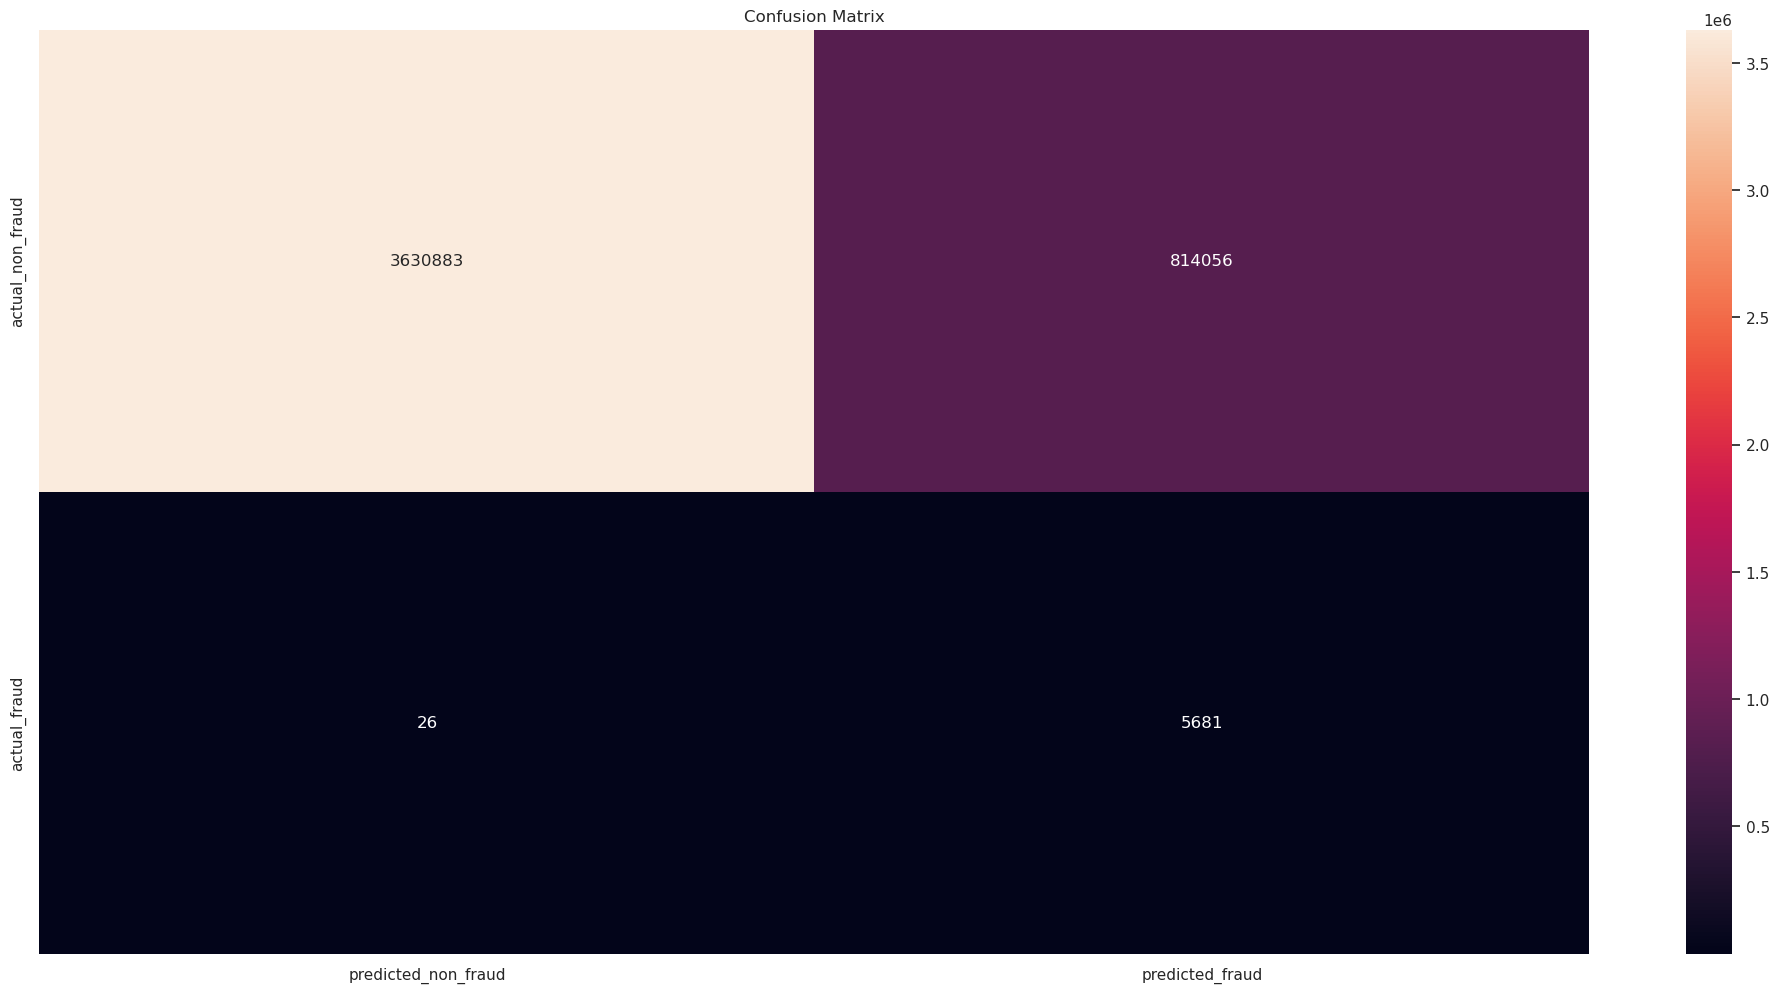

In [24]:
 # confusion matrix
rf_cm = confusion_matrix(y_train, rf_y_pred)

# dataframe for heatmap
rf_cm_df = pd.DataFrame(rf_cm, columns=['predicted_non_fraud', 'predicted_fraud'], index=['actual_non_fraud', 'actual_fraud'])

# confusion matrix heatmap
sns.heatmap(rf_cm_df, annot=True, fmt='d').set_title('Confusion Matrix');

## 7.3. XGBoost Classifier

In [62]:
# define the model
xgb_clf = XGBClassifier(random_state=42, n_jobs=-1).fit(x_train, y_train)

[13:55:04] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [63]:
 # model performance with performance function. For more details, please see Helper Functions section.
xgb_performance = performance(xgb_clf, x_train, y_train)
xgb_performance

[14:01:11] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:04:12] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:08:29] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:12:42] WARNING: /tmp/abs_40obctay9q/croots/recip

test_accuracy  test_precision  test_recall  test_f1_score  \
0          1.000           0.920        0.994          0.933   

   test_roc_auc_score  test_mcc  
0               0.997     0.944

In [64]:
# predictions
xgb_y_pred = cross_val_predict(xgb_clf, x_train, y_train, cv=10)


[15:07:54] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:10:21] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:13:31] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:16:48] WARNING: /tmp/abs_40obctay9q/croots/recip

In [65]:

# save predictions
with open('../src/models/xgb_y_pred.pkl', 'wb') as f:
    pickle.dump(xgb_y_pred, f)

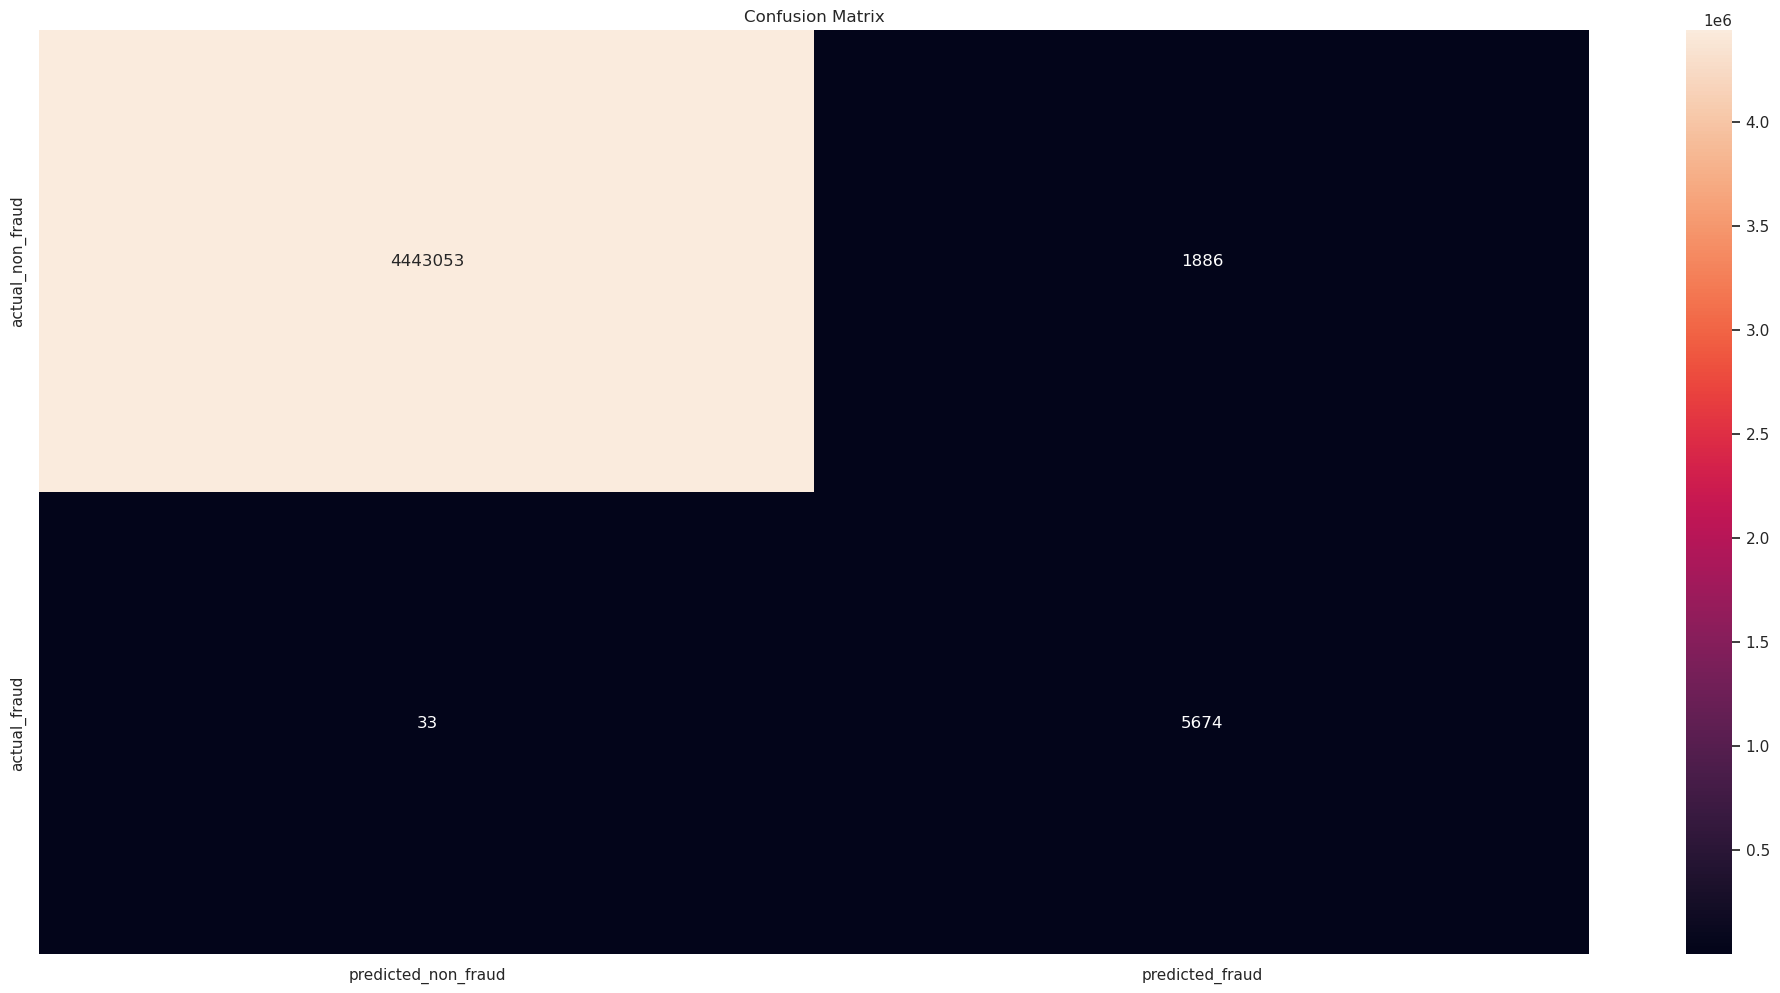

In [28]:
 # confusion matrix
xgb_cm = confusion_matrix(y_train, xgb_y_pred)

# dataframe for heatmap
xgb_cm_df = pd.DataFrame(xgb_cm, columns=['predicted_non_fraud', 'predicted_fraud'], index=['actual_non_fraud', 'actual_fraud'])

# confusion matrix heatmap
sns.heatmap(xgb_cm_df, annot=True, fmt='d').set_title('Confusion Matrix');

## 7.4. Performance Comparison

In [29]:
 # performance comparison data frame
performance_comp = pd.concat([logit_performance, rf_performance, xgb_performance])
performance_comp.columns = ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc_score', 'MCC']
performance_comp['model'] = ['Logistic Regression', 'Random Forest', 'XGBoost']
performance_comp = performance_comp[['model', 'accuracy', 'precision', 'recall', 'f1_score', 'roc_auc_score', 'MCC']]
performance_comp.set_index('model')

accuracy  precision  recall  f1_score  roc_auc_score  \
model                                                                       
Logistic Regression     0.999      0.834   0.481     0.589          0.740   
Random Forest           0.873      0.800   0.995     0.799          0.934   
XGBoost                 1.000      0.920   0.994     0.933          0.997   

                      MCC  
model                      
Logistic Regression 0.622  
Random Forest       0.803  
XGBoost             0.944

- XGBoost is the model with the best performance

# 8.0. Hyperparameter Fine Tuning

## 8.1. Prepare test set

In [19]:
df_test.head()

step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   CASH_IN 55837.160   C713898436    4849053.050     4904890.210   
1     1   CASH_IN 25090.030   C864221358    6572510.820     6597600.850   
2     1   PAYMENT  4828.430   C247644034      36736.580       31908.140   
3     1  CASH_OUT 30308.450  C1949126165      88926.200       88926.200   
4     1   PAYMENT 12491.010   C247795540          0.000           0.000   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0   C100555887       66800.820       10963.660        0               0  
1  C1282788025       80148.600           0.000        0               0  
2   M214313531           0.000           0.000        0               0  
3  C1568059495       88926.200      122750.490        0               0  
4   M200744172           0.000           0.000        0               0

In [20]:
# cols new
cols_old = df_test.columns
# apply snakecase to columns names
snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, cols_old))

# Rename columns
df_test.columns = cols_new

# create origin balance difference feature
df_test['diff_orig'] = df_test['oldbalance_org'] - df_test['amount'] - df_test['newbalance_orig']

# create destination balance difference feature
df_test['diff_dest'] = df_test['oldbalance_dest'] + df_test['amount'] - df_test['newbalance_dest']

# create merchant_dest feature
df_test['merchant_dest'] = df_test.apply(lambda x: 1 if 'M' in x['name_dest'] else 0, axis=1)

# create day feature
df_test['day'] = df_test.apply(lambda x: (np.ceil(x['step'] / 24)).astype(int), axis=1)

# reorder columns
df_test = df_test[['step', 'day', 'type', 'name_orig', 'amount', 'oldbalance_org',
       'newbalance_orig', 'diff_orig', 'name_dest', 'merchant_dest', 
       'oldbalance_dest', 'newbalance_dest', 'diff_dest',
       'is_fraud', 'is_flagged_fraud']]

# Remove outliers from amount feature
df_test = df_test[df_test['amount'] < 20e6]

# Remove oldbalance_dest outliers
df_test = df_test[df_test['oldbalance_dest'] < 5e7]

# Remove newbalance_dest outliers
df_test = df_test[df_test['newbalance_dest'] < 5e7]
df_test.head()

step  day      type    name_orig    amount  oldbalance_org  \
0     1    1   CASH_IN   C713898436 55837.160     4849053.050   
1     1    1   CASH_IN   C864221358 25090.030     6572510.820   
2     1    1   PAYMENT   C247644034  4828.430       36736.580   
3     1    1  CASH_OUT  C1949126165 30308.450       88926.200   
4     1    1   PAYMENT   C247795540 12491.010           0.000   

   newbalance_orig   diff_orig    name_dest  merchant_dest  oldbalance_dest  \
0      4904890.210 -111674.320   C100555887              0        66800.820   
1      6597600.850  -50180.060  C1282788025              0        80148.600   
2        31908.140       0.010   M214313531              1            0.000   
3        88926.200  -30308.450  C1568059495              0        88926.200   
4            0.000  -12491.010   M200744172              1            0.000   

   newbalance_dest  diff_dest  is_fraud  is_flagged_fraud  
0        10963.660 111674.320         0                 0  
1            0.000 105238.630         0                 0  
2            0.000   4828.430         0                 0  
3       122750.490  -3515.840         0                 0  
4            0.000  12491.010         0                 0

In [21]:
 # copy test set
X_test_prep = df_test.copy()

In [22]:
# Transformations
# Load scalers
step_scaler = pickle.load(open('../src/features/step_scaler.pkl', 'rb'))
amount_scaler = pickle.load(open('../src/features/amount_scaler.pkl', 'rb'))
oldbalance_org_scaler = pickle.load(open('../src/features/oldbalance_org_scaler.pkl', 'rb'))
newbalance_orig_scaler = pickle.load(open('../src/features/newbalance_orig_scaler.pkl', 'rb'))
diff_orig_scaler = pickle.load(open('../src/features/diff_orig_scaler.pkl', 'rb'))
oldbalance_dest_scaler = pickle.load(open('../src/features/oldbalance_dest_scaler.pkl', 'rb'))
newbalance_dest_scaler = pickle.load(open('../src/features/newbalance_dest_scaler.pkl', 'rb'))
diff_dest_scaler = pickle.load(open('../src/features/diff_dest_scaler.pkl', 'rb'))

# step
X_test_prep['step'] = step_scaler.fit_transform(X_test_prep[['step']].values)

# amount
X_test_prep['amount'] = amount_scaler.fit_transform(X_test_prep[['amount']].values)

# oldbalance_org
X_test_prep['oldbalance_org'] = oldbalance_org_scaler.fit_transform(X_test_prep[['oldbalance_org']].values)

# newbalance_orig
X_test_prep['newbalance_orig'] = newbalance_orig_scaler.fit_transform(X_test_prep[['newbalance_orig']].values)

# diff_orig
X_test_prep['diff_orig'] = diff_orig_scaler.fit_transform(X_test_prep[['diff_orig']].values)

# oldbalance_dest
X_test_prep['oldbalance_dest'] = oldbalance_dest_scaler.fit_transform(X_test_prep[['oldbalance_dest']].values)

# newbalance_dest
X_test_prep['newbalance_dest'] = newbalance_dest_scaler.fit_transform(X_test_prep[['newbalance_dest']].values)

# diff_dest
X_test_prep['diff_dest'] = diff_dest_scaler.fit_transform(X_test_prep[['diff_dest']].values)

# Encoding
# type feature - apply one hot encoding
X_test_prep = pd.get_dummies(X_test_prep, prefix=['type'], columns=['type'])

# Nature Transformation
# apply nature transformation on day feature
X_test_prep['day_sin'] = X_test_prep['day'].apply( lambda x: np.sin( x * (2. * np.pi/31 ) ) )
X_test_prep['day_cos'] = X_test_prep['day'].apply( lambda x: np.cos( x * (2. * np.pi/31 ) ) )

In [23]:
 # target
y_test = X_test_prep['is_fraud'].copy()

In [24]:
 # selected features list
feat_list = ['newbalance_orig',
 'diff_orig',
 'amount',
 'diff_dest',
 'newbalance_dest',
 'oldbalance_org',
 'oldbalance_dest',
 'type_TRANSFER',
 'day_cos',
 'type_CASH_OUT',
 'day_sin']

# selected features
x_test = X_test_prep[feat_list]

## 8.2. Bayesian Optimization with HYPEROPT


In [26]:
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
    }

### 8.2.1. Define objective function ¶


In [27]:
def objective(space):
    
    clf=XGBClassifier(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    evaluation = [(x_train, y_train), (x_test , y_test)]
    
    clf.fit(x_train, y_train,
            eval_set=evaluation, 
            eval_metric="logloss",
            early_stopping_rounds=10)
    

    # predictions
    xgb_y_pred = clf.predict(x_test)
    accuracy = recall_score(y_test, xgb_y_pred)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

### 8.2.2. Optimization algorithm ¶


In [28]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

[0]	validation_0-logloss:0.43834	validation_1-logloss:0.43894                                                           
[1]	validation_0-logloss:0.29824	validation_1-logloss:0.29835                                                           
[2]	validation_0-logloss:0.21014	validation_1-logloss:0.21007                                                           
[3]	validation_0-logloss:0.15084	validation_1-logloss:0.15112                                                           
[4]	validation_0-logloss:0.11061	validation_1-logloss:0.11043                                                           
[5]	validation_0-logloss:0.08146	validation_1-logloss:0.08178                                                           
[6]	validation_0-logloss:0.06151	validation_1-logloss:0.06137                                                           
[7]	validation_0-logloss:0.04680	validation_1-logloss:0.04668                                                           
[8]	validation_0-logloss:0.03595

[23]	validation_0-logloss:0.00987	validation_1-logloss:0.00996                                                          
[24]	validation_0-logloss:0.00984	validation_1-logloss:0.00994                                                          
[25]	validation_0-logloss:0.00983	validation_1-logloss:0.00994                                                          
[26]	validation_0-logloss:0.00980	validation_1-logloss:0.00994                                                          
[27]	validation_0-logloss:0.00981	validation_1-logloss:0.00994                                                          
[28]	validation_0-logloss:0.00982	validation_1-logloss:0.00993                                                          
[29]	validation_0-logloss:0.00981	validation_1-logloss:0.00993                                                          
[30]	validation_0-logloss:0.00982	validation_1-logloss:0.00993                                                          
[31]	validation_0-logloss:0.0098

[5]	validation_0-logloss:0.08146	validation_1-logloss:0.08178                                                           
[6]	validation_0-logloss:0.06151	validation_1-logloss:0.06137                                                           
[7]	validation_0-logloss:0.04680	validation_1-logloss:0.04668                                                           
[8]	validation_0-logloss:0.03595	validation_1-logloss:0.03613                                                           
[9]	validation_0-logloss:0.02831	validation_1-logloss:0.02847                                                           
[10]	validation_0-logloss:0.02283	validation_1-logloss:0.02295                                                          
[11]	validation_0-logloss:0.01887	validation_1-logloss:0.01899                                                          
[12]	validation_0-logloss:0.01610	validation_1-logloss:0.01614                                                          
[13]	validation_0-logloss:0.0140

[27]	validation_0-logloss:0.00981	validation_1-logloss:0.00994                                                          
[28]	validation_0-logloss:0.00982	validation_1-logloss:0.00993                                                          
[29]	validation_0-logloss:0.00981	validation_1-logloss:0.00993                                                          
[30]	validation_0-logloss:0.00982	validation_1-logloss:0.00993                                                          
[31]	validation_0-logloss:0.00982	validation_1-logloss:0.00993                                                          
[32]	validation_0-logloss:0.00982	validation_1-logloss:0.00993                                                          
[33]	validation_0-logloss:0.00982	validation_1-logloss:0.00993                                                          
[34]	validation_0-logloss:0.00982	validation_1-logloss:0.00993                                                          
[35]	validation_0-logloss:0.0098

[0]	validation_0-logloss:0.43834	validation_1-logloss:0.43894                                                           
[1]	validation_0-logloss:0.29824	validation_1-logloss:0.29835                                                           
[2]	validation_0-logloss:0.21014	validation_1-logloss:0.21007                                                           
[3]	validation_0-logloss:0.15084	validation_1-logloss:0.15112                                                           
[4]	validation_0-logloss:0.11061	validation_1-logloss:0.11043                                                           
[5]	validation_0-logloss:0.08146	validation_1-logloss:0.08177                                                           
[6]	validation_0-logloss:0.06151	validation_1-logloss:0.06137                                                           
[7]	validation_0-logloss:0.04680	validation_1-logloss:0.04668                                                           
[8]	validation_0-logloss:0.03595

[26]	validation_0-logloss:0.00984	validation_1-logloss:0.00994                                                          
[27]	validation_0-logloss:0.00980	validation_1-logloss:0.00994                                                          
[28]	validation_0-logloss:0.00981	validation_1-logloss:0.00993                                                          
[29]	validation_0-logloss:0.00982	validation_1-logloss:0.00993                                                          
[30]	validation_0-logloss:0.00982	validation_1-logloss:0.00993                                                          
[31]	validation_0-logloss:0.00981	validation_1-logloss:0.00993                                                          
[32]	validation_0-logloss:0.00981	validation_1-logloss:0.00993                                                          
[33]	validation_0-logloss:0.00981	validation_1-logloss:0.00993                                                          
[34]	validation_0-logloss:0.0098

[6]	validation_0-logloss:0.06151	validation_1-logloss:0.06137                                                           
[7]	validation_0-logloss:0.04680	validation_1-logloss:0.04668                                                           
[8]	validation_0-logloss:0.03595	validation_1-logloss:0.03610                                                           
[9]	validation_0-logloss:0.02831	validation_1-logloss:0.02847                                                           
[10]	validation_0-logloss:0.02283	validation_1-logloss:0.02295                                                          
[11]	validation_0-logloss:0.01887	validation_1-logloss:0.01898                                                          
[12]	validation_0-logloss:0.01610	validation_1-logloss:0.01614                                                          
[13]	validation_0-logloss:0.01403	validation_1-logloss:0.01413                                                          
[14]	validation_0-logloss:0.0126

[32]	validation_0-logloss:0.00982	validation_1-logloss:0.00993                                                          
[33]	validation_0-logloss:0.00982	validation_1-logloss:0.00993                                                          
[34]	validation_0-logloss:0.00983	validation_1-logloss:0.00993                                                          
[35]	validation_0-logloss:0.00981	validation_1-logloss:0.00993                                                          
[36]	validation_0-logloss:0.00982	validation_1-logloss:0.00993                                                          
[37]	validation_0-logloss:0.00982	validation_1-logloss:0.00993                                                          
[38]	validation_0-logloss:0.00982	validation_1-logloss:0.00993                                                          
[39]	validation_0-logloss:0.00982	validation_1-logloss:0.00993                                                          
[40]	validation_0-logloss:0.0098

[9]	validation_0-logloss:0.02831	validation_1-logloss:0.02847                                                           
[10]	validation_0-logloss:0.02283	validation_1-logloss:0.02295                                                          
[11]	validation_0-logloss:0.01887	validation_1-logloss:0.01898                                                          
[12]	validation_0-logloss:0.01608	validation_1-logloss:0.01614                                                          
[13]	validation_0-logloss:0.01403	validation_1-logloss:0.01413                                                          
[14]	validation_0-logloss:0.01262	validation_1-logloss:0.01272                                                          
[15]	validation_0-logloss:0.01167	validation_1-logloss:0.01174                                                          
[16]	validation_0-logloss:0.01101	validation_1-logloss:0.01108                                                          
[17]	validation_0-logloss:0.0105

[36]	validation_0-logloss:0.00982	validation_1-logloss:0.00993                                                          
[37]	validation_0-logloss:0.00982	validation_1-logloss:0.00993                                                          
[38]	validation_0-logloss:0.00982	validation_1-logloss:0.00993                                                          
[39]	validation_0-logloss:0.00982	validation_1-logloss:0.00993                                                          
SCORE:                                                                                                                  
0.0                                                                                                                     
[0]	validation_0-logloss:0.43834	validation_1-logloss:0.43894                                                           
[1]	validation_0-logloss:0.29824	validation_1-logloss:0.29835                                                           
[2]	validation_0-logloss:0.21014

[17]	validation_0-logloss:0.01054	validation_1-logloss:0.01064                                                          
[18]	validation_0-logloss:0.01027	validation_1-logloss:0.01036                                                          
[19]	validation_0-logloss:0.01008	validation_1-logloss:0.01018                                                          
[20]	validation_0-logloss:0.00994	validation_1-logloss:0.01007                                                          
[21]	validation_0-logloss:0.00992	validation_1-logloss:0.01001                                                          
[22]	validation_0-logloss:0.00990	validation_1-logloss:0.00997                                                          
[23]	validation_0-logloss:0.00986	validation_1-logloss:0.00996                                                          
[24]	validation_0-logloss:0.00984	validation_1-logloss:0.00994                                                          
[25]	validation_0-logloss:0.0098

[40]	validation_0-logloss:0.00983	validation_1-logloss:0.00993                                                          
[41]	validation_0-logloss:0.00983	validation_1-logloss:0.00993                                                          
[42]	validation_0-logloss:0.00983	validation_1-logloss:0.00993                                                          
[43]	validation_0-logloss:0.00983	validation_1-logloss:0.00993                                                          
[44]	validation_0-logloss:0.00983	validation_1-logloss:0.00993                                                          
[45]	validation_0-logloss:0.00983	validation_1-logloss:0.00993                                                          
[46]	validation_0-logloss:0.00983	validation_1-logloss:0.00993                                                          
SCORE:                                                                                                                  
0.0                             

[17]	validation_0-logloss:0.01055	validation_1-logloss:0.01064                                                          
[18]	validation_0-logloss:0.01028	validation_1-logloss:0.01036                                                          
[19]	validation_0-logloss:0.01008	validation_1-logloss:0.01019                                                          
[20]	validation_0-logloss:0.00994	validation_1-logloss:0.01008                                                          
[21]	validation_0-logloss:0.00992	validation_1-logloss:0.01001                                                          
[22]	validation_0-logloss:0.00989	validation_1-logloss:0.00998                                                          
[23]	validation_0-logloss:0.00986	validation_1-logloss:0.00996                                                          
[24]	validation_0-logloss:0.00983	validation_1-logloss:0.00995                                                          
[25]	validation_0-logloss:0.0098

[38]	validation_0-logloss:0.00982	validation_1-logloss:0.00993                                                          
SCORE:                                                                                                                  
0.0                                                                                                                     
[0]	validation_0-logloss:0.43834	validation_1-logloss:0.43894                                                           
[1]	validation_0-logloss:0.29824	validation_1-logloss:0.29835                                                           
[2]	validation_0-logloss:0.21014	validation_1-logloss:0.21007                                                           
[3]	validation_0-logloss:0.15084	validation_1-logloss:0.15109                                                           
[4]	validation_0-logloss:0.11061	validation_1-logloss:0.11043                                                           
[5]	validation_0-logloss:0.08146

[22]	validation_0-logloss:0.00989	validation_1-logloss:0.00998                                                          
[23]	validation_0-logloss:0.00986	validation_1-logloss:0.00996                                                          
[24]	validation_0-logloss:0.00983	validation_1-logloss:0.00995                                                          
[25]	validation_0-logloss:0.00983	validation_1-logloss:0.00994                                                          
[26]	validation_0-logloss:0.00979	validation_1-logloss:0.00994                                                          
[27]	validation_0-logloss:0.00981	validation_1-logloss:0.00993                                                          
[28]	validation_0-logloss:0.00981	validation_1-logloss:0.00993                                                          
[29]	validation_0-logloss:0.00982	validation_1-logloss:0.00993                                                          
[30]	validation_0-logloss:0.0098

[44]	validation_0-logloss:0.00982	validation_1-logloss:0.00993                                                          
[45]	validation_0-logloss:0.00982	validation_1-logloss:0.00993                                                          
SCORE:                                                                                                                  
0.0                                                                                                                     
[0]	validation_0-logloss:0.43834	validation_1-logloss:0.43894                                                           
[1]	validation_0-logloss:0.29824	validation_1-logloss:0.29835                                                           
[2]	validation_0-logloss:0.21014	validation_1-logloss:0.21007                                                           
[3]	validation_0-logloss:0.15084	validation_1-logloss:0.15109                                                           
[4]	validation_0-logloss:0.11061

[22]	validation_0-logloss:0.00989	validation_1-logloss:0.00998                                                          
[23]	validation_0-logloss:0.00986	validation_1-logloss:0.00996                                                          
[24]	validation_0-logloss:0.00983	validation_1-logloss:0.00995                                                          
[25]	validation_0-logloss:0.00984	validation_1-logloss:0.00994                                                          
[26]	validation_0-logloss:0.00980	validation_1-logloss:0.00994                                                          
[27]	validation_0-logloss:0.00980	validation_1-logloss:0.00993                                                          
[28]	validation_0-logloss:0.00982	validation_1-logloss:0.00993                                                          
[29]	validation_0-logloss:0.00980	validation_1-logloss:0.00993                                                          
[30]	validation_0-logloss:0.0098

[2]	validation_0-logloss:0.21014	validation_1-logloss:0.21007                                                           
[3]	validation_0-logloss:0.15084	validation_1-logloss:0.15109                                                           
[4]	validation_0-logloss:0.11061	validation_1-logloss:0.11043                                                           
[5]	validation_0-logloss:0.08146	validation_1-logloss:0.08177                                                           
[6]	validation_0-logloss:0.06150	validation_1-logloss:0.06132                                                           
[7]	validation_0-logloss:0.04680	validation_1-logloss:0.04668                                                           
[8]	validation_0-logloss:0.03595	validation_1-logloss:0.03609                                                           
[9]	validation_0-logloss:0.02831	validation_1-logloss:0.02846                                                           
[10]	validation_0-logloss:0.0228

[27]	validation_0-logloss:0.00980	validation_1-logloss:0.00993                                                          
[28]	validation_0-logloss:0.00982	validation_1-logloss:0.00993                                                          
[29]	validation_0-logloss:0.00981	validation_1-logloss:0.00993                                                          
[30]	validation_0-logloss:0.00981	validation_1-logloss:0.00993                                                          
[31]	validation_0-logloss:0.00982	validation_1-logloss:0.00993                                                          
[32]	validation_0-logloss:0.00982	validation_1-logloss:0.00993                                                          
[33]	validation_0-logloss:0.00982	validation_1-logloss:0.00993                                                          
[34]	validation_0-logloss:0.00982	validation_1-logloss:0.00993                                                          
[35]	validation_0-logloss:0.0098

[3]	validation_0-logloss:0.15084	validation_1-logloss:0.15109                                                           
[4]	validation_0-logloss:0.11061	validation_1-logloss:0.11043                                                           
[5]	validation_0-logloss:0.08146	validation_1-logloss:0.08177                                                           
[6]	validation_0-logloss:0.06151	validation_1-logloss:0.06137                                                           
[7]	validation_0-logloss:0.04680	validation_1-logloss:0.04668                                                           
[8]	validation_0-logloss:0.03595	validation_1-logloss:0.03609                                                           
[9]	validation_0-logloss:0.02831	validation_1-logloss:0.02847                                                           
[10]	validation_0-logloss:0.02283	validation_1-logloss:0.02294                                                          
[11]	validation_0-logloss:0.0188

[27]	validation_0-logloss:0.00981	validation_1-logloss:0.00993                                                          
[28]	validation_0-logloss:0.00982	validation_1-logloss:0.00993                                                          
[29]	validation_0-logloss:0.00981	validation_1-logloss:0.00993                                                          
[30]	validation_0-logloss:0.00982	validation_1-logloss:0.00993                                                          
[31]	validation_0-logloss:0.00982	validation_1-logloss:0.00993                                                          
[32]	validation_0-logloss:0.00982	validation_1-logloss:0.00993                                                          
[33]	validation_0-logloss:0.00983	validation_1-logloss:0.00993                                                          
[34]	validation_0-logloss:0.00982	validation_1-logloss:0.00993                                                          
[35]	validation_0-logloss:0.0098

[11]	validation_0-logloss:0.01887	validation_1-logloss:0.01897                                                          
[12]	validation_0-logloss:0.01608	validation_1-logloss:0.01614                                                          
[13]	validation_0-logloss:0.01403	validation_1-logloss:0.01413                                                          
[14]	validation_0-logloss:0.01263	validation_1-logloss:0.01272                                                          
[15]	validation_0-logloss:0.01167	validation_1-logloss:0.01174                                                          
[16]	validation_0-logloss:0.01101	validation_1-logloss:0.01107                                                          
[17]	validation_0-logloss:0.01054	validation_1-logloss:0.01064                                                          
[18]	validation_0-logloss:0.01027	validation_1-logloss:0.01035                                                          
[19]	validation_0-logloss:0.0100

[36]	validation_0-logloss:0.00982	validation_1-logloss:0.00993                                                          
[37]	validation_0-logloss:0.00982	validation_1-logloss:0.00993                                                          
[38]	validation_0-logloss:0.00982	validation_1-logloss:0.00993                                                          
SCORE:                                                                                                                  
0.0                                                                                                                     
[0]	validation_0-logloss:0.43834	validation_1-logloss:0.43894                                                           
[1]	validation_0-logloss:0.29825	validation_1-logloss:0.29836                                                           
[2]	validation_0-logloss:0.21014	validation_1-logloss:0.21007                                                           
[3]	validation_0-logloss:0.15084

[16]	validation_0-logloss:0.01101	validation_1-logloss:0.01108                                                          
[17]	validation_0-logloss:0.01054	validation_1-logloss:0.01064                                                          
[18]	validation_0-logloss:0.01027	validation_1-logloss:0.01036                                                          
[19]	validation_0-logloss:0.01008	validation_1-logloss:0.01018                                                          
[20]	validation_0-logloss:0.00994	validation_1-logloss:0.01007                                                          
[21]	validation_0-logloss:0.00992	validation_1-logloss:0.01001                                                          
[22]	validation_0-logloss:0.00989	validation_1-logloss:0.00997                                                          
[23]	validation_0-logloss:0.00987	validation_1-logloss:0.00995                                                          
[24]	validation_0-logloss:0.0098

[39]	validation_0-logloss:0.00983	validation_1-logloss:0.00993                                                          
[40]	validation_0-logloss:0.00983	validation_1-logloss:0.00993                                                          
[41]	validation_0-logloss:0.00983	validation_1-logloss:0.00993                                                          
SCORE:                                                                                                                  
0.0                                                                                                                     
[0]	validation_0-logloss:0.43834	validation_1-logloss:0.43894                                                           
[1]	validation_0-logloss:0.29824	validation_1-logloss:0.29835                                                           
[2]	validation_0-logloss:0.21014	validation_1-logloss:0.21007                                                           
[3]	validation_0-logloss:0.15084

[20]	validation_0-logloss:0.00999	validation_1-logloss:0.01008                                                          
[21]	validation_0-logloss:0.00991	validation_1-logloss:0.01001                                                          
[22]	validation_0-logloss:0.00989	validation_1-logloss:0.00998                                                          
[23]	validation_0-logloss:0.00986	validation_1-logloss:0.00996                                                          
[24]	validation_0-logloss:0.00984	validation_1-logloss:0.00995                                                          
[25]	validation_0-logloss:0.00983	validation_1-logloss:0.00994                                                          
[26]	validation_0-logloss:0.00984	validation_1-logloss:0.00993                                                          
[27]	validation_0-logloss:0.00981	validation_1-logloss:0.00993                                                          
[28]	validation_0-logloss:0.0098

[38]	validation_0-logloss:0.00983	validation_1-logloss:0.00993                                                          
[39]	validation_0-logloss:0.00983	validation_1-logloss:0.00993                                                          
[40]	validation_0-logloss:0.00983	validation_1-logloss:0.00993                                                          
[41]	validation_0-logloss:0.00983	validation_1-logloss:0.00993                                                          
[42]	validation_0-logloss:0.00981	validation_1-logloss:0.00993                                                          
[43]	validation_0-logloss:0.00981	validation_1-logloss:0.00993                                                          
SCORE:                                                                                                                  
0.0                                                                                                                     
[0]	validation_0-logloss:0.43834

[11]	validation_0-logloss:0.01887	validation_1-logloss:0.01899                                                          
[12]	validation_0-logloss:0.01610	validation_1-logloss:0.01615                                                          
[13]	validation_0-logloss:0.01403	validation_1-logloss:0.01414                                                          
[14]	validation_0-logloss:0.01264	validation_1-logloss:0.01273                                                          
[15]	validation_0-logloss:0.01170	validation_1-logloss:0.01175                                                          
[16]	validation_0-logloss:0.01102	validation_1-logloss:0.01109                                                          
[17]	validation_0-logloss:0.01055	validation_1-logloss:0.01065                                                          
[18]	validation_0-logloss:0.01028	validation_1-logloss:0.01036                                                          
[19]	validation_0-logloss:0.0100

[29]	validation_0-logloss:0.00981	validation_1-logloss:0.00993                                                          
[30]	validation_0-logloss:0.00982	validation_1-logloss:0.00993                                                          
[31]	validation_0-logloss:0.00982	validation_1-logloss:0.00993                                                          
[32]	validation_0-logloss:0.00983	validation_1-logloss:0.00993                                                          
[33]	validation_0-logloss:0.00982	validation_1-logloss:0.00993                                                          
[34]	validation_0-logloss:0.00982	validation_1-logloss:0.00993                                                          
[35]	validation_0-logloss:0.00982	validation_1-logloss:0.00993                                                          
[36]	validation_0-logloss:0.00982	validation_1-logloss:0.00993                                                          
[37]	validation_0-logloss:0.0098

[12]	validation_0-logloss:0.01610	validation_1-logloss:0.01614                                                          
[13]	validation_0-logloss:0.01403	validation_1-logloss:0.01413                                                          
[14]	validation_0-logloss:0.01262	validation_1-logloss:0.01272                                                          
[15]	validation_0-logloss:0.01167	validation_1-logloss:0.01175                                                          
[16]	validation_0-logloss:0.01101	validation_1-logloss:0.01109                                                          
[17]	validation_0-logloss:0.01054	validation_1-logloss:0.01065                                                          
[18]	validation_0-logloss:0.01028	validation_1-logloss:0.01036                                                          
[19]	validation_0-logloss:0.01008	validation_1-logloss:0.01018                                                          
[20]	validation_0-logloss:0.0099

[34]	validation_0-logloss:0.00982	validation_1-logloss:0.00993                                                          
[35]	validation_0-logloss:0.00982	validation_1-logloss:0.00993                                                          
[36]	validation_0-logloss:0.00982	validation_1-logloss:0.00993                                                          
[37]	validation_0-logloss:0.00982	validation_1-logloss:0.00993                                                          
[38]	validation_0-logloss:0.00982	validation_1-logloss:0.00993                                                          
[39]	validation_0-logloss:0.00982	validation_1-logloss:0.00993                                                          
[40]	validation_0-logloss:0.00982	validation_1-logloss:0.00993                                                          
[41]	validation_0-logloss:0.00982	validation_1-logloss:0.00993                                                          
[42]	validation_0-logloss:0.0098

[9]	validation_0-logloss:0.02831	validation_1-logloss:0.02847                                                           
[10]	validation_0-logloss:0.02283	validation_1-logloss:0.02295                                                          
[11]	validation_0-logloss:0.01887	validation_1-logloss:0.01898                                                          
[12]	validation_0-logloss:0.01610	validation_1-logloss:0.01614                                                          
[13]	validation_0-logloss:0.01403	validation_1-logloss:0.01413                                                          
[14]	validation_0-logloss:0.01262	validation_1-logloss:0.01272                                                          
[15]	validation_0-logloss:0.01167	validation_1-logloss:0.01175                                                          
[16]	validation_0-logloss:0.01101	validation_1-logloss:0.01109                                                          
[17]	validation_0-logloss:0.0105

[31]	validation_0-logloss:0.00982	validation_1-logloss:0.00993                                                          
[32]	validation_0-logloss:0.00982	validation_1-logloss:0.00993                                                          
[33]	validation_0-logloss:0.00982	validation_1-logloss:0.00993                                                          
[34]	validation_0-logloss:0.00983	validation_1-logloss:0.00993                                                          
[35]	validation_0-logloss:0.00983	validation_1-logloss:0.00993                                                          
[36]	validation_0-logloss:0.00983	validation_1-logloss:0.00993                                                          
[37]	validation_0-logloss:0.00983	validation_1-logloss:0.00993                                                          
[38]	validation_0-logloss:0.00983	validation_1-logloss:0.00993                                                          
[39]	validation_0-logloss:0.0098

[13]	validation_0-logloss:0.01403	validation_1-logloss:0.01413                                                          
[14]	validation_0-logloss:0.01262	validation_1-logloss:0.01272                                                          
[15]	validation_0-logloss:0.01167	validation_1-logloss:0.01174                                                          
[16]	validation_0-logloss:0.01101	validation_1-logloss:0.01108                                                          
[17]	validation_0-logloss:0.01054	validation_1-logloss:0.01064                                                          
[18]	validation_0-logloss:0.01027	validation_1-logloss:0.01036                                                          
[19]	validation_0-logloss:0.01008	validation_1-logloss:0.01018                                                          
[20]	validation_0-logloss:0.00994	validation_1-logloss:0.01007                                                          
[21]	validation_0-logloss:0.0099

[39]	validation_0-logloss:0.00982	validation_1-logloss:0.00993                                                          
[40]	validation_0-logloss:0.00982	validation_1-logloss:0.00993                                                          
[41]	validation_0-logloss:0.00982	validation_1-logloss:0.00993                                                          
SCORE:                                                                                                                  
0.0                                                                                                                     
[0]	validation_0-logloss:0.43834	validation_1-logloss:0.43895                                                           
[1]	validation_0-logloss:0.29825	validation_1-logloss:0.29836                                                           
[2]	validation_0-logloss:0.21014	validation_1-logloss:0.21007                                                           
[3]	validation_0-logloss:0.15084

[19]	validation_0-logloss:0.01008	validation_1-logloss:0.01019                                                          
[20]	validation_0-logloss:0.00994	validation_1-logloss:0.01008                                                          
[21]	validation_0-logloss:0.00991	validation_1-logloss:0.01001                                                          
[22]	validation_0-logloss:0.00989	validation_1-logloss:0.00998                                                          
[23]	validation_0-logloss:0.00986	validation_1-logloss:0.00996                                                          
[24]	validation_0-logloss:0.00983	validation_1-logloss:0.00995                                                          
[25]	validation_0-logloss:0.00983	validation_1-logloss:0.00994                                                          
[26]	validation_0-logloss:0.00979	validation_1-logloss:0.00994                                                          
[27]	validation_0-logloss:0.0098

[38]	validation_0-logloss:0.00983	validation_1-logloss:0.00993                                                          
[39]	validation_0-logloss:0.00983	validation_1-logloss:0.00993                                                          
[40]	validation_0-logloss:0.00983	validation_1-logloss:0.00993                                                          
SCORE:                                                                                                                  
0.0                                                                                                                     
[0]	validation_0-logloss:0.43834	validation_1-logloss:0.43894                                                           
[1]	validation_0-logloss:0.29824	validation_1-logloss:0.29835                                                           
[2]	validation_0-logloss:0.21014	validation_1-logloss:0.21007                                                           
[3]	validation_0-logloss:0.15084

[18]	validation_0-logloss:0.01028	validation_1-logloss:0.01036                                                          
[19]	validation_0-logloss:0.01008	validation_1-logloss:0.01018                                                          
[20]	validation_0-logloss:0.00994	validation_1-logloss:0.01008                                                          
[21]	validation_0-logloss:0.00992	validation_1-logloss:0.01001                                                          
[22]	validation_0-logloss:0.00989	validation_1-logloss:0.00997                                                          
[23]	validation_0-logloss:0.00986	validation_1-logloss:0.00995                                                          
[24]	validation_0-logloss:0.00983	validation_1-logloss:0.00994                                                          
[25]	validation_0-logloss:0.00983	validation_1-logloss:0.00994                                                          
[26]	validation_0-logloss:0.0098

[40]	validation_0-logloss:0.00982	validation_1-logloss:0.00993                                                          
[41]	validation_0-logloss:0.00982	validation_1-logloss:0.00993                                                          
[42]	validation_0-logloss:0.00982	validation_1-logloss:0.00993                                                          
SCORE:                                                                                                                  
0.0                                                                                                                     
[0]	validation_0-logloss:0.43834	validation_1-logloss:0.43895                                                           
[1]	validation_0-logloss:0.29825	validation_1-logloss:0.29836                                                           
[2]	validation_0-logloss:0.21014	validation_1-logloss:0.21007                                                           
[3]	validation_0-logloss:0.15084

[17]	validation_0-logloss:0.01055	validation_1-logloss:0.01064                                                          
[18]	validation_0-logloss:0.01028	validation_1-logloss:0.01036                                                          
[19]	validation_0-logloss:0.01007	validation_1-logloss:0.01019                                                          
[20]	validation_0-logloss:0.00999	validation_1-logloss:0.01008                                                          
[21]	validation_0-logloss:0.00991	validation_1-logloss:0.01001                                                          
[22]	validation_0-logloss:0.00989	validation_1-logloss:0.00998                                                          
[23]	validation_0-logloss:0.00986	validation_1-logloss:0.00996                                                          
[24]	validation_0-logloss:0.00983	validation_1-logloss:0.00995                                                          
[25]	validation_0-logloss:0.0098

[33]	validation_0-logloss:0.00982	validation_1-logloss:0.00993                                                          
[34]	validation_0-logloss:0.00983	validation_1-logloss:0.00993                                                          
[35]	validation_0-logloss:0.00983	validation_1-logloss:0.00993                                                          
[36]	validation_0-logloss:0.00983	validation_1-logloss:0.00993                                                          
[37]	validation_0-logloss:0.00983	validation_1-logloss:0.00993                                                          
[38]	validation_0-logloss:0.00983	validation_1-logloss:0.00993                                                          
[39]	validation_0-logloss:0.00983	validation_1-logloss:0.00993                                                          
[40]	validation_0-logloss:0.00983	validation_1-logloss:0.00993                                                          
[41]	validation_0-logloss:0.0098

[4]	validation_0-logloss:0.11061	validation_1-logloss:0.11043                                                           
[5]	validation_0-logloss:0.08146	validation_1-logloss:0.08178                                                           
[6]	validation_0-logloss:0.06151	validation_1-logloss:0.06137                                                           
[7]	validation_0-logloss:0.04680	validation_1-logloss:0.04668                                                           
[8]	validation_0-logloss:0.03595	validation_1-logloss:0.03610                                                           
[9]	validation_0-logloss:0.02831	validation_1-logloss:0.02847                                                           
[10]	validation_0-logloss:0.02283	validation_1-logloss:0.02295                                                          
[11]	validation_0-logloss:0.01887	validation_1-logloss:0.01898                                                          
[12]	validation_0-logloss:0.0160

[27]	validation_0-logloss:0.00980	validation_1-logloss:0.00993                                                          
[28]	validation_0-logloss:0.00982	validation_1-logloss:0.00993                                                          
[29]	validation_0-logloss:0.00980	validation_1-logloss:0.00993                                                          
[30]	validation_0-logloss:0.00981	validation_1-logloss:0.00993                                                          
[31]	validation_0-logloss:0.00982	validation_1-logloss:0.00993                                                          
[32]	validation_0-logloss:0.00982	validation_1-logloss:0.00993                                                          
[33]	validation_0-logloss:0.00982	validation_1-logloss:0.00993                                                          
[34]	validation_0-logloss:0.00982	validation_1-logloss:0.00993                                                          
[35]	validation_0-logloss:0.0098

[1]	validation_0-logloss:0.29824	validation_1-logloss:0.29835                                                           
[2]	validation_0-logloss:0.21014	validation_1-logloss:0.21007                                                           
[3]	validation_0-logloss:0.15084	validation_1-logloss:0.15112                                                           
[4]	validation_0-logloss:0.11061	validation_1-logloss:0.11043                                                           
[5]	validation_0-logloss:0.08146	validation_1-logloss:0.08177                                                           
[6]	validation_0-logloss:0.06151	validation_1-logloss:0.06137                                                           
[7]	validation_0-logloss:0.04680	validation_1-logloss:0.04668                                                           
[8]	validation_0-logloss:0.03595	validation_1-logloss:0.03610                                                           
[9]	validation_0-logloss:0.02831

[25]	validation_0-logloss:0.00983	validation_1-logloss:0.00994                                                          
[26]	validation_0-logloss:0.00980	validation_1-logloss:0.00993                                                          
[27]	validation_0-logloss:0.00981	validation_1-logloss:0.00993                                                          
[28]	validation_0-logloss:0.00980	validation_1-logloss:0.00993                                                          
[29]	validation_0-logloss:0.00981	validation_1-logloss:0.00993                                                          
[30]	validation_0-logloss:0.00982	validation_1-logloss:0.00993                                                          
[31]	validation_0-logloss:0.00983	validation_1-logloss:0.00993                                                          
[32]	validation_0-logloss:0.00982	validation_1-logloss:0.00993                                                          
[33]	validation_0-logloss:0.0098

[6]	validation_0-logloss:0.06151	validation_1-logloss:0.06137                                                           
[7]	validation_0-logloss:0.04680	validation_1-logloss:0.04668                                                           
[8]	validation_0-logloss:0.03595	validation_1-logloss:0.03609                                                           
[9]	validation_0-logloss:0.02831	validation_1-logloss:0.02847                                                           
[10]	validation_0-logloss:0.02283	validation_1-logloss:0.02294                                                          
[11]	validation_0-logloss:0.01887	validation_1-logloss:0.01897                                                          
[12]	validation_0-logloss:0.01608	validation_1-logloss:0.01614                                                          
[13]	validation_0-logloss:0.01403	validation_1-logloss:0.01413                                                          
[14]	validation_0-logloss:0.0126

[31]	validation_0-logloss:0.00982	validation_1-logloss:0.00993                                                          
[32]	validation_0-logloss:0.00982	validation_1-logloss:0.00993                                                          
[33]	validation_0-logloss:0.00982	validation_1-logloss:0.00993                                                          
[34]	validation_0-logloss:0.00983	validation_1-logloss:0.00993                                                          
[35]	validation_0-logloss:0.00983	validation_1-logloss:0.00993                                                          
[36]	validation_0-logloss:0.00983	validation_1-logloss:0.00993                                                          
[37]	validation_0-logloss:0.00983	validation_1-logloss:0.00993                                                          
[38]	validation_0-logloss:0.00983	validation_1-logloss:0.00993                                                          
[39]	validation_0-logloss:0.0098

[13]	validation_0-logloss:0.01403	validation_1-logloss:0.01413                                                          
[14]	validation_0-logloss:0.01262	validation_1-logloss:0.01272                                                          
[15]	validation_0-logloss:0.01167	validation_1-logloss:0.01174                                                          
[16]	validation_0-logloss:0.01101	validation_1-logloss:0.01108                                                          
[17]	validation_0-logloss:0.01054	validation_1-logloss:0.01064                                                          
[18]	validation_0-logloss:0.01027	validation_1-logloss:0.01036                                                          
[19]	validation_0-logloss:0.01008	validation_1-logloss:0.01018                                                          
[20]	validation_0-logloss:0.00994	validation_1-logloss:0.01007                                                          
[21]	validation_0-logloss:0.0099

0.0                                                                                                                     
[0]	validation_0-logloss:0.43834	validation_1-logloss:0.43894                                                           
[1]	validation_0-logloss:0.29825	validation_1-logloss:0.29836                                                           
[2]	validation_0-logloss:0.21014	validation_1-logloss:0.21007                                                           
[3]	validation_0-logloss:0.15084	validation_1-logloss:0.15112                                                           
[4]	validation_0-logloss:0.11061	validation_1-logloss:0.11043                                                           
[5]	validation_0-logloss:0.08146	validation_1-logloss:0.08178                                                           
[6]	validation_0-logloss:0.06151	validation_1-logloss:0.06137                                                           
[7]	validation_0-logloss:0.04680

[22]	validation_0-logloss:0.00988	validation_1-logloss:0.00998                                                          
[23]	validation_0-logloss:0.00986	validation_1-logloss:0.00996                                                          
[24]	validation_0-logloss:0.00983	validation_1-logloss:0.00995                                                          
[25]	validation_0-logloss:0.00983	validation_1-logloss:0.00994                                                          
[26]	validation_0-logloss:0.00984	validation_1-logloss:0.00993                                                          
[27]	validation_0-logloss:0.00980	validation_1-logloss:0.00994                                                          
[28]	validation_0-logloss:0.00981	validation_1-logloss:0.00994                                                          
[29]	validation_0-logloss:0.00982	validation_1-logloss:0.00993                                                          
[30]	validation_0-logloss:0.0098

0.0                                                                                                                     
[0]	validation_0-logloss:0.43834	validation_1-logloss:0.43894                                                           
[1]	validation_0-logloss:0.29825	validation_1-logloss:0.29836                                                           
[2]	validation_0-logloss:0.21014	validation_1-logloss:0.21007                                                           
[3]	validation_0-logloss:0.15084	validation_1-logloss:0.15112                                                           
[4]	validation_0-logloss:0.11061	validation_1-logloss:0.11047                                                           
[5]	validation_0-logloss:0.08146	validation_1-logloss:0.08178                                                           
[6]	validation_0-logloss:0.06151	validation_1-logloss:0.06137                                                           
[7]	validation_0-logloss:0.04680

[17]	validation_0-logloss:0.01054	validation_1-logloss:0.01064                                                          
[18]	validation_0-logloss:0.01027	validation_1-logloss:0.01036                                                          
[19]	validation_0-logloss:0.01008	validation_1-logloss:0.01018                                                          
[20]	validation_0-logloss:0.00994	validation_1-logloss:0.01007                                                          
[21]	validation_0-logloss:0.00992	validation_1-logloss:0.01001                                                          
[22]	validation_0-logloss:0.00990	validation_1-logloss:0.00997                                                          
[23]	validation_0-logloss:0.00986	validation_1-logloss:0.00996                                                          
[24]	validation_0-logloss:0.00984	validation_1-logloss:0.00994                                                          
[25]	validation_0-logloss:0.0098

SCORE:                                                                                                                  
0.0                                                                                                                     
[0]	validation_0-logloss:0.43834	validation_1-logloss:0.43894                                                           
[1]	validation_0-logloss:0.29825	validation_1-logloss:0.29836                                                           
[2]	validation_0-logloss:0.21014	validation_1-logloss:0.21007                                                           
[3]	validation_0-logloss:0.15084	validation_1-logloss:0.15112                                                           
[4]	validation_0-logloss:0.11061	validation_1-logloss:0.11043                                                           
[5]	validation_0-logloss:0.08146	validation_1-logloss:0.08178                                                           
[6]	validation_0-logloss:0.06151

[21]	validation_0-logloss:0.00992	validation_1-logloss:0.01001                                                          
[22]	validation_0-logloss:0.00989	validation_1-logloss:0.00997                                                          
[23]	validation_0-logloss:0.00987	validation_1-logloss:0.00995                                                          
[24]	validation_0-logloss:0.00983	validation_1-logloss:0.00995                                                          
[25]	validation_0-logloss:0.00983	validation_1-logloss:0.00994                                                          
[26]	validation_0-logloss:0.00980	validation_1-logloss:0.00993                                                          
[27]	validation_0-logloss:0.00981	validation_1-logloss:0.00993                                                          
[28]	validation_0-logloss:0.00982	validation_1-logloss:0.00993                                                          
[29]	validation_0-logloss:0.0098

[4]	validation_0-logloss:0.11061	validation_1-logloss:0.11047                                                           
[5]	validation_0-logloss:0.08146	validation_1-logloss:0.08178                                                           
[6]	validation_0-logloss:0.06151	validation_1-logloss:0.06138                                                           
[7]	validation_0-logloss:0.04680	validation_1-logloss:0.04668                                                           
[8]	validation_0-logloss:0.03595	validation_1-logloss:0.03613                                                           
[9]	validation_0-logloss:0.02832	validation_1-logloss:0.02847                                                           
[10]	validation_0-logloss:0.02284	validation_1-logloss:0.02296                                                          
[11]	validation_0-logloss:0.01887	validation_1-logloss:0.01899                                                          
[12]	validation_0-logloss:0.0161

[25]	validation_0-logloss:0.00983	validation_1-logloss:0.00994                                                          
[26]	validation_0-logloss:0.00984	validation_1-logloss:0.00993                                                          
[27]	validation_0-logloss:0.00981	validation_1-logloss:0.00993                                                          
[28]	validation_0-logloss:0.00981	validation_1-logloss:0.00993                                                          
[29]	validation_0-logloss:0.00982	validation_1-logloss:0.00993                                                          
[30]	validation_0-logloss:0.00981	validation_1-logloss:0.00993                                                          
[31]	validation_0-logloss:0.00981	validation_1-logloss:0.00993                                                          
[32]	validation_0-logloss:0.00982	validation_1-logloss:0.00993                                                          
[33]	validation_0-logloss:0.0098

[0]	validation_0-logloss:0.43834	validation_1-logloss:0.43894                                                           
[1]	validation_0-logloss:0.29825	validation_1-logloss:0.29836                                                           
[2]	validation_0-logloss:0.21014	validation_1-logloss:0.21007                                                           
[3]	validation_0-logloss:0.15084	validation_1-logloss:0.15112                                                           
[4]	validation_0-logloss:0.11061	validation_1-logloss:0.11047                                                           
[5]	validation_0-logloss:0.08146	validation_1-logloss:0.08178                                                           
[6]	validation_0-logloss:0.06151	validation_1-logloss:0.06138                                                           
[7]	validation_0-logloss:0.04680	validation_1-logloss:0.04668                                                           
[8]	validation_0-logloss:0.03595

[25]	validation_0-logloss:0.00984	validation_1-logloss:0.00994                                                          
[26]	validation_0-logloss:0.00980	validation_1-logloss:0.00993                                                          
[27]	validation_0-logloss:0.00981	validation_1-logloss:0.00993                                                          
[28]	validation_0-logloss:0.00981	validation_1-logloss:0.00993                                                          
[29]	validation_0-logloss:0.00981	validation_1-logloss:0.00993                                                          
[30]	validation_0-logloss:0.00982	validation_1-logloss:0.00993                                                          
[31]	validation_0-logloss:0.00982	validation_1-logloss:0.00993                                                          
[32]	validation_0-logloss:0.00982	validation_1-logloss:0.00993                                                          
[33]	validation_0-logloss:0.0098

[1]	validation_0-logloss:0.29825	validation_1-logloss:0.29836                                                           
[2]	validation_0-logloss:0.21014	validation_1-logloss:0.21007                                                           
[3]	validation_0-logloss:0.15084	validation_1-logloss:0.15112                                                           
[4]	validation_0-logloss:0.11061	validation_1-logloss:0.11047                                                           
[5]	validation_0-logloss:0.08146	validation_1-logloss:0.08178                                                           
[6]	validation_0-logloss:0.06151	validation_1-logloss:0.06137                                                           
[7]	validation_0-logloss:0.04680	validation_1-logloss:0.04668                                                           
[8]	validation_0-logloss:0.03595	validation_1-logloss:0.03610                                                           
[9]	validation_0-logloss:0.02831

[22]	validation_0-logloss:0.00989	validation_1-logloss:0.00998                                                          
[23]	validation_0-logloss:0.00986	validation_1-logloss:0.00995                                                          
[24]	validation_0-logloss:0.00983	validation_1-logloss:0.00995                                                          
[25]	validation_0-logloss:0.00984	validation_1-logloss:0.00994                                                          
[26]	validation_0-logloss:0.00979	validation_1-logloss:0.00994                                                          
[27]	validation_0-logloss:0.00981	validation_1-logloss:0.00993                                                          
[28]	validation_0-logloss:0.00981	validation_1-logloss:0.00993                                                          
[29]	validation_0-logloss:0.00980	validation_1-logloss:0.00993                                                          
[30]	validation_0-logloss:0.0098

[43]	validation_0-logloss:0.00982	validation_1-logloss:0.00993                                                          
[44]	validation_0-logloss:0.00982	validation_1-logloss:0.00993                                                          
SCORE:                                                                                                                  
0.0                                                                                                                     
[0]	validation_0-logloss:0.43834	validation_1-logloss:0.43894                                                           
[1]	validation_0-logloss:0.29825	validation_1-logloss:0.29836                                                           
[2]	validation_0-logloss:0.21014	validation_1-logloss:0.21007                                                           
[3]	validation_0-logloss:0.15084	validation_1-logloss:0.15112                                                           
[4]	validation_0-logloss:0.11061

[17]	validation_0-logloss:0.01054	validation_1-logloss:0.01064                                                          
[18]	validation_0-logloss:0.01027	validation_1-logloss:0.01036                                                          
[19]	validation_0-logloss:0.01008	validation_1-logloss:0.01018                                                          
[20]	validation_0-logloss:0.00994	validation_1-logloss:0.01007                                                          
[21]	validation_0-logloss:0.00992	validation_1-logloss:0.01001                                                          
[22]	validation_0-logloss:0.00989	validation_1-logloss:0.00997                                                          
[23]	validation_0-logloss:0.00987	validation_1-logloss:0.00995                                                          
[24]	validation_0-logloss:0.00984	validation_1-logloss:0.00994                                                          
[25]	validation_0-logloss:0.0098

[40]	validation_0-logloss:0.00983	validation_1-logloss:0.00993                                                          
[41]	validation_0-logloss:0.00983	validation_1-logloss:0.00993                                                          
SCORE:                                                                                                                  
0.0                                                                                                                     
[0]	validation_0-logloss:0.43834	validation_1-logloss:0.43894                                                           
[1]	validation_0-logloss:0.29824	validation_1-logloss:0.29835                                                           
[2]	validation_0-logloss:0.21014	validation_1-logloss:0.21007                                                           
[3]	validation_0-logloss:0.15084	validation_1-logloss:0.15109                                                           
[4]	validation_0-logloss:0.11061

[21]	validation_0-logloss:0.00992	validation_1-logloss:0.01001                                                          
[22]	validation_0-logloss:0.00989	validation_1-logloss:0.00998                                                          
[23]	validation_0-logloss:0.00986	validation_1-logloss:0.00996                                                          
[24]	validation_0-logloss:0.00983	validation_1-logloss:0.00994                                                          
[25]	validation_0-logloss:0.00984	validation_1-logloss:0.00994                                                          
[26]	validation_0-logloss:0.00980	validation_1-logloss:0.00994                                                          
[27]	validation_0-logloss:0.00980	validation_1-logloss:0.00994                                                          
[28]	validation_0-logloss:0.00982	validation_1-logloss:0.00993                                                          
[29]	validation_0-logloss:0.0098

[0]	validation_0-logloss:0.43834	validation_1-logloss:0.43894                                                           
[1]	validation_0-logloss:0.29824	validation_1-logloss:0.29835                                                           
[2]	validation_0-logloss:0.21014	validation_1-logloss:0.21007                                                           
[3]	validation_0-logloss:0.15084	validation_1-logloss:0.15109                                                           
[4]	validation_0-logloss:0.11061	validation_1-logloss:0.11043                                                           
[5]	validation_0-logloss:0.08146	validation_1-logloss:0.08177                                                           
[6]	validation_0-logloss:0.06150	validation_1-logloss:0.06132                                                           
[7]	validation_0-logloss:0.04680	validation_1-logloss:0.04668                                                           
[8]	validation_0-logloss:0.03595

[24]	validation_0-logloss:0.00984	validation_1-logloss:0.00994                                                          
[25]	validation_0-logloss:0.00984	validation_1-logloss:0.00994                                                          
[26]	validation_0-logloss:0.00981	validation_1-logloss:0.00993                                                          
[27]	validation_0-logloss:0.00981	validation_1-logloss:0.00993                                                          
[28]	validation_0-logloss:0.00981	validation_1-logloss:0.00993                                                          
[29]	validation_0-logloss:0.00982	validation_1-logloss:0.00993                                                          
[30]	validation_0-logloss:0.00982	validation_1-logloss:0.00993                                                          
[31]	validation_0-logloss:0.00982	validation_1-logloss:0.00993                                                          
[32]	validation_0-logloss:0.0098

### 8.2.3. Results ¶


In [29]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'colsample_bytree': 0.907311271008949, 'gamma': 8.01825485851943, 'max_depth': 7.0, 'min_child_weight': 9.0, 'reg_alpha': 97.0, 'reg_lambda': 0.6227990440228355}


### 8.2.4. Base Model Performance

In [30]:
space={'max_depth': 7.0,
        'gamma': 8.01825485851943,
        'reg_alpha' : 97.0,
        'reg_lambda' : 0.6227990440228355,
        'colsample_bytree' : 0.907311271008949,
        'min_child_weight' : 9.0,
        'n_estimators': 180,
        'seed': 0
    }



In [31]:
clf=XGBClassifier(
                n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                colsample_bytree=int(space['colsample_bytree']))

clf.fit(x_test, y_test)
#clf.fit(x_balanced, y_balanced)

[12:28:29] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0, enable_categorical=False,
              gamma=8.01825485851943, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=7, min_child_weight=9, missing=nan,
              monotone_constraints='()', n_estimators=180, n_jobs=12,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=97, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [67]:
# open target variable

xgb_y_pred = pickle.load(open('../src/models/xgb_y_pred.pkl', 'rb'))


In [73]:
xgb_performance = performance(xgb_clf, x_test, y_test)
xgb_performance

[17:30:45] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:30:49] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:30:54] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:30:58] WARNING: /tmp/abs_40obctay9q/croots/recip

test_accuracy  test_precision  test_recall  test_f1_score  \
0          1.000           1.000        0.996          0.998   

   test_roc_auc_score  test_mcc  
0               0.998     0.998

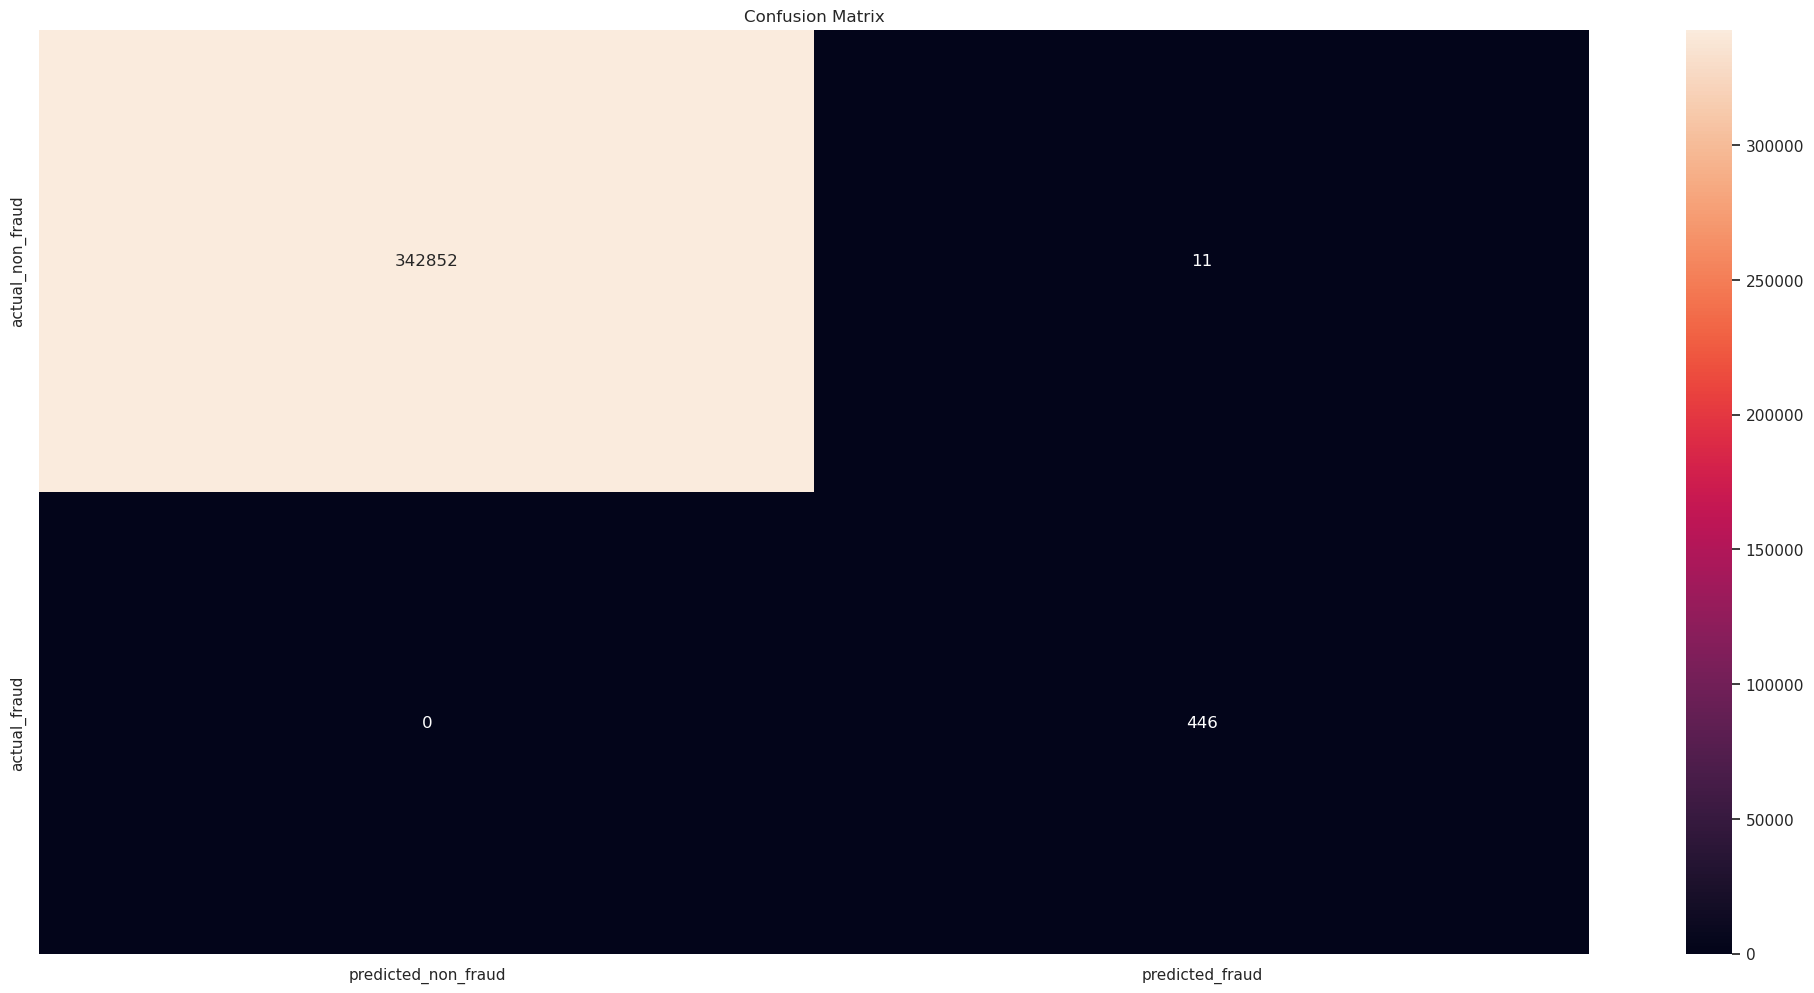

In [74]:
 # predictions
yhat_tuned = xgb_clf.predict(x_test)

# confusion matrix
xb_tuned_test_cm = confusion_matrix(y_test, yhat_tuned)

# dataframe for heatmap
xb_tuned_test_cm_df = pd.DataFrame(xb_tuned_test_cm, columns=['predicted_non_fraud', 'predicted_fraud'], index=['actual_non_fraud', 'actual_fraud'])

# confusion matrix heatmap
sns.heatmap(xb_tuned_test_cm_df, annot=True, fmt='d').set_title('Confusion Matrix');

In [75]:
# Precision
tuned_model_precision = precision_score(y_test, yhat_tuned)

# Recall
tuned_model_recall = recall_score(y_test, yhat_tuned)

print('Tuned Model Precision: {}'.format(tuned_model_precision))
print('Tuned Model Recall: {}'.format(tuned_model_recall))

Tuned Model Precision: 0.975929978118162
Tuned Model Recall: 1.0


In [83]:
 # save base model
# with open('model/clt.pkl', 'wb') as f:
#     pickle.dump(rf_clf, f)

# 9.0. Model and Business Performance

## 9.1. Model Performance on Test Set

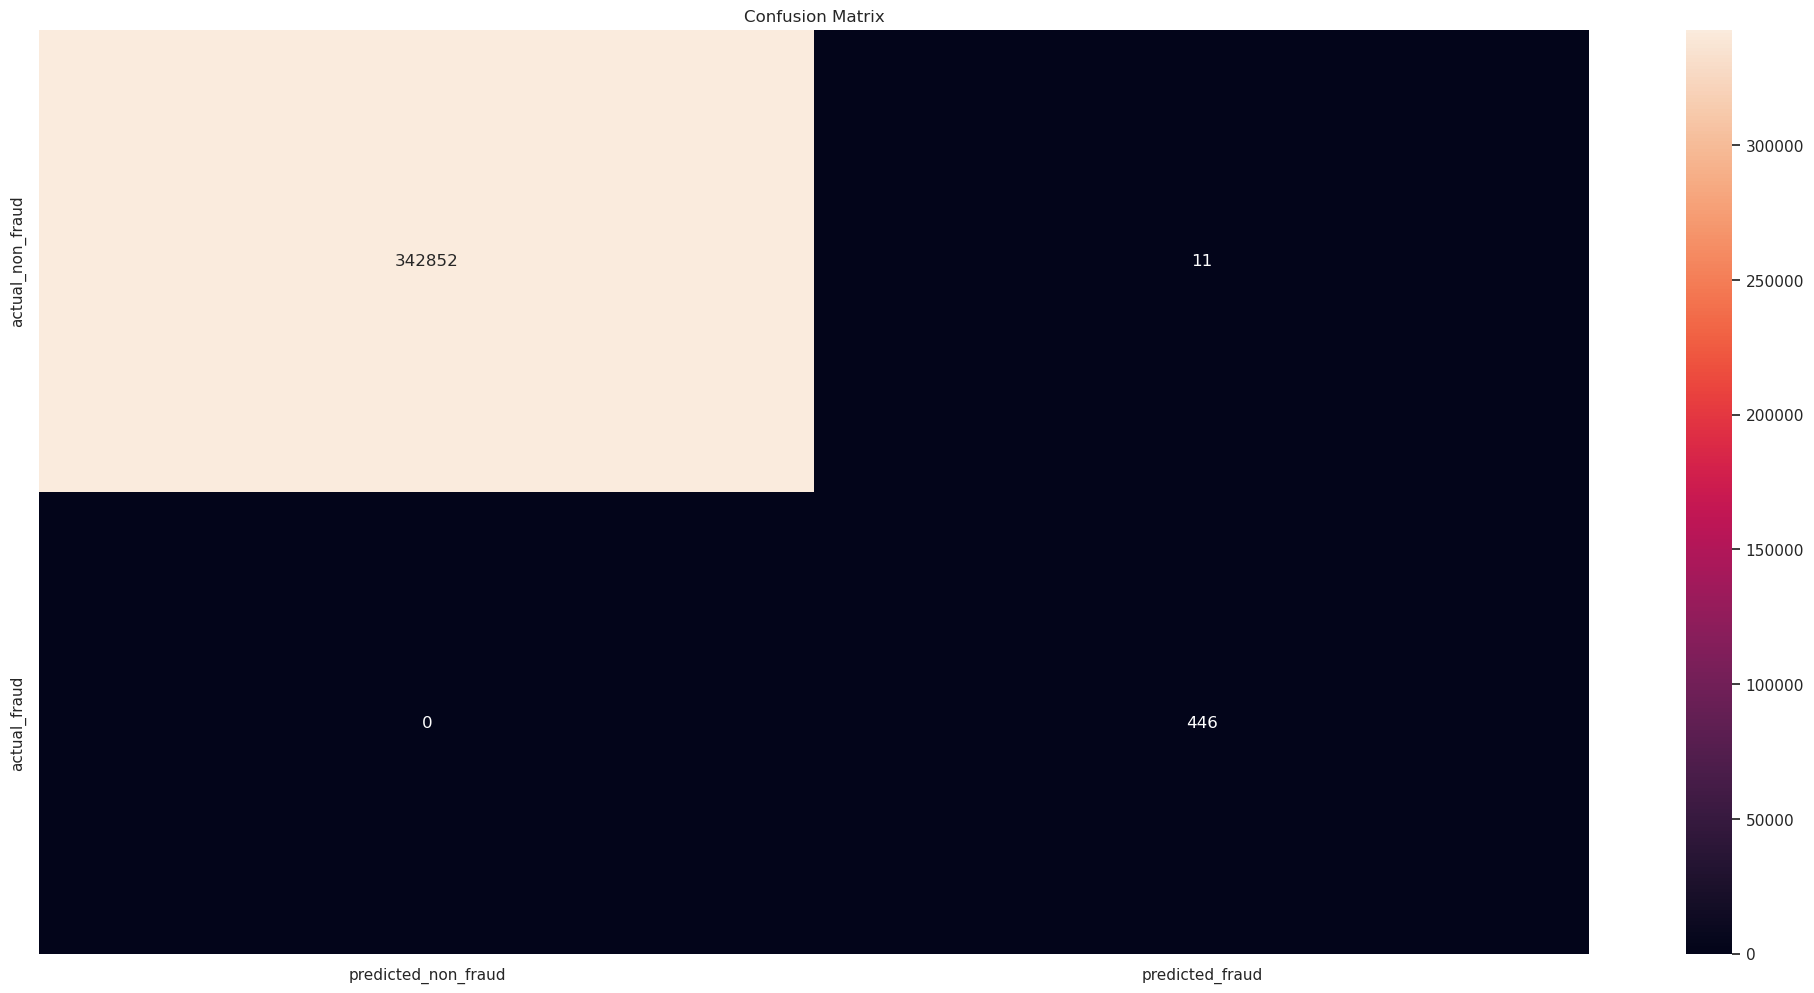

In [76]:
# confusion matrix heatmap
sns.heatmap(xb_tuned_test_cm_df, annot=True, fmt='d').set_title('Confusion Matrix');

In [77]:
# model precision
precision = precision_score(y_test, yhat_tuned)

# model accuracy
accuracy = accuracy_score(y_test, yhat_tuned)

# f1-score
f1 = f1_score(y_test, yhat_tuned)

# mcc
mcc = matthews_corrcoef(y_test, yhat_tuned)

# recall
recall = recall_score(y_test, yhat_tuned)

# False Positive xb_tuned_test_cm_df
FPR = xb_tuned_test_cm[0,1] / xb_tuned_test_cm[0].sum()

# summary dataframe
summary_df = pd.DataFrame([precision, accuracy, f1, mcc, recall, FPR], 
                          index=['Precision', 'Accuracy', 'F1-Score','MCC', 'Recall', 'False Positive Rate']).T

summary_df

Precision  Accuracy  F1-Score   MCC  Recall  False Positive Rate
0      0.976     1.000     0.988 0.988   1.000                0.000

## 9.2. Business Performance

 **Blocker Fraud Company Expansion Strategy in Brazil**
 
1. The company receives 25% of each transaction value truly detected as fraud.
2. The company receives 5% of each transaction value detected as fraud, however the transaction is legitimate.
3. The company gives back 100% of the value for the customer in each transaction detected as legitimate, however the transaction is actually a fraud.

In [43]:
df_test

step  day      type    name_orig     amount  oldbalance_org  \
0          1    1   CASH_IN   C713898436  55837.160     4849053.050   
1          1    1   CASH_IN   C864221358  25090.030     6572510.820   
2          1    1   PAYMENT   C247644034   4828.430       36736.580   
3          1    1  CASH_OUT  C1949126165  30308.450       88926.200   
4          1    1   PAYMENT   C247795540  12491.010           0.000   
...      ...  ...       ...          ...        ...             ...   
343533   715   30  CASH_OUT   C551661789 205836.120       50325.000   
343534   715   30  CASH_OUT   C571291780  41781.520       20837.000   
343535   717   30   PAYMENT  C1539090295  13106.610       35969.000   
343536   717   30   CASH_IN   C483131281  51872.550      912641.000   
343537   717   30  CASH_OUT   C634090625  89681.180        7054.000   

        newbalance_orig   diff_orig    name_dest  merchant_dest  \
0           4904890.210 -111674.320   C100555887              0   
1           6597600.850  -50180.060  C1282788025              0   
2             31908.140       0.010   M214313531              1   
3             88926.200  -30308.450  C1568059495              0   
4                 0.000  -12491.010   M200744172              1   
...                 ...         ...          ...            ...   
343533            0.000 -155511.120  C2073046775              0   
343534            0.000  -20944.520   C307265065              0   
343535        22862.390       0.000  M1936548557              1   
343536       964513.550 -103745.100  C1695137697              0   
343537            0.000  -82627.180   C290472837              0   

        oldbalance_dest  newbalance_dest  diff_dest  is_fraud  \
0             66800.820        10963.660 111674.320         0   
1             80148.600            0.000 105238.630         0   
2                 0.000            0.000   4828.430         0   
3             88926.200       122750.490  -3515.840         0   
4                 0.000            0.000  12491.010         0   
...                 ...              ...        ...       ...   
343533            0.000       205836.120      0.000         0   
343534       237929.930       279711.440      0.010         0   
343535            0.000            0.000  13106.610         0   
343536            0.000            0.000  51872.550         0   
343537      1184529.960      1274211.140      0.000         0   

        is_flagged_fraud  predictions  
0                      0            0  
1                      0            0  
2                      0            0  
3                      0            0  
4                      0            0  
...                  ...          ...  
343533                 0            0  
343534                 0            0  
343535                 0            0  
343536                 0            0  
343537                 0            0  

[343309 rows x 16 columns]

In [84]:
# Join predictions on the test set in order to calculate the business performance
df_test['predictions'] = yhat_tuned

# The company receives 25% of each transaction value truly detected as fraud.
fraud_detected = df_test[(df_test['is_fraud'] == 1) & (df_test['predictions'] == 1)]
fraud_detected_amount = fraud_detected[['amount', 'is_fraud', 'predictions']].\
    groupby(['is_fraud', 'predictions']).sum().reset_index()
fraud_detected_amount['to_receive'] = fraud_detected_amount['amount']*0.25

# The company receives 5% of each transaction value detected as fraud, however the transaction is legitimate.
fraud_detected_leg = df_test[(df_test['is_fraud'] == 0) & (df_test['predictions'] == 1)]
fraud_detected_leg_amount = fraud_detected_leg[['amount', 'is_fraud', 'predictions']].\
    groupby(['is_fraud', 'predictions']).sum().reset_index()
fraud_detected_leg_amount['to_receive'] = fraud_detected_leg_amount['amount']*0.05
#fraud_detected_leg_amount

# The company gives back 100% of the value for the customer in each transaction detected as legitimate, however the transaction is actually a fraud.
# fraud_not_detected = df_test[(df_test['is_fraud'] == 1) & (df_test['predictions'] == 0)]
# fraud_not_detected_amount = fraud_not_detected[['amount', 'is_fraud', 'predictions']].\
#     groupby(['is_fraud', 'predictions']).sum().reset_index()

# print results
print('The company will receive {:,.2f} due to transactions truly detected as fraud'.format(fraud_detected_amount['to_receive'][0]))
print('The company will receive {:,.2f} due to transactions detected as fraud, but actually legitimate'.\
      format(fraud_detected_leg_amount['to_receive'][0]))
# print('The company will give back {:,.2f} due to transactions detected as legitimate, but actually fraud'.\
#       format(fraud_not_detected_amount['amount'][0]))

The company will receive 184,154,225.24 due to transactions truly detected as fraud
The company will receive 2,600.82 due to transactions detected as fraud, but actually legitimate


### 9.3.2. Model's Performance Results on the Business

 
- Model performance and results report with respect to profit and loss. The following questions must be answered:
    - What is the model's precision and accuracy?
    - What is the model's reliability with respect to transactions' classification as legitimate or fraudulent?
    - What is the company's forecasted revenue if the model classifies 100% of the transactions?
    - What is the company's forecasted loss in case of model's failure?
    - What is the Blocker Fraud Company forecasted profit using the model?

 
- The model has a precision of 60.93% and an accuracy of 99.92%. Remark: the accuracy is not recommended for business metric due to the intrinsic skewed data with respect to fraudulent transactions. Instead, it can be used the F1-Score, which is the harmonic mean of precision and True Positive Rate (also known as Recall). The F1-Score of the model is 75.62%.
- **The model can detect 99.63% of fraudulent transactions**. The false positive rate is only 0.08%.
- The forecasted revenue is more than 879 million from transactions truly detected as fraud and more than 600 thousand from transactions detected as fraud, but actually legitimate.
- The forecasted loss is about 2,4 million due to transactions detected as legitimate, but actually fraud.
- **The Blocker Fraud Company forecasted profit is 877,5 million.**

### 9.3.3. Next Steps

- Model Deployment;
- Train another model in order to improve the True Positive Rate (Recall);
- Model's hyperparameters experiment and evaluation;